![lop](../../images/logo_diive1_128px.png)

<span style='font-size:40px; display:block;'>
<b>
    Flux Processing Chain
</b>
</br>
  
</span>
<p>Post-processing of EddyPro <i>_fluxnet_</i> output files</p>

---
**Notebook version**: `10.0` (19 Mar 2025)  
**Author**: Lukas Hörtnagl (holukas@ethz.ch)  

</br>

</br>

---

# **BACKGROUND**

---

- This notebook demonstrates part of the flux post-processing used for fluxes from Swiss FluxNet research stations
- For a description of the different flux levels, see [Flux Processing Chain](https://www.swissfluxnet.ethz.ch/index.php/data/ecosystem-fluxes/flux-processing-chain/) on the Swiss FluxNet homepage
- There is also a good overview here: [Flux Processing Chain described for CH-CHA Flux Product](https://holukas.github.io/dataset_ch-cha_flux_product/Overview.html#flux-processing-chain)
- Flux calculations (Level-1) were done in a previous step
- This notebook uses the calculated fluxes (Level-1) and applies several post-processing steps:
    - Quality flag extension (Level-2)
    - Storage correction (Level-3.1)
    - Outlier removal (Level-3.2)
    - USTAR filtering (Level-3.3) - needs *known* thresholds from separate analysis, e.g. from FLUXNET
    - Gap-filling (Level-4.1) for flux using multiple methods ([MDS](../GapFilling/FluxMDSGapFilling.ipynb), [long-term random forest](../GapFilling/LongTermRandomForestGapFilling.ipynb))
- Other flux levels are currently not produced in this example:
    
    - NEE Partitioning (Level-4.2)
 
**Important**
- Flux variable names in the input files should follow the [FLUXNET convention](https://fluxnet.org/data/fluxnet2015-dataset/fullset-data-product/)

</br>

</br>

---

# **GENERAL SETTINGS**

---

## Flux variable
`FLUXVAR` is the name of the flux variable in the data files. In the EddyPro `_fluxnet_` output files, the flux variables we primarily use are:
  - `FC` ... CO2 flux, becomes `NEE` after storage correction (Level-3.1)
  - `LE` ... Latent heat flux (water)
  - `H` ... Sensible heat flux
  - `FN2O` ... Nitrous oxide flux
  - `FCH4` ... Methane flux
  
There are more flux variables in the output file, but we rarely need them:
  - `FH2O` ... H2O flux, very important but it is the same as `ET` and `LE` but with different units
  - `ET` ... Evapotranspiration, very important but it is the same as `FH2O` and `LE` but with different units. We can easily calculte `ET` later from `LE`, e.g. in `ReddyProc`.
  - `TAU` ... Momentum flux, a measure of the turbulent transfer of momentum between the land surface and the atmosphere

Set the name of the flux variable in the output file(s), must use the FLUXNET naming convention, e.g. FC, FH2O, LE, ET, H, FN2O, FCH4:

In [1]:
FLUXVAR = "FC"

## Site location
- Latitude and longitude of the site where data were recorded. This info is mainly used to calculate potential radiation, which is then used to divide the dataset into daytime and nighttime data.
- UTC offset of the timestamp used in the dataset, important for calculating potential radiation for this location with the correct timestamp.

In [2]:
SITE_LAT = 47.41887
SITE_LON = 8.491318
UTC_OFFSET = 1  # Time stamp offset in relation to UTC, e.g. 1 for UTC+01:00 (CET), important for the calculation of potential radiation for detecting daytime and nighttime

## Daytime/nighttime
- Threshold for potential radiation in `W m-2`, records below threshold are considered nighttime

In [3]:
NIGHTTIME_THRESHOLD = 20

## Quality requirements
- `DAYTIME_ACCEPT_QCF_BELOW = 2` accepts high- (`QCF=0`) and medium-quality (`QCF=1`) fluxes for *daytime*, rejects low-quality (`QCF=2`) fluxes
- `NIGHTTIMETIME_ACCEPT_QCF_BELOW = 1` accepts high-quality (`QCF=0`) fluxes for *nighttime*, rejects medium-quality (`QCF=1`) and low-quality (`QCF=2`) fluxes
- This strict quality-filtering removes a lot of data points during nighttime

In [4]:
DAYTIME_ACCEPT_QCF_BELOW = 2
NIGHTTIMETIME_ACCEPT_QCF_BELOW = 2

</br>

---

# **IMPORTS**

---

- This notebook uses `diive` ([source code](https://github.com/holukas/diive)) to check eddy covariance fluxes for quality

In [5]:
import importlib.metadata
import warnings
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats
import seaborn as sns

from diive.core.dfun.stats import sstats  # Time series stats
from diive.core.io.files import save_parquet, load_parquet
from diive.core.plotting.timeseries import TimeSeries  # For simple (interactive) time series plotting
from diive.pkgs.flux.hqflux import analyze_highest_quality_flux
from diive.pkgs.fluxprocessingchain.fluxprocessingchain import FluxProcessingChain
from diive.pkgs.fluxprocessingchain.fluxprocessingchain import LoadEddyProOutputFiles

warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)
version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")

diive version: v0.87.0


</br>

</br>

---

# **DOCSTRING** for `FluxProcessingChain`

---

In [6]:
# help(FluxProcessingChain)

</br>

</br>

---

# **LOAD DATA** (2 options)

---

- It is possible to load data from (multiple) EddyPro _fluxnet_ output files (data from files will be merged), or directly from one single [parquet](https://parquet.apache.org/) file.
- parquet files are a good option for large datasets because they load and save much faster than when using conventional CSV files.
- For large datasets, it makes sense to first load and merge data from the original EddyPro _fluxnet_ output files, then convert the merged data to one single parquet file and then use this file as input file.

</br>

## Option 1: Load data from single or multiple EddyPro *_fluxnet_* output files
- Used to read data from the EddyPro _fluxnet_ output files
- Found files will be merged together into one single dataframe (`maindf`)

If you want to search for EddyPro _fluxnet_ files in specific locations, you can specify multiple folders here:

In [7]:
# # Folder(s) where input file(s) are located
# SOURCEDIRS = [r'example_data/']  

In [8]:
# ep = LoadEddyProOutputFiles(sourcedir=SOURCEDIRS, filetype='EDDYPRO-FLUXNET-CSV-30MIN')
# ep.searchfiles()
# ep.loadfiles()
# maindf = ep.maindf
# metadata = ep.metadata

</br>

## Option 2: Load data from `parquet` file
- Can be used to continue a previous session where another flux variable was already post-processed
- For example, if you have already post-processed CO2 flux and now want to post-process H2O flux
- Also detects time resolution of time series, this info was lost when saving to the parquet file

If you want to load data directly from a specific parquet file, you can specify its name and location here:

In [9]:
SOURCEDIR = r"..\0_data\OPENLAG-IRGA-Level-0_fluxnet_2024-2025.05"
FILENAME = r"FLUXES_L0_ALL.parquet"
FILEPATH = Path(SOURCEDIR) / FILENAME
print(f"Data will be loaded from the following file:\n{FILEPATH}")

Data will be loaded from the following file:
..\0_data\OPENLAG-IRGA-Level-0_fluxnet_2024-2025.05\FLUXES_L0_ALL.parquet


In [10]:
maindf = load_parquet(filepath=FILEPATH)

Loaded .parquet file ..\0_data\OPENLAG-IRGA-Level-0_fluxnet_2024-2025.05\FLUXES_L0_ALL.parquet (0.095 seconds).
    --> Detected time resolution of <30 * Minutes> / 30min 


## REMOVE WIND DIRECTIONS

In [11]:
maindf['WD']

TIMESTAMP_MIDDLE
2024-02-06 19:15:00    172.713
2024-02-06 19:45:00    180.467
2024-02-06 20:15:00    183.015
2024-02-06 20:45:00    189.732
2024-02-06 21:15:00    196.681
                        ...   
2025-06-01 22:45:00    214.139
2025-06-01 23:15:00    218.704
2025-06-01 23:45:00    214.562
2025-06-02 00:15:00    219.221
2025-06-02 00:45:00    201.150
Freq: 30min, Name: WD, Length: 23100, dtype: float64

In [12]:
locs = (maindf['WD'] > 180) & (maindf['WD'] < 350)
import numpy as np
maindf.loc[locs, :] = np.nan
maindf.loc[locs, :]

AIR_MV  AIR_DENSITY  AIR_RHO_CP  AIR_CP  AOA_METHOD  AXES_ROTATION_METHOD  ...  W_ITC  W_ITC_TEST  WBOOST_APPLIED  WPL_APPLIED  ZL  ZL_UNCORR
TIMESTAMP_MIDDLE                                                                                ...                                                               
2024-02-06 19:45:00     NaN          NaN         NaN     NaN         NaN                   NaN  ...    NaN         NaN             NaN          NaN NaN        NaN
2024-02-06 20:15:00     NaN          NaN         NaN     NaN         NaN                   NaN  ...    NaN         NaN             NaN          NaN NaN        NaN
2024-02-06 20:45:00     NaN          NaN         NaN     NaN         NaN                   NaN  ...    NaN         NaN             NaN          NaN NaN        NaN
2024-02-06 21:15:00     NaN          NaN         NaN     NaN         NaN                   NaN  ...    NaN         NaN             NaN          NaN NaN        NaN
2024-02-06 21:45:00     NaN          NaN         NaN     NaN         NaN                   NaN  ...    NaN         NaN             NaN          NaN NaN        NaN
...                     ...          ...         ...     ...         ...                   ...  ...    ...         ...             ...          ...  ..        ...
2025-06-01 22:45:00     NaN          NaN         NaN     NaN         NaN                   NaN  ...    NaN         NaN             NaN          NaN NaN        NaN
2025-06-01 23:15:00     NaN          NaN         NaN     NaN         NaN                   NaN  ...    NaN         NaN             NaN          NaN NaN        NaN
2025-06-01 23:45:00     NaN          NaN         NaN     NaN         NaN                   NaN  ...    NaN         NaN             NaN          NaN NaN        NaN
2025-06-02 00:15:00     NaN          NaN         NaN     NaN         NaN                   NaN  ...    NaN         NaN             NaN          NaN NaN        NaN
2025-06-02 00:45:00     NaN          NaN         NaN     NaN         NaN                   NaN  ...    NaN         NaN             NaN          NaN NaN        NaN

[11675 rows x 480 columns]

</br>

## Option 3: Load example data

In [13]:
# from diive.configs.exampledata import load_exampledata_EDDYPRO_FLUXNET_CSV_30MIN
# maindf, metadata = load_exampledata_EDDYPRO_FLUXNET_CSV_30MIN()

</br>

## (Optional) Restrict data to time range

In [14]:
# # Restrict data range
# maindf = maindf.loc[(maindf.index.year >= 2022) & (maindf.index.year <= 2023)].copy()  # One year
# # maindf = maindf.loc[(maindf.index.year >= 2022) & (maindf.index.year <= 2022) & (maindf.index.month >= 6) & (maindf.index.month <= 7)].copy()

</br>

## Check data

In [15]:
display(maindf.head(3))
display(maindf.tail(3))
display(sstats(maindf[FLUXVAR]))

AIR_MV  AIR_DENSITY  AIR_RHO_CP   AIR_CP  AOA_METHOD  AXES_ROTATION_METHOD  ...  W_ITC  W_ITC_TEST  WBOOST_APPLIED  WPL_APPLIED        ZL  ZL_UNCORR
TIMESTAMP_MIDDLE                                                                                   ...                                                                     
2024-02-06 19:15:00  0.024925      1.16151     1172.76  1009.69         0.0                   1.0  ...    0.0         1.0             0.0          1.0  0.183948   0.183832
2024-02-06 19:45:00       NaN          NaN         NaN      NaN         NaN                   NaN  ...    NaN         NaN             NaN          NaN       NaN        NaN
2024-02-06 20:15:00       NaN          NaN         NaN      NaN         NaN                   NaN  ...    NaN         NaN             NaN          NaN       NaN        NaN

[3 rows x 480 columns]

AIR_MV  AIR_DENSITY  AIR_RHO_CP  AIR_CP  AOA_METHOD  AXES_ROTATION_METHOD  ...  W_ITC  W_ITC_TEST  WBOOST_APPLIED  WPL_APPLIED  ZL  ZL_UNCORR
TIMESTAMP_MIDDLE                                                                                ...                                                               
2025-06-01 23:45:00     NaN          NaN         NaN     NaN         NaN                   NaN  ...    NaN         NaN             NaN          NaN NaN        NaN
2025-06-02 00:15:00     NaN          NaN         NaN     NaN         NaN                   NaN  ...    NaN         NaN             NaN          NaN NaN        NaN
2025-06-02 00:45:00     NaN          NaN         NaN     NaN         NaN                   NaN  ...    NaN         NaN             NaN          NaN NaN        NaN

[3 rows x 480 columns]

FC
STARTDATE      2024-02-06 19:15
ENDDATE        2025-06-02 00:45
PERIOD        481 days 05:30:00
NOV                        9378
MISSING                   13722
MISSING_PERC          59.402597
MEAN                  -1.157543
MEDIAN                -0.326415
SD                    25.129777
VAR                  631.505697
SD/MEAN              -21.709578
SUM                -10855.44146
MIN                     -593.21
MAX                     759.037
P01                  -71.693257
P05                  -18.018605
P25                   -5.021967
P75                     2.73786
P95                    14.04215
P99                    58.47851

In [16]:
# [print(c) for c in maindf.columns if "SW" in c]

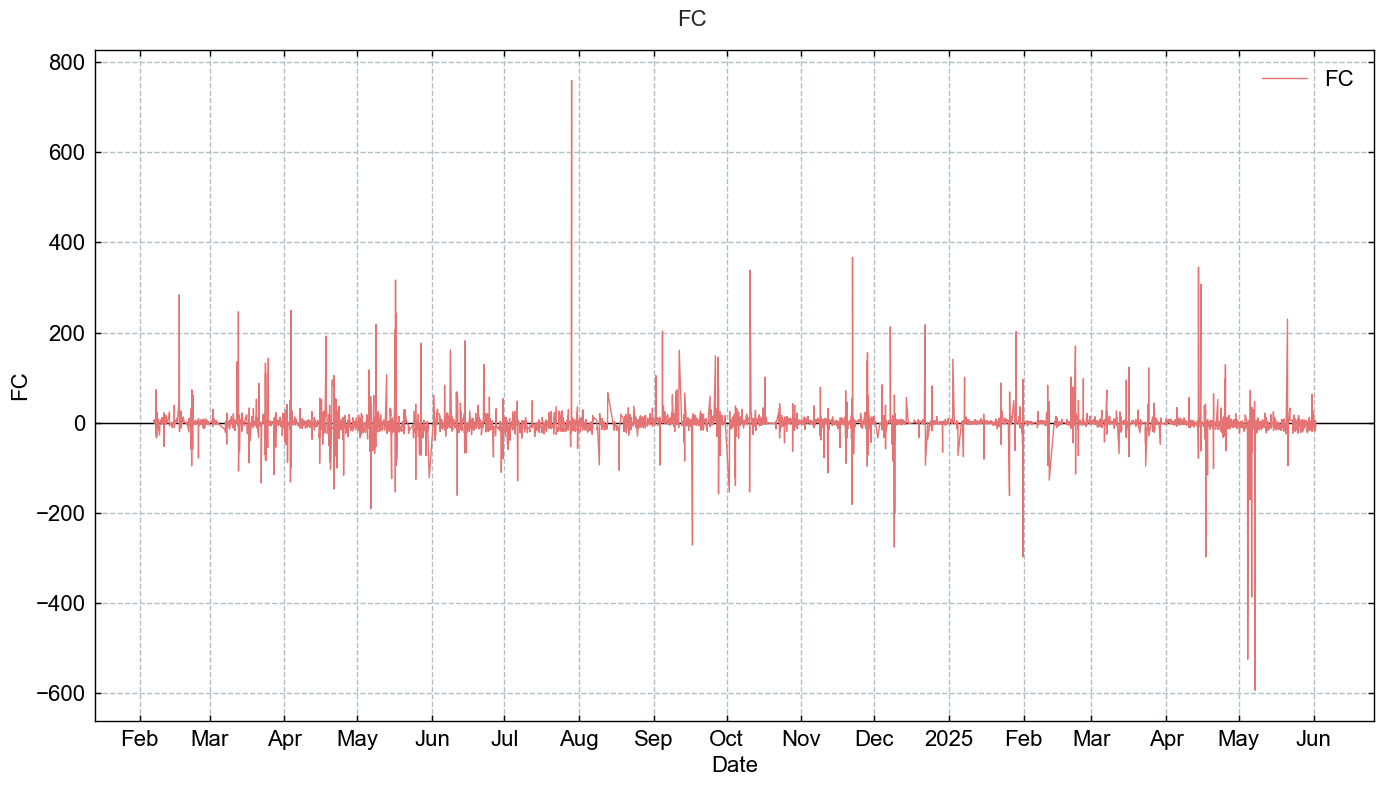

In [17]:
# TimeSeries(series=maindf[FLUXVAR]).plot_interactive()
TimeSeries(series=maindf[FLUXVAR]).plot()

</br>

</br>

---

# **START FLUX PROCESSING CHAIN**

---

- First we need to initialize the processing chain by providing some basic info.
- At the same time, some fundamental variables are also created: potential radiation, and two flags based on it: daytime flag (1=daytime) and nighttime flag (1=nighttime).

In [18]:
fpc = FluxProcessingChain(
    df=maindf,
    fluxcol=FLUXVAR,
    site_lat=SITE_LAT,
    site_lon=SITE_LON,
    utc_offset=UTC_OFFSET,    
    nighttime_threshold=NIGHTTIME_THRESHOLD,
    daytime_accept_qcf_below=DAYTIME_ACCEPT_QCF_BELOW,
    nighttimetime_accept_qcf_below=NIGHTTIMETIME_ACCEPT_QCF_BELOW
)

Detected base variable CO2 for FC. (CO2 was used to calculate FC.)
Calculated potential radiation from latitude and longitude (SW_IN_POT) ... 
Calculated daytime flag DAYTIME and nighttime flag NIGHTTIME from SW_IN_POT ...
++ Added new column SW_IN_POT to input data.  (!) Existing SW_IN_POT in input data is overwritten.
++ Added new column DAYTIME to input data.
++ Added new column NIGHTTIME to input data.


- Let's check the flux processing chain dataframe: this are the data the chain is working with in this run:

In [19]:
fpc.fpc_df

FC     USTAR  SW_IN_POT  DAYTIME  NIGHTTIME
TIMESTAMP_MIDDLE                                                     
2024-02-06 19:15:00  2.60333  0.166264        0.0      0.0        1.0
2024-02-06 19:45:00      NaN       NaN        0.0      0.0        1.0
2024-02-06 20:15:00      NaN       NaN        0.0      0.0        1.0
2024-02-06 20:45:00      NaN       NaN        0.0      0.0        1.0
2024-02-06 21:15:00      NaN       NaN        0.0      0.0        1.0
...                      ...       ...        ...      ...        ...
2025-06-01 22:45:00      NaN       NaN        0.0      0.0        1.0
2025-06-01 23:15:00      NaN       NaN        0.0      0.0        1.0
2025-06-01 23:45:00      NaN       NaN        0.0      0.0        1.0
2025-06-02 00:15:00      NaN       NaN        0.0      0.0        1.0
2025-06-02 00:45:00      NaN       NaN        0.0      0.0        1.0

[23100 rows x 5 columns]

</br>

</br>

---

# Level-2: **QUALITY FLAG EXTENSION**

---

> Extract additional quality information from the EddyPro output and store it in newly added quality flags.



Note that the USTAR filtering is not part of the Level-2 calculations.

</br>

## User settings
- A test for missing values is always included: flag calculated here from missing flux values in the EddyPro output file

</br>

### SSITC tests (default: `True`)
- Flag calculated in EddyPro
- Combination of the two partial tests *steady state test* and *developed turbulent conditions test*
- This notebook expects the SSITC flag to follow the flagging policy according to Mauder and Foken 2004:
    - `0` for best quality fluxes
    - `1` for fluxes suitable for general analysis such as annual budgets (although this is debatable for nighttime data)
    - `2` for fluxes that should be discarded from the dataset
- `TEST_SSITC_SETFLAG_TIMEPERIOD` can be used to specify time periods when the flag is set to given value, allowing for stricter SSITC filtering during certain time periods. 
    - For example: Set flag 1 to value 2 between '2022-05-01' and '2023-09-30', and between '2024-04-02' and '2024-04-19' (dates inclusive):
                    `TEST_SSITC_SETFLAG_TIMEPERIOD = {2: [ [1, '2022-05-01', '2023-09-30'], [1, '2024-04-02', '2024-04-19'] ]}`

In [20]:
TEST_SSITC = True  # True or False (default: True)
TEST_SSITC_SETFLAG_TIMEPERIOD = None
# TEST_SSITC_SETFLAG_TIMEPERIOD = {2: [[1, '2022-05-01', '2023-09-30']]}

</br>

### Flux base variable completeness test (default: `True`)
- Flag newly calculated here
- Check completeness of the variable that was used to calculate the respective flux
- Example: `CO2` is the base variable that was used to calculate flux `FC`, the test is therefore run on `CO2`
- Checks number of records of the relevant base variable available for each averaging Interval and calculates completeness flag as follows:
    - `0` for files where >= 99% of base variable are available
    - `1` for files where >= 97% and < 99% of base variable are available
    - `2` for files where < 97% of base variable are available
 
List of flux base variables and the corresponding fluxes:
- `CO2`: used to calculate `FC`
- `H2O`: used to calculate `FH2O`
- `H2O`: used to calculate `LE`
- `H2O`: used to calculate `ET`
- `T_SONIC`: used to calculate `H`
- `N2O`: used to calculate `FN2O`
- `CH4`: used to calculate `FCH4`

In [21]:
TEST_GAS_COMPLETENESS = True  # True or False (default: True)

</br>

### Spectral correction factor test (default: `True`)
- Flag calculated here from the gas `SCF` variable in EddyPro output file

In [22]:
TEST_SPECTRAL_CORRECTION_FACTOR = True  # True or False (default: True)

</br>

### Signal strength test

<div class="alert alert-block alert-info">
<b>Always recommended if flux was calculated using a gas analyzer.</b>
</div>  

<div class="alert alert-block alert-danger">
<b>Do not use for H (sensible heat flux).</b> This test is only relevant for fluxes where the concentration/temperature was measured by a gas analyzer, e.g. FC, FH2O, LE, ET, N2O, CH4, etc ... 
</div>  

- Signal strength / AGC / window dirtiness test (if available)
- Flag calculated here from the signal strength / AGC variable for the gas analyzer in EddyPro output file.
- The original info for this flag comes from the IRGA diagnostics. If the flag was already considered during EddyPro processing (bad values already filtered out) then this flag does probably not need to be considered here.
- `SIGNAL_STRENGTH_COL`: Name of the column storing the signal strength, e.g. `CUSTOM_AGC_MEAN` for LI-7500, `CUSTOM_SIGNAL_STRENGTH_IRGA72_MEAN` for LI-7200, or something similar.
- `SIGNAL_STRENGTH_THRESHOLD`: Signal strength threshold, flux values where threshold is exceeded are flagged as rejected.
- `SIGNAL_STRENGTH_METHOD`: `discard above` flags fluxes where signal strength > threshold, `discard below` where signal strength < threshold. FOr IRGAs such as LI-7200 high signal strength values mean good signal, low values bad signal. For the open-path IRGA LI-7500 it is the opposite: high values bad signal, low values good signal.

In [23]:
# Signal strength
TEST_SIGNAL_STRENGTH = True  # True or False (default: True)
TEST_SIGNAL_STRENGTH_COL = 'CUSTOM_AGC_MEAN'  # Variable name in fluxnet files
TEST_SIGNAL_STRENGTH_METHOD = 'discard above'  # 'discard above' or 'discard below'
TEST_SIGNAL_STRENGTH_THRESHOLD = 90

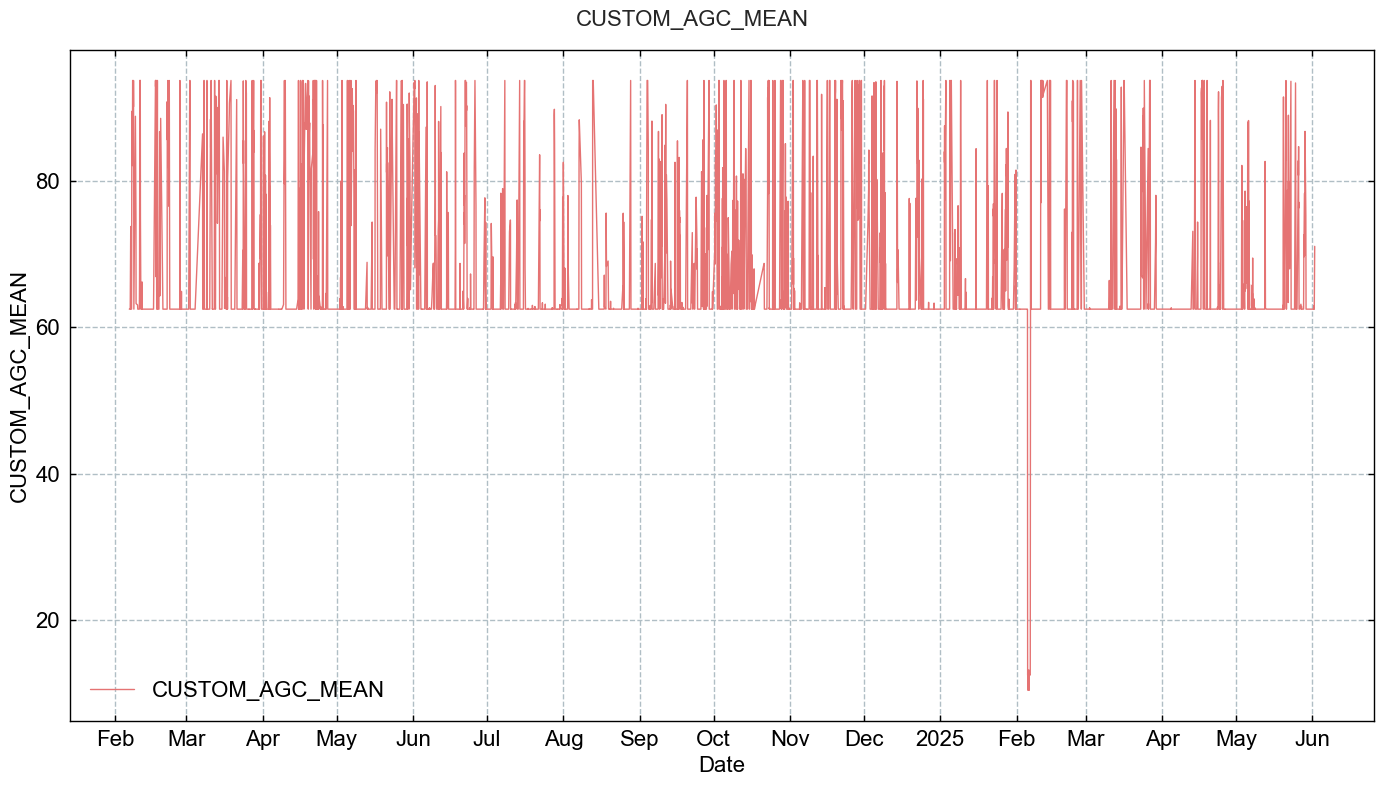

In [24]:
# TimeSeries(series=df_orig[SIGNAL_STRENGTH_COL]).plot_interactive()
TimeSeries(series=maindf[TEST_SIGNAL_STRENGTH_COL]).plot()

</br>

### Raw data screening tests
- Flags were calculated in EddyPro
- See here for more details: [Despiking and raw data statistical screening (EddyPro help)](https://www.licor.com/env/support/EddyPro/topics/despiking-raw-statistical-screening.html)

In [25]:
TEST_RAWDATA = True  # Default True
TEST_RAWDATA_SPIKES = True  # Default True
TEST_RAWDATA_AMPLITUDE = True  # Default True
TEST_RAWDATA_DROPOUT = True  # Default True
TEST_RAWDATA_ABSLIM = False  # Default False
TEST_RAWDATA_SKEWKURT_HF = False  # Default False
TEST_RAWDATA_SKEWKURT_SF = False  # Default False
TEST_RAWDATA_DISCONT_HF = False  # Default False
TEST_RAWDATA_DISCONT_SF = False  # Default False

</br>

### Angle-of-attack test (default: `False`)
> This test calculates sample-wise Angle of Attacks throughout the current flux averaging period, and flags it if the percentage of angles of attack exceeding a user-defined range is beyond a (user-defined) threshold.  
> Source: [EddyPro help](https://www.licor.com/env/support/EddyPro/topics/despiking-raw-statistical-screening.html?Highlight=angle%20of%20attack#Angleofattack)  *(3 Jan 2024)*
- Flag was calculated in EddyPro
- Flag can be useful during some time periods when the sonic anemometer had issues
- Not used by default (similar to ICOS)

In [26]:
TEST_RAWDATA_ANGLE_OF_ATTACK = False  # Default False
TEST_RAWDATA_ANGLE_OF_ATTACK_APPLICATION_DATES = []
# TEST_RAWDATA_ANGLE_OF_ATTACK_APPLICATION_DATES = [['2008-01-01', '2010-01-01'],
#                                                   ['2016-03-01', '2016-05-01']]

</br>

### Steadiness of horizontal wind test (default: `False`)
> This test assesses whether the along-wind and crosswind components of the wind vector undergo a systematic reduction (or increase) throughout the file. If the quadratic combination of such systematic variations is beyond the user-selected limit, the flux averaging period is hard-flagged for instationary horizontal wind (Vickers and Mahrt, 1997, Par. 6g).  
> Source: [EddyPro help](https://www.licor.com/env/support/EddyPro/topics/despiking-raw-statistical-screening.html?Highlight=angle%20of%20attack#Steadinessofhorizontalwind)  *(3 Jan 2024)*
- Flag was calculated in EddyPro

In [27]:
TEST_RAWDATA_STEADINESS_OF_HORIZONTAL_WIND = False  # Default False

</br>

</br>

## Run

In [28]:
LEVEL2_SETTINGS = {
    'signal_strength': {
        'apply': TEST_SIGNAL_STRENGTH,
        'signal_strength_col': TEST_SIGNAL_STRENGTH_COL,
        'method': TEST_SIGNAL_STRENGTH_METHOD,
        'threshold': TEST_SIGNAL_STRENGTH_THRESHOLD},
    'raw_data_screening_vm97': {
        'apply': TEST_RAWDATA,
        'spikes': TEST_RAWDATA_SPIKES,
        'amplitude': TEST_RAWDATA_AMPLITUDE,
        'dropout': TEST_RAWDATA_DROPOUT,
        'abslim': TEST_RAWDATA_ABSLIM,
        'skewkurt_hf': TEST_RAWDATA_SKEWKURT_HF,
        'skewkurt_sf': TEST_RAWDATA_SKEWKURT_SF,
        'discont_hf': TEST_RAWDATA_DISCONT_HF,
        'discont_sf': TEST_RAWDATA_DISCONT_SF},
    'ssitc': {
        'apply': TEST_SSITC,
        'setflag_timeperiod': TEST_SSITC_SETFLAG_TIMEPERIOD},
    'gas_completeness': {
        'apply': TEST_GAS_COMPLETENESS},
    'spectral_correction_factor': {
        'apply': TEST_SPECTRAL_CORRECTION_FACTOR},
    'angle_of_attack': {
        'apply': TEST_RAWDATA_ANGLE_OF_ATTACK,
        'application_dates': TEST_RAWDATA_ANGLE_OF_ATTACK_APPLICATION_DATES},
    'steadiness_of_horizontal_wind': {
        'apply': TEST_RAWDATA_STEADINESS_OF_HORIZONTAL_WIND}
}
fpc.level2_quality_flag_expansion(**LEVEL2_SETTINGS)

[MissingValues]  running MissingValues ...
SSITC TEST: Generated new flag variable FLAG_L2_FC_SSITC_TEST, values taken from output variable FC_SSITC_TEST ...
FLUX BASE VARIABLE COMPLETENESS TEST: Generated new flag variable FLAG_L2_FC_COMPLETENESS_TEST, newly calculated from variable CO2, with flag 0 (good values) where available number of records for CO2 >= 0.99, flag 1 (ok values) >= 0.97 and < 0.99, flag 2 (bad values) < 0.97...
SPECTRAL CORRECTION FACTOR TEST: Generating new flag variable FLAG_L2_FC_SCF_TEST, newly calculated from output variable FC_SCF, withflag 0 (good values) where FC_SCF < 2, flag 1 (ok values) where FC_SCF >= 2 and < 4, flag 2 (bad values) where FC_SCF >= 4...
SIGNAL STRENGTH TEST: Generating new flag variable FLAG_L2_FC_SIGNAL_STRENGTH_TEST, newly calculated from output variable CUSTOM_AGC_MEAN, with flag 0 (good values) where CUSTOM_AGC_MEAN <= 90, flag 2 (bad values) where CUSTOM_AGC_MEAN > 90 ...
RAW DATA TEST: Generated new flag variable FLAG_L2_FC_CO2_VM

</br>

</br>

## Finalize Level-2

In [29]:
fpc.finalize_level2()

++Added new column FLAG_L2_FC_MISSING_TEST.
++Added new column FLAG_L2_FC_SSITC_TEST.
++Added new column FLAG_L2_FC_COMPLETENESS_TEST.
++Added new column FLAG_L2_FC_SCF_TEST.
++Added new column FLAG_L2_FC_SIGNAL_STRENGTH_TEST.
++Added new column FLAG_L2_FC_CO2_VM97_SPIKE_HF_TEST.
++Added new column FLAG_L2_FC_CO2_VM97_AMPLITUDE_RESOLUTION_HF_TEST.
++Added new column FLAG_L2_FC_CO2_VM97_DROPOUT_TEST.
++Added new column SUM_L2_FC_HARDFLAGS.
++Added new column SUM_L2_FC_SOFTFLAGS.
++Added new column SUM_L2_FC_FLAGS.
++Added new column FLAG_L2_FC_QCF.
++Added new column FC_L2_QCF.
++Added new column FC_L2_QCF0.


</br>

### Available `Level-2` variables
- This shows all available Level-2 variables for this flux

In [30]:
[x for x in fpc.fpc_df.columns if 'L2' in x]

['FLAG_L2_FC_MISSING_TEST',
 'FLAG_L2_FC_SSITC_TEST',
 'FLAG_L2_FC_COMPLETENESS_TEST',
 'FLAG_L2_FC_SCF_TEST',
 'FLAG_L2_FC_SIGNAL_STRENGTH_TEST',
 'FLAG_L2_FC_CO2_VM97_SPIKE_HF_TEST',
 'FLAG_L2_FC_CO2_VM97_AMPLITUDE_RESOLUTION_HF_TEST',
 'FLAG_L2_FC_CO2_VM97_DROPOUT_TEST',
 'SUM_L2_FC_HARDFLAGS',
 'SUM_L2_FC_SOFTFLAGS',
 'SUM_L2_FC_FLAGS',
 'FLAG_L2_FC_QCF',
 'FC_L2_QCF',
 'FC_L2_QCF0']

</br>

### Plots

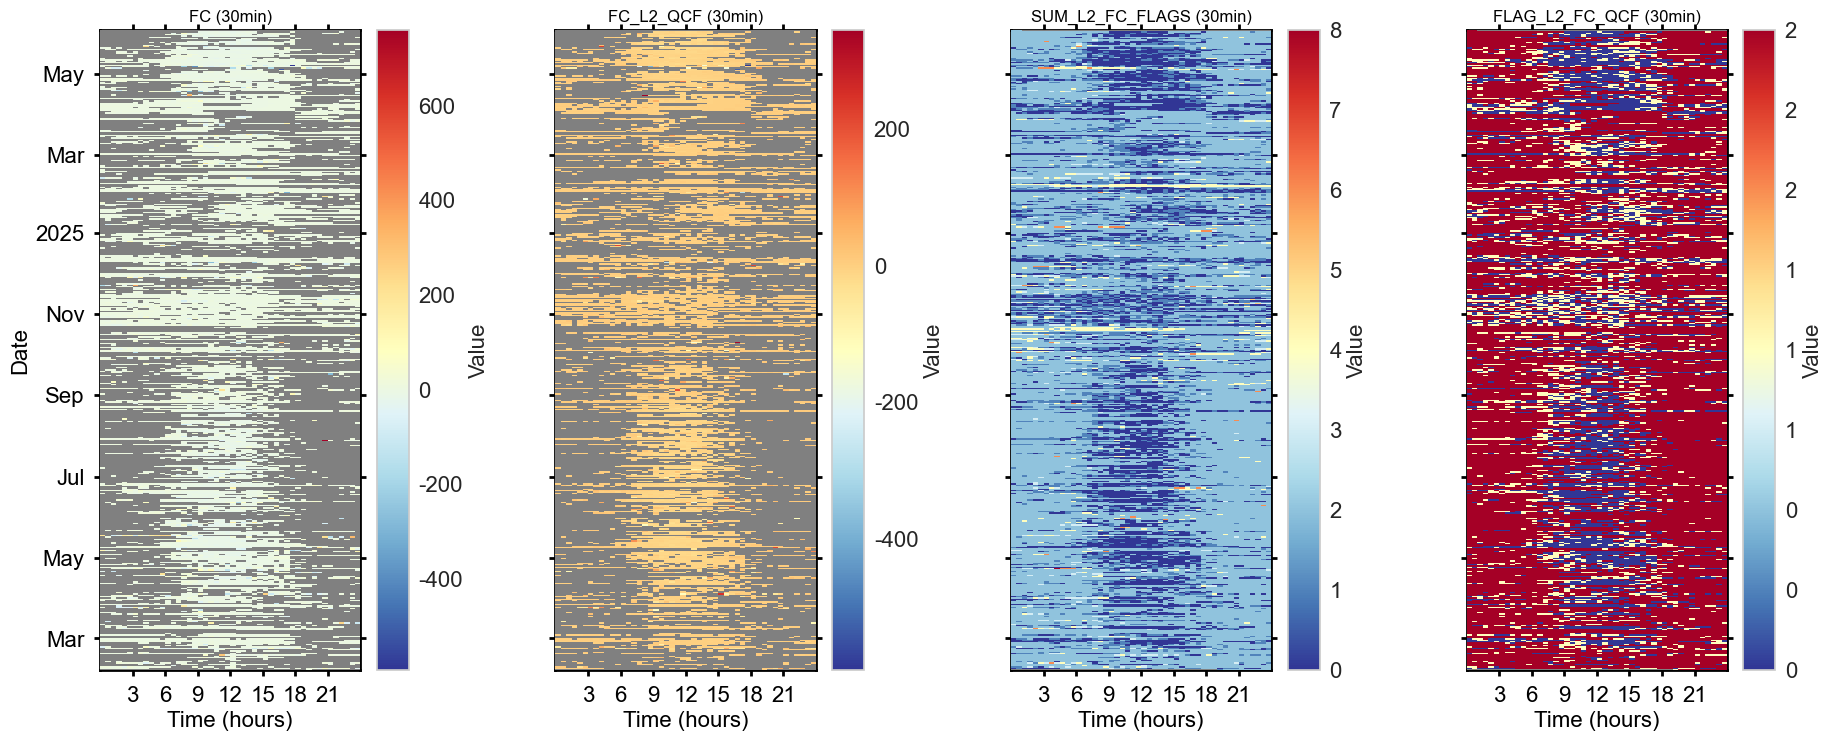

In [31]:
fpc.level2_qcf.showplot_qcf_heatmaps()

In [32]:
# fpc.level2_qcf.showplot_qcf_timeseries()

</br>

### Reports

In [33]:
fpc.level2_qcf.report_qcf_evolution()



QCF FLAG EVOLUTION
This output shows the evolution of the QCF overall quality flag
when test flags are applied sequentially to the variable FC.

Number of FC records before QC: 9378
+++ FLAG_L2_FC_MISSING_TEST rejected 0 values (+0.00%)      TOTALS: flag 0: 9378 (100.00%) / flag 1: 0 (0.00%) / flag 2: 0 (0.00%)
+++ FLAG_L2_FC_SSITC_TEST rejected 1094 values (+11.67%)      TOTALS: flag 0: 4563 (48.66%) / flag 1: 3721 (39.68%) / flag 2: 1094 (11.67%)
+++ FLAG_L2_FC_COMPLETENESS_TEST rejected 32 values (+0.34%)      TOTALS: flag 0: 4550 (48.52%) / flag 1: 3702 (39.48%) / flag 2: 1126 (12.01%)
+++ FLAG_L2_FC_SCF_TEST rejected 4 values (+0.04%)      TOTALS: flag 0: 4542 (48.43%) / flag 1: 3706 (39.52%) / flag 2: 1130 (12.05%)
+++ FLAG_L2_FC_SIGNAL_STRENGTH_TEST rejected 375 values (+4.00%)      TOTALS: flag 0: 4466 (47.62%) / flag 1: 3407 (36.33%) / flag 2: 1505 (16.05%)
+++ FLAG_L2_FC_CO2_VM97_SPIKE_HF_TEST rejected 0 values (+0.00%)      TOTALS: flag 0: 4466 (47.62%) / flag 1: 3407 (36.

In [34]:
fpc.level2_qcf.report_qcf_series()



SUMMARY: FLAG_L2_FC_QCF, QCF FLAG FOR FC
Between 2024-02-06 19:15 and 2025-06-02 00:45 ...
    Total flux records BEFORE quality checks: 9378 (40.60% of potential)
    Available flux records AFTER quality checks: 7868 (83.90% of total)
    Rejected flux records: 1510 (16.10% of total)
    Potential flux records: 23100
    Potential flux records missed: 13722 (59.40% of potential)



In [35]:
# fpc.level2_qcf.report_qcf_flags()

</br>

</br>

---

# Level-3.1: **STORAGE CORRECTION**

---

- The flux storage term (single point) is added to the flux
- For some records, the storage term can be missing. In such cases, missing terms are gap-filled using the rolling mean in an expanding window.
- Without gap-filling the storage term, we can lose an additional e.g. 2-3% of flux data

</br>

## Run

In [36]:
fpc.level31_storage_correction(gapfill_storage_term=True)

Detected storage variable SC_SINGLE for FC.
Calculating storage-corrected flux NEE_L3.1 from flux FC and storage term SC_SINGLE ...
Missing values for storage term SC_SINGLE_gfRMED_L3.1: 228
Gap-filling storage-term SC_SINGLE with rolling median (window size = 5 records, centered)  |  still missing values for storage term SC_SINGLE_gfRMED_L3.1: 217 ...
Gap-filling storage-term SC_SINGLE with rolling median (window size = 7 records, centered)  |  still missing values for storage term SC_SINGLE_gfRMED_L3.1: 122 ...
Gap-filling storage-term SC_SINGLE with rolling median (window size = 9 records, centered)  |  still missing values for storage term SC_SINGLE_gfRMED_L3.1: 105 ...
Gap-filling storage-term SC_SINGLE with rolling median (window size = 11 records, centered)  |  still missing values for storage term SC_SINGLE_gfRMED_L3.1: 86 ...
Gap-filling storage-term SC_SINGLE with rolling median (window size = 13 records, centered)  |  still missing values for storage term SC_SINGLE_gfRMED_L3

</br>

## **Finalize Level-3.1**

In [37]:
fpc.finalize_level31()

++Added new column SC_SINGLE.
++Added new column SC_SINGLE_gfRMED_L3.1.
++Added new column FLAG_SC_SINGLE_gfRMED_L3.1_ISFILLED.
++Added new column NEE_L3.1.
++Added new column NEE_L3.1_QCF (Level-3.1 with applied quality flag from Level-2).
++Added new column NEE_L3.1_QCF0 (Level-3.1 with applied quality flag from Level-2).


</br>

### Available `Level-3.1` variables
- This shows all available Level-3.1 variables for this flux

In [38]:
[x for x in fpc.fpc_df.columns if 'L3.1' in x]

['SC_SINGLE_gfRMED_L3.1',
 'FLAG_SC_SINGLE_gfRMED_L3.1_ISFILLED',
 'NEE_L3.1',
 'NEE_L3.1_QCF',
 'NEE_L3.1_QCF0']

</br>

### Plots

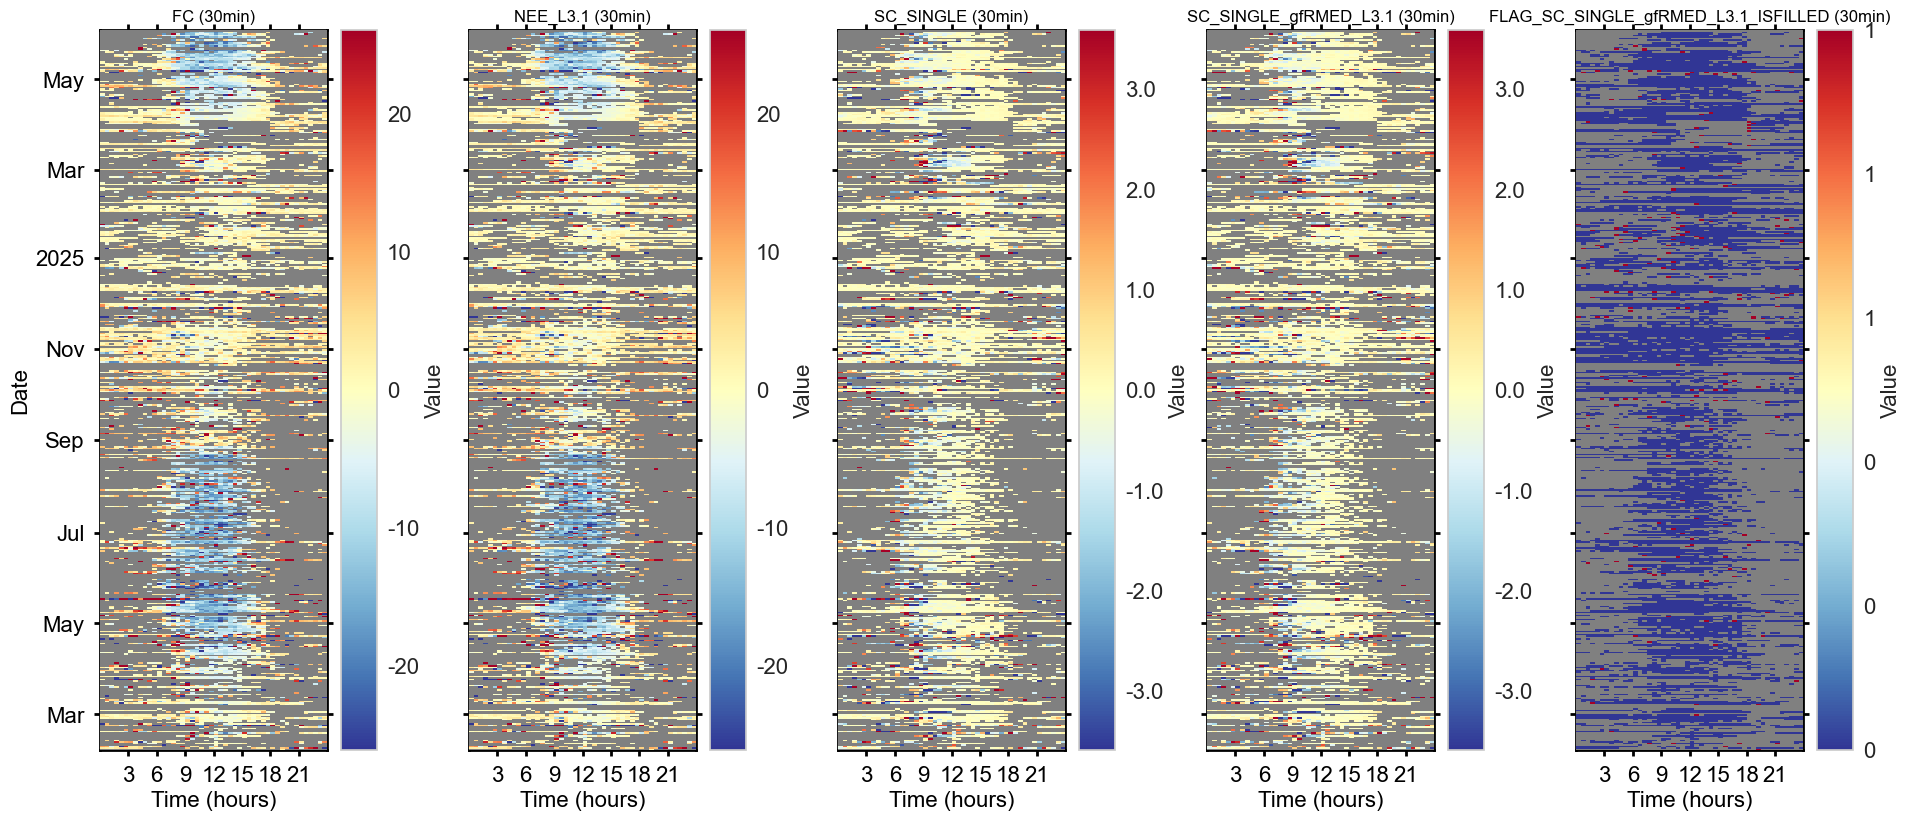

In [39]:
fpc.level31.showplot()

</br>

### Report

In [40]:
fpc.level31.report()


REPORT: STORAGE CORRECTION FOR FC
Swiss FluxNet processing chain, _L3.1: Storage Correction

The gap-filled storage term SC_SINGLE_gfRMED_L3.1 was added to flux FC.
The storage-corrected flux was stored as NEE_L3.1.

The flux was available for 9378 records (FC).
The original, non-gapfilled storage term was available for 9150 records (SC_SINGLE).
The original storage term SC_SINGLE was missing for 228 flux records.
Without gap-filling the storage term (SC_SINGLE), 228 measured flux records (FC) are lost.

For this run, gap-filling of SC_SINGLE was * SELECTED *.
After gap-filling the storage term, it was available for an additional 228 records (SC_SINGLE_gfRMED_L3.1).

In the storage-corrected flux NEE_L3.1 with 9378 records, 
  - 97.6% (9150 records) of used storage terms come from originally calculated data (SC_SINGLE)
  - 2.4% (228 records) of used storage terms come from gap-filled data (SC_SINGLE_gfRMED_L3.1)

Stats for gap-filled storage terms:
                       NOV       P01

</br>

---    

# Optional: **Analyze highest-quality flux** (so far)

---

- Analysis of fluxes after Level-3.1 where the overall quality flag `QCF` = 0
- This helps in understanding in what range the "true" flux occurs
- Here, the highest-quality fluxes are additionally filtered for outlier values using the relatively fast Local Outlier Factor test
- For this quick analysis, it is possible that the outlier test cuts off some "real" values that should be retained, but it nevertheless helps in understanding the flux range
- `QCF` = 0 is best quality, `QCF` = medium quality, `QCF` = 2 bad quality and always rejected
- The difference between quality 0 and quality 1 or 2 is huge


>>> Removing outliers from highest-quality DAYTIME fluxes (NEE_L3.1_QCF0)
>>> Outlier removal method: Local outlier factor across all data (n_neighbors=16, contamination=auto, repeat=False)
[LocalOutlierFactorAllData]  running LocalOutlierFactorAllData ...
ITERATION#1: Total found outliers: 21 values (daytime+nighttime)
>>> Largest non-outlier flux >= 0 DAYTIME:   31.830578000000003
>>> Smallest non-outlier flux >= 0 DAYTIME:  0.0020550000000000013
>>> Largest non-outlier flux < 0 DAYTIME:    -0.003670000000000506
>>> Smallest non-outlier flux < 0 DAYTIME:   -38.463499999999996
>>> Largest outlier flux >= 0 DAYTIME:   79.1301
>>> Smallest outlier flux >= 0 DAYTIME:  33.45415
>>> Largest outlier flux < 0 DAYTIME:    -28.867877
>>> Smallest outlier flux < 0 DAYTIME:   -151.06984

>>> Removing outliers from highest-quality NIGHTTIME fluxes (NEE_L3.1_QCF0)
>>> Outlier removal method: Local outlier factor across all data (n_neighbors=6, contamination=auto, repeat=False)
[LocalOutlierFactor

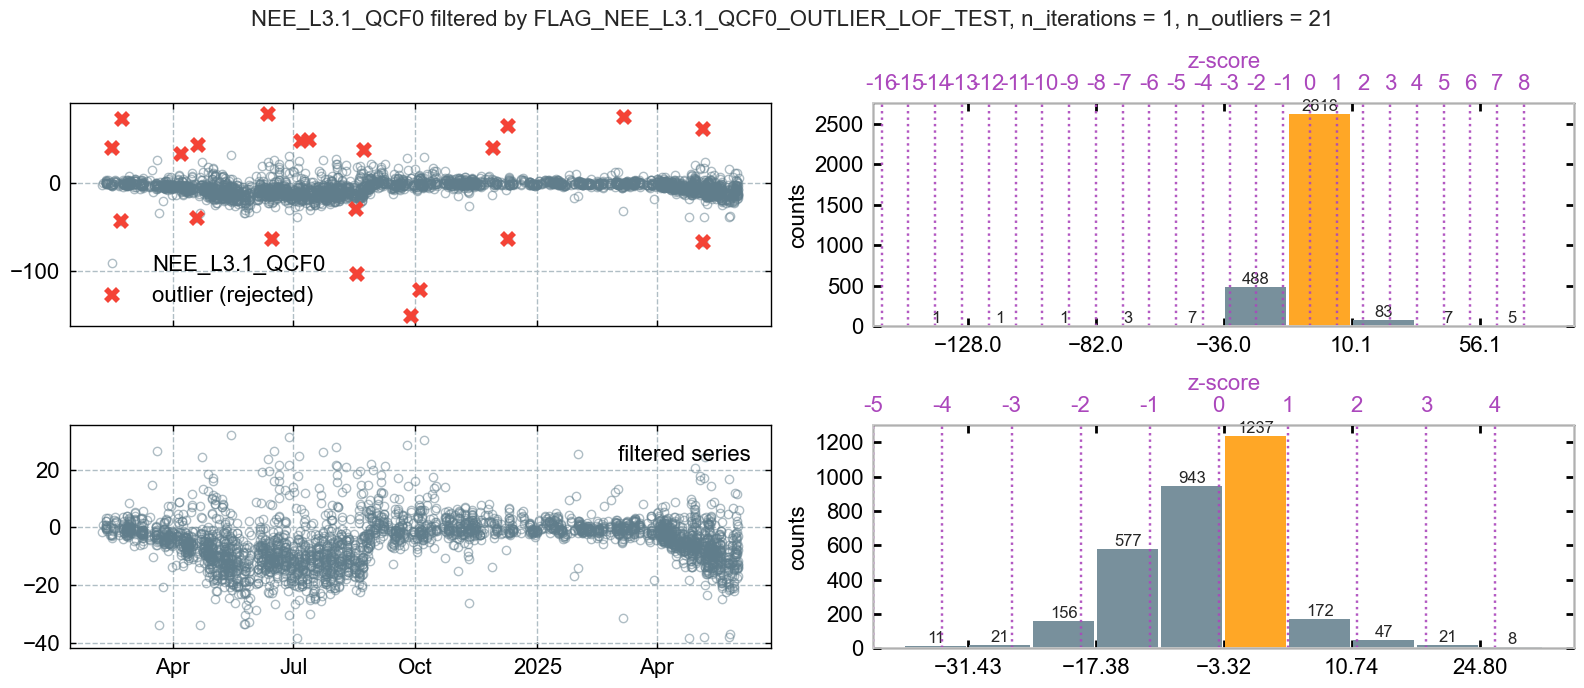

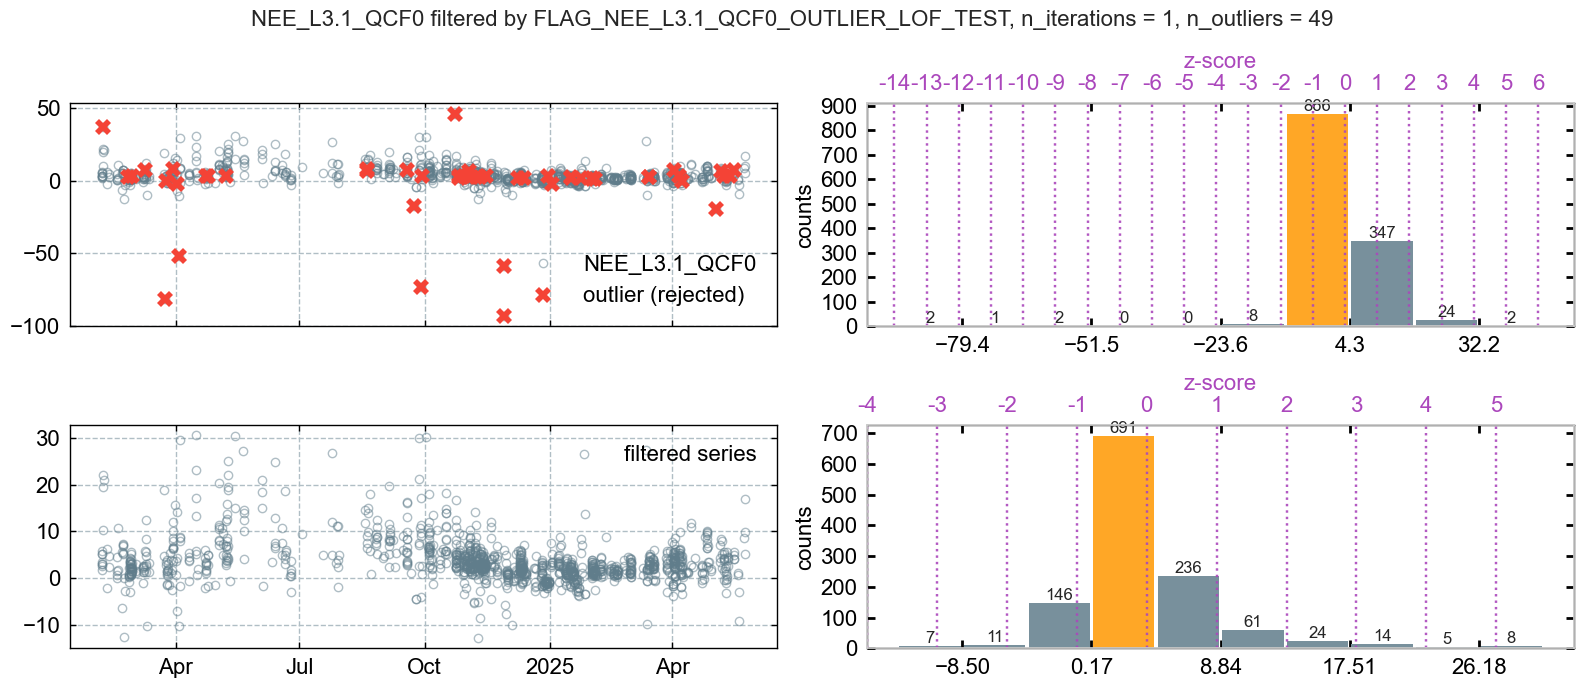

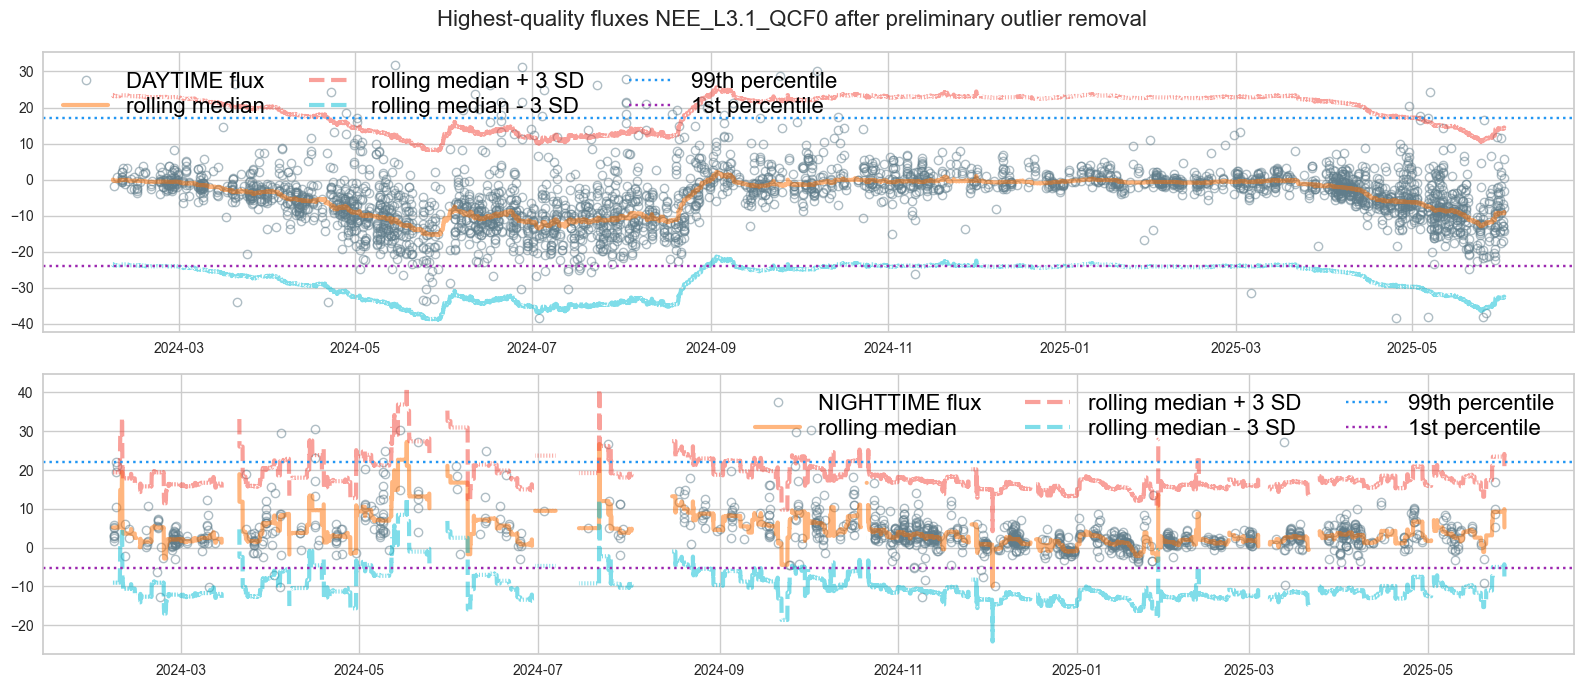

In [41]:
analyze_highest_quality_flux(flux=fpc.fpc_df[fpc.filteredseries_hq.name], nighttime_flag=fpc.fpc_df['NIGHTTIME'])

</br>

</br>

---

# Level-3.2: **OUTLIER DETECTION**

---

- Running an outlier test creates a *preview* plot of the results
- If the output looks as desired, run `fpc.level32_addflag()` cell below the preview to accept the results you see in the plot
- All subsequent tests will then be based on these results
- This means that each test is run on the data already filtered by the previous test
- Each test creates its own quality flag
- At the end of Level-3.2, an overall quality flag `QCF` is created that combines all of the individual flags into one single flag

</br>

## Plot time series

In [42]:
print(f"{fpc.filteredseries.name} \n(quality-controlled Level-3.1 version of {fpc.fluxcol})")

NEE_L3.1_QCF 
(quality-controlled Level-3.1 version of FC)


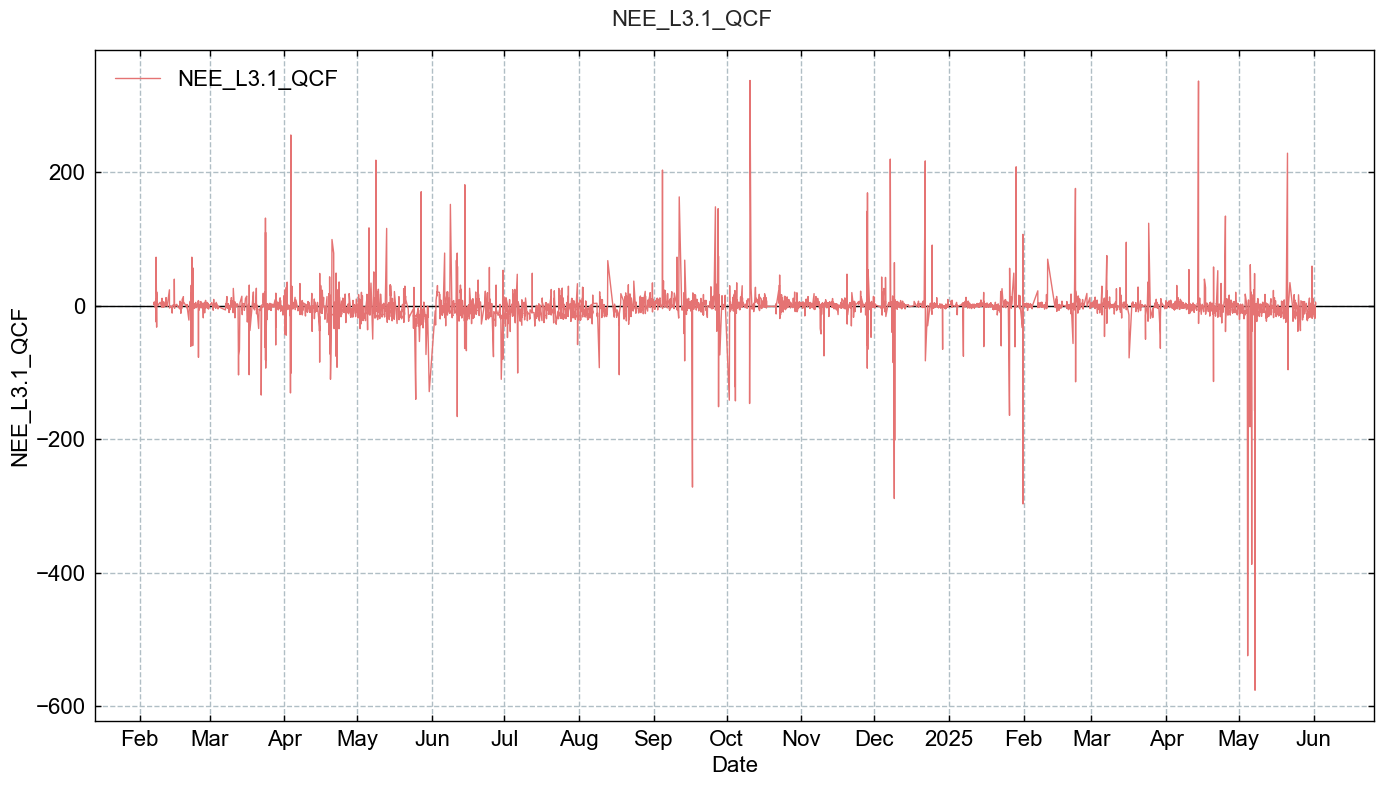

In [43]:
# TimeSeries(series=fpc.fpc_df[fpc.filteredseries.name]).plot_interactive()
TimeSeries(series=fpc.fpc_df[fpc.filteredseries.name]).plot()

</br>

## Initiate calculations

In [44]:
fpc.level32_stepwise_outlier_detection()

</br>

</br>

## Outlier flag: **Absolute limits**
- remove values outside a physically plausible range
- typical value for CO2 flux `FC`: +/-50 µmol m-2 s-1
- typical value for latent evaporation flux `LE`: +800 / -50 W m-2
- typical value for sensible heat flux `H`: +400 / -200 W m-2

In [45]:
# from diive.pkgs.outlierdetection.absolutelimits import AbsoluteLimits
# help(AbsoluteLimits)

[AbsoluteLimits]  running AbsoluteLimits ...


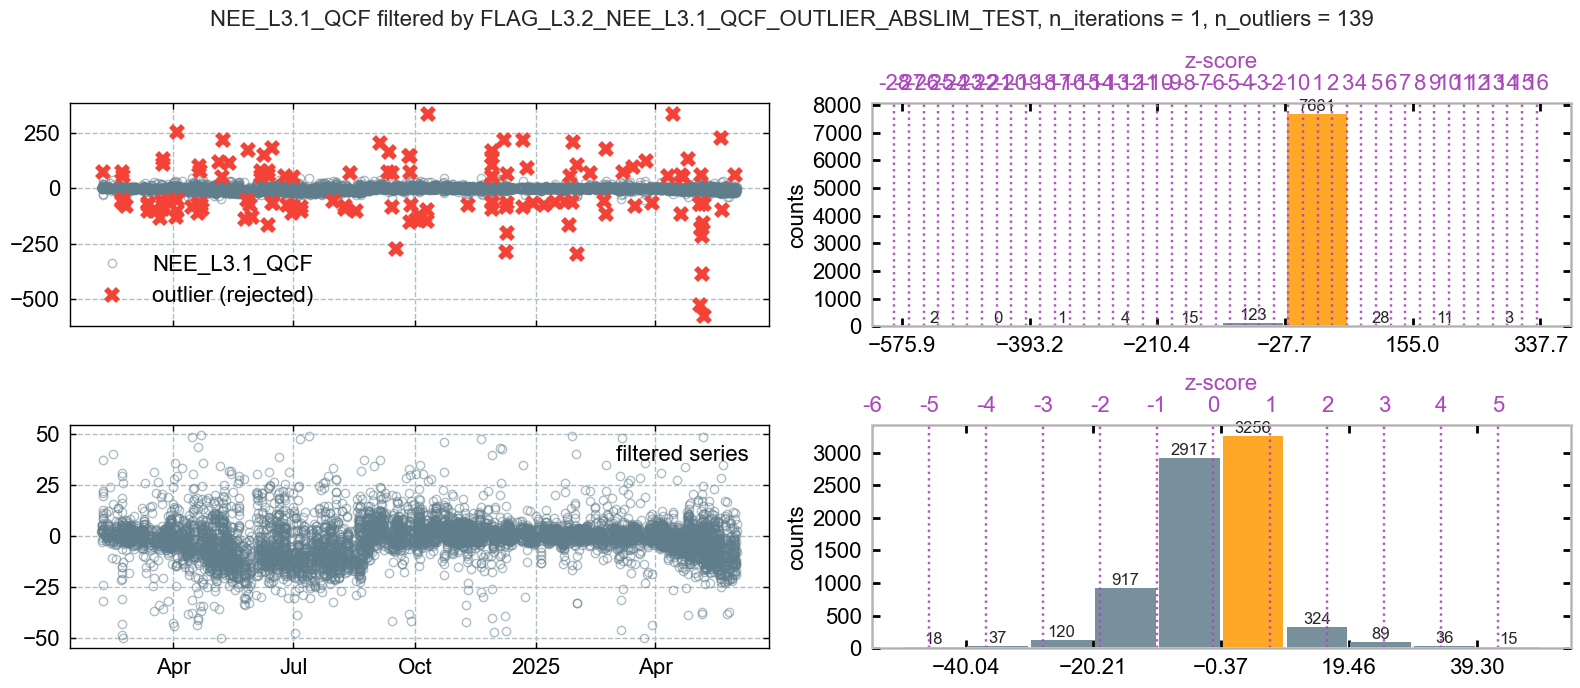

In [46]:
MIN = -50
MAX = 50
fpc.level32_flag_outliers_abslim_test(minval=MIN, maxval=MAX, showplot=True, verbose=True)

In [47]:
fpc.level32_addflag()

++Added flag column FLAG_L3.2_NEE_L3.1_QCF_OUTLIER_ABSLIM_TEST to flag data


</br>

</br>

## Outlier flag: **Manual flag**
- The interactive plot can be used to determine the exact start and end of time ranges or data points that need to be removed, e.g. due to known instrument failure

In [48]:
# from diive.pkgs.outlierdetection.manualremoval import ManualRemoval
# help(ManualRemoval)

In [49]:
# # fpc.level32.showplot_cleaned(interactive=True)  # True or False
# fpc.level32.showplot_cleaned(interactive=False)  # True or False

In [50]:
# REMOVE_DATES = [
#     ['2022-03-18 12:15:00', '2022-04-03 06:45:00'],  # Removes date range between two datetimes (inclusive)
#     # '2023-12-12 12:45:00'  # Removes data point with specific timestamp
# ]
# fpc.level32_flag_manualremoval_test(
#     remove_dates=REMOVE_DATES,
#     showplot=True, verbose=True)

In [51]:
# fpc.level32_addflag()

In [52]:
# fpc.level32.showplot_cleaned(interactive=True)  # True or False

</br>

</br>

## Outlier flag: **Hampel filter**, separate for daytime and nighttime
- Recommended filter
- Is slow compared to other filters:
    - tested with 1 year of 30MIN time resolution data and it needed approx. 43 seconds on a fast desktop computer

In [53]:
# from diive.pkgs.outlierdetection.hampel import Hampel
# help(Hampel)

[HampelDaytimeNighttime]  running HampelDaytimeNighttime ...
ITERATION#1: Total found outliers: 440 (daytime+nighttime), 274 (daytime), 166 (nighttime)
CPU times: total: 6.55 s
Wall time: 6.58 s


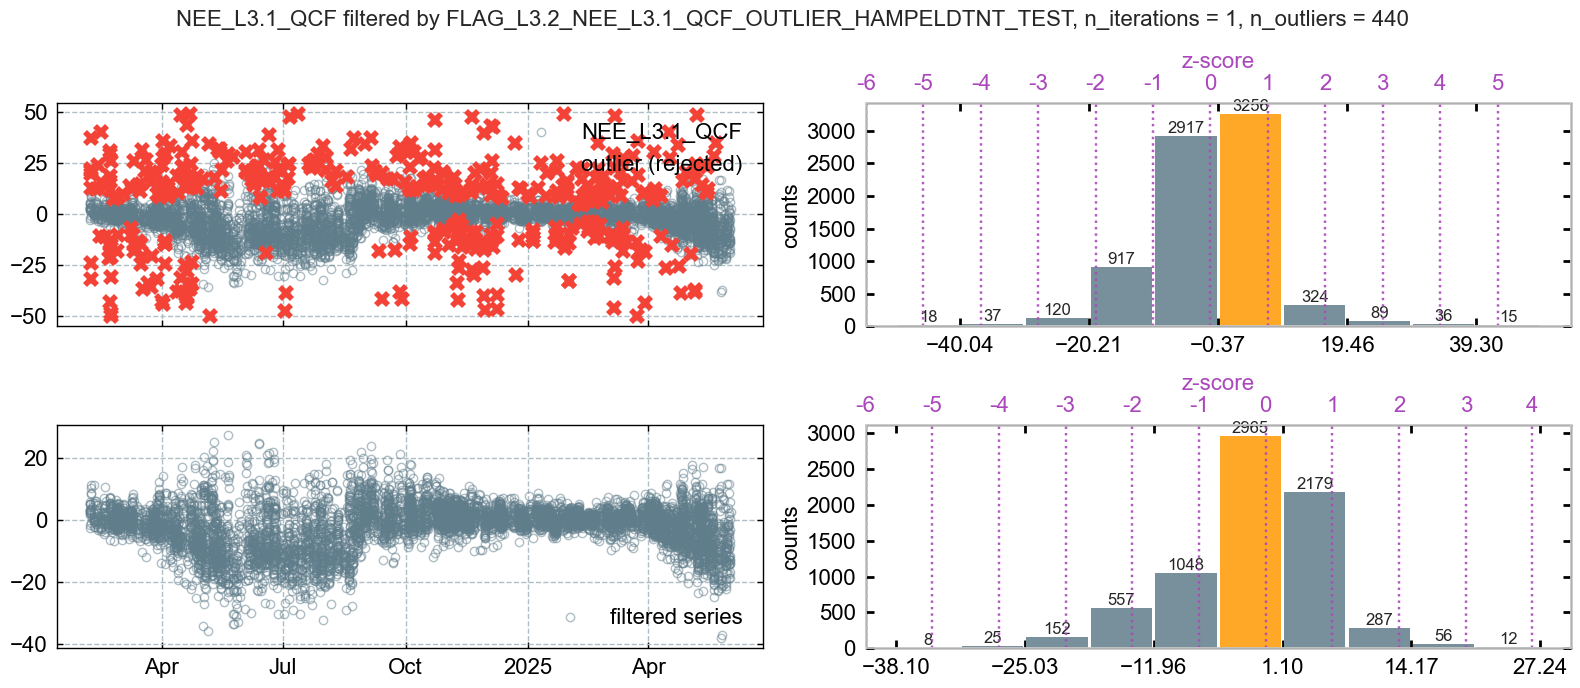

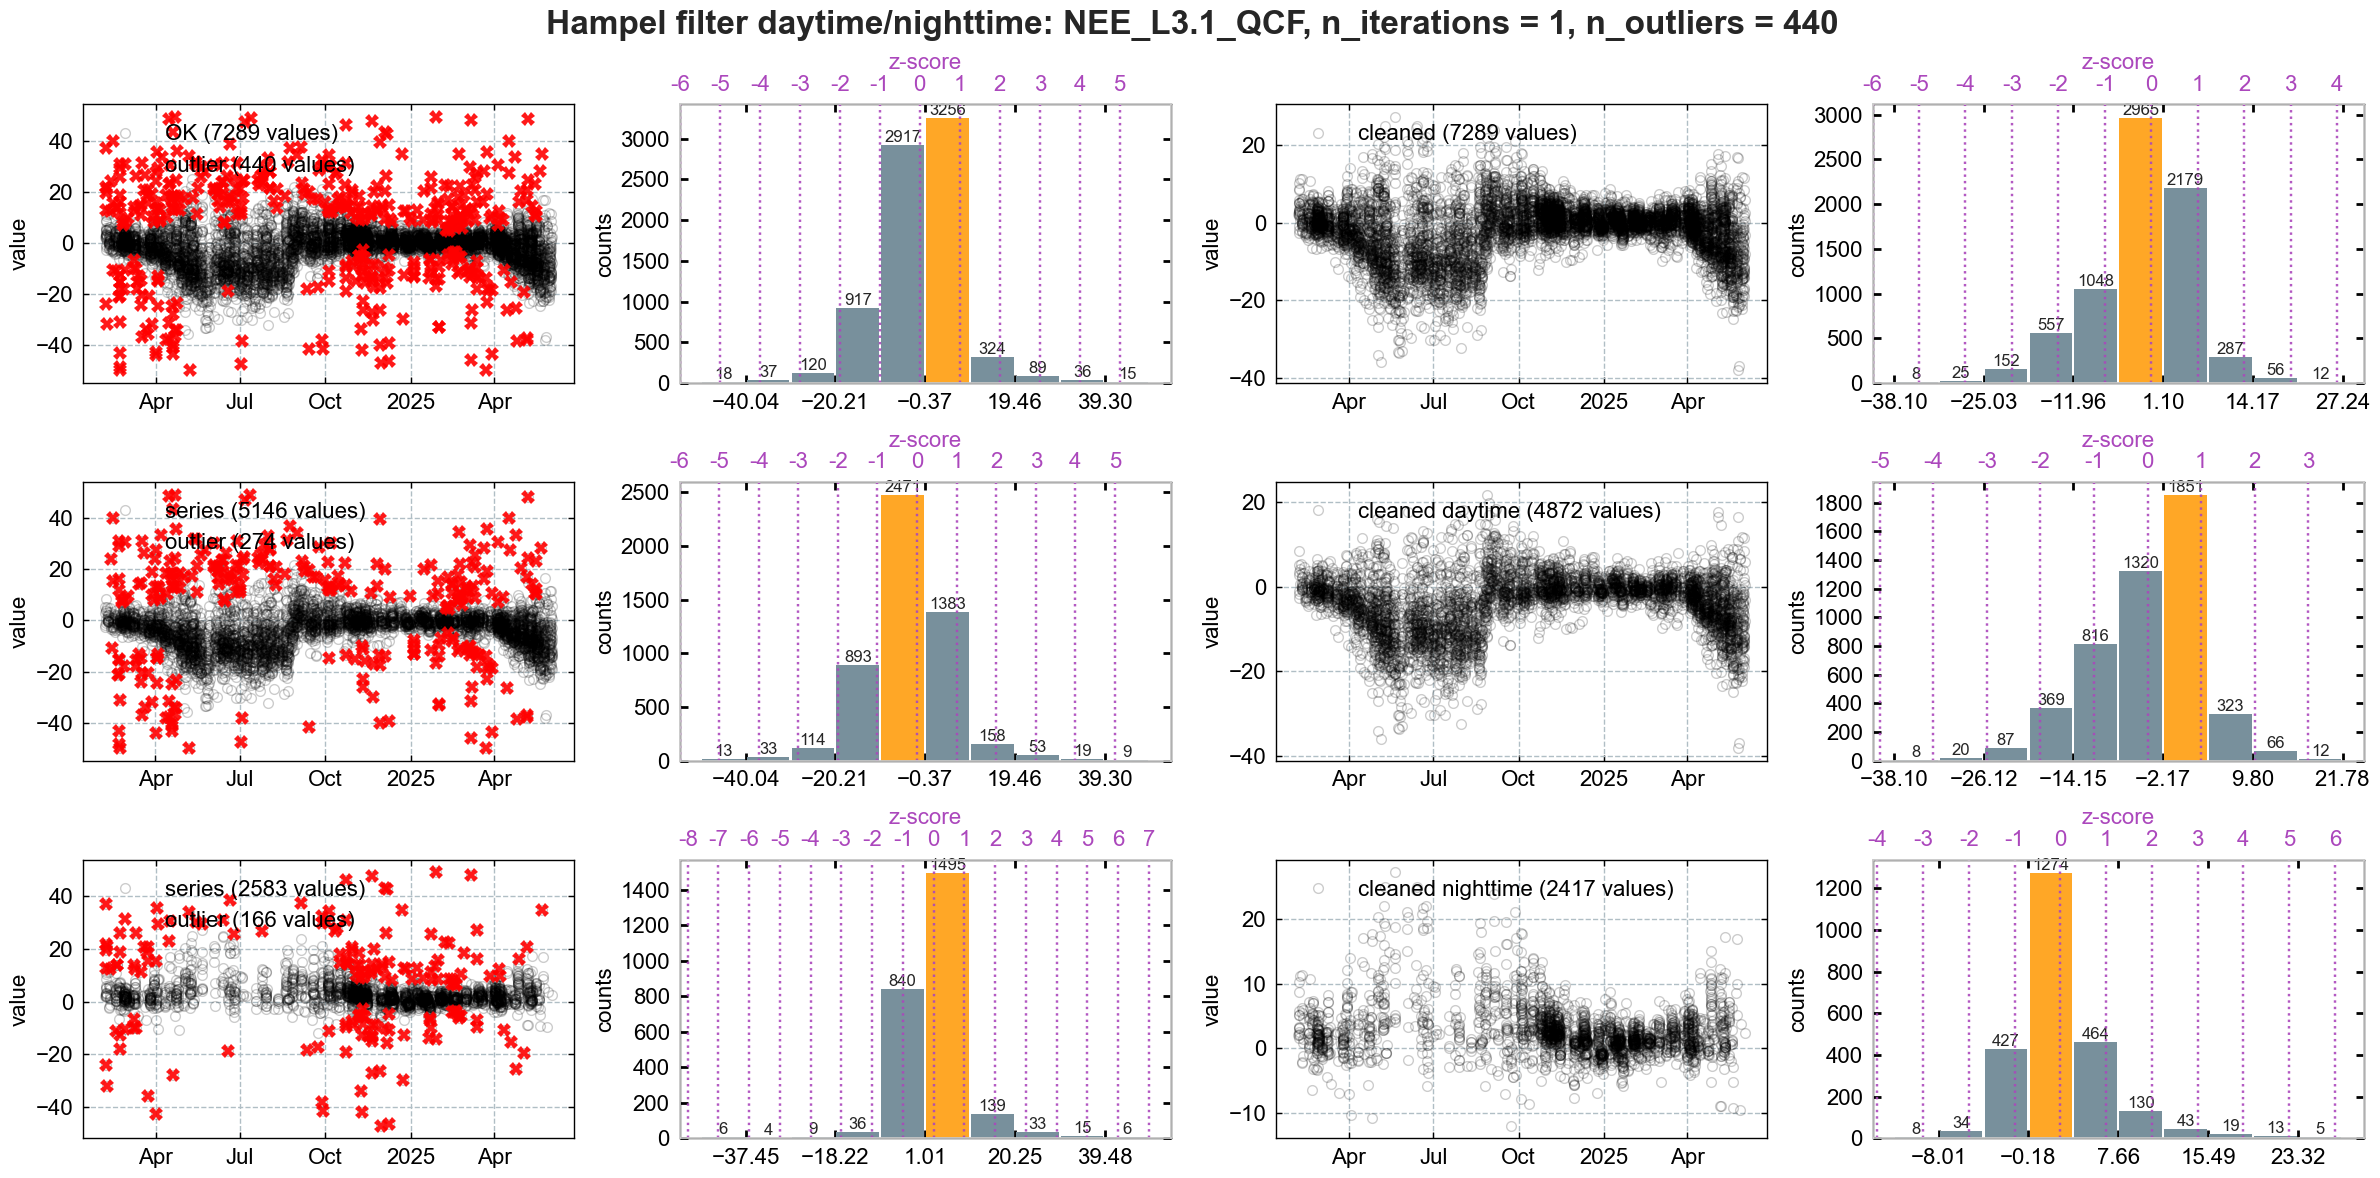

In [54]:
%%time
WINDOW_LENGTH = 48 * 3
N_SIGMA_DT = 3.5
N_SIGMA_NT = 3.5
fpc.level32_flag_outliers_hampel_dtnt_test(window_length=WINDOW_LENGTH, n_sigma_dt=N_SIGMA_DT, n_sigma_nt=N_SIGMA_NT,
                                           showplot=True, verbose=True, repeat=False)

In [55]:
fpc.level32_addflag()

++Added flag column FLAG_L3.2_NEE_L3.1_QCF_OUTLIER_HAMPELDTNT_TEST to flag data


</br>

</br>

## Outlier flag: **z-score across all data**

In [56]:
# from diive.pkgs.outlierdetection.zscore import zScore
# help(zScore)

In [57]:
# THRES_ZSCORE = 6
# fpc.level32_flag_outliers_zscore_test(thres_zscore=THRES_ZSCORE, showplot=True, verbose=True, repeat=True)

In [58]:
# fpc.level32_addflag()

</br>

</br>

## Outlier flag: **Hampel filter**
- Recommended filter
- Is slow compared to other filters:
    - tested with 1 year of 30MIN time resolution data and it needed approx. 33 seconds on a fast desktop computer
    - tested with 19 years of 30MIN time resolution data and it needed approx. 20 minutes on a fast desktop computer

In [59]:
# from diive.pkgs.outlierdetection.hampel import Hampel
# help(Hampel)

In [60]:
# WINDOW_LENGTH = 48 * 13
# N_SIGMA = 6
# %%time
# fpc.level32_flag_outliers_hampel_test(window_length=WINDOW_LENGTH, n_sigma=N_SIGMA, showplot=True, verbose=True, repeat=True)

In [61]:
# fpc.level32_addflag()

</br>

</br>

## Outlier flag: **z-score over all data**, separate for daytime and nighttime

In [62]:
# from diive.pkgs.outlierdetection.zscore import zScoreDaytimeNighttime
# help(zScoreDaytimeNighttime)

In [63]:
# THRES_ZSCORE = 6
# fpc.level32_flag_outliers_zscore_dtnt_test(thres_zscore=THRES_ZSCORE, showplot=True, verbose=True, repeat=True)

In [64]:
# fpc.level32_addflag()

</br>

</br>

## Outlier flag: **Rolling z-score over all data**

In [65]:
# from diive.pkgs.outlierdetection.zscore import zScoreRolling
# help(zScoreRolling)

In [66]:
# THRES_ZSCORE = 5.5
# WINSIZE = 48 * 13
# fpc.level32_flag_outliers_zscore_rolling_test(winsize=WINSIZE, thres_zscore=THRES_ZSCORE, showplot=True, verbose=True, repeat=True)

In [67]:
# fpc.level32_addflag()

</br>

</br>

## Outlier flag: **Local standard deviation**, with rolling median and *rolling* standard deviation

In [68]:
# from diive.pkgs.outlierdetection.localsd import LocalSD
# help(LocalSD)

In [69]:
# N_SD = 4.5
# WINSIZE = 48 * 9
# fpc.level32_flag_outliers_localsd_test(n_sd=N_SD, winsize=WINSIZE, constant_sd=False, showplot=True, verbose=True, repeat=True)

In [70]:
# fpc.level32_addflag()

</br>

</br>

## Outlier flag: **Local standard deviation**, with rolling median and *constant* standard deviation
- keep standard deviation constant by setting parameter `constant_sd=True`

In [71]:
# N_SD = 4.5
# WINSIZE = 48 * 9
# fpc.level32_flag_outliers_localsd_test(n_sd=N_SD, winsize=WINSIZE, constant_sd=True, showplot=True, verbose=True, repeat=True)

In [72]:
# fpc.level32_addflag()

</br>

</br>

## Outlier flag: **Increments z-score**

In [73]:
# from diive.pkgs.outlierdetection.incremental import zScoreIncrements
# help(zScoreIncrements)

In [74]:
# THRES_ZSCORE = 4
# fpc.level32_flag_outliers_increments_zcore_test(thres_zscore=THRES_ZSCORE, showplot=True, verbose=True, repeat=True)

In [75]:
# fpc.level32_addflag()

</br>

</br>

## Outlier flag: **Local outlier factor**, daytime/nighttime
- Test is run separately for daytime and nighttime data
- Description of local outlier factor: [here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html)

In [76]:
# from diive.pkgs.outlierdetection.lof import LocalOutlierFactorDaytimeNighttime
# help(LocalOutlierFactorDaytimeNighttime)

In [77]:
# N_NEIGHBORS = 100
# CONTAMINATION = None
# fpc.level32_flag_outliers_lof_dtnt_test(n_neighbors=N_NEIGHBORS, contamination=CONTAMINATION, showplot=True, verbose=True, repeat=False, n_jobs=-1)

In [78]:
# fpc.level32_addflag()

</br>

</br>

## Outlier flag: **Local outlier factor**
- Test is run across all data
- Description of local outlier factor: [here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html)

In [79]:
# from diive.pkgs.outlierdetection.lof import LocalOutlierFactorAllData
# help(LocalOutlierFactorAllData)

In [80]:
# N_NEIGHBORS = 24
# CONTAMINATION = None
# fpc.level32_flag_outliers_lof_test(n_neighbors=N_NEIGHBORS, contamination=CONTAMINATION, showplot=True, verbose=True, repeat=False, n_jobs=-1)

In [81]:
# fpc.level32_addflag()

</br>

</br>

## Outlier flag: **Absolute limits**, separate for daytime and nighttime data

In [82]:
# from diive.pkgs.outlierdetection.absolutelimits import AbsoluteLimitsDaytimeNighttime
# help(AbsoluteLimitsDaytimeNighttime)

In [83]:
# MIN_DT = -50
# MAX_DT = 50
# MIN_NT = -25
# MAX_NT = 25
# fpc.level32_flag_outliers_abslim_dtnt_test(daytime_minmax=[MIN_DT, MAX_DT], nighttime_minmax=[MIN_NT, MAX_NT], showplot=True, verbose=True)

In [84]:
# fpc.level32_addflag()

</br>

</br>

## Outlier flag: **Trim nighttime flux data**

In [85]:
# from diive.pkgs.outlierdetection.trim import TrimLow
# help(TrimLow)

In [86]:
# fpc.level32_flag_outliers_trim_low_test(trim_nighttime=True, lower_limit=-5, showplot=True, verbose=True)

In [87]:
# fpc.level32_addflag()

</br>

</br>

## **Finalize Level-3.2**: Calculate overall quality flag (so far)

In [88]:
fpc.finalize_level32()

++Added new column FLAG_L3.2_NEE_L3.1_QCF_OUTLIER_ABSLIM_TEST.
++Added new column FLAG_L3.2_NEE_L3.1_QCF_OUTLIER_HAMPELDTNT_TEST.
++Added new column SUM_L3.2_NEE_L3.1_HARDFLAGS.
++Added new column SUM_L3.2_NEE_L3.1_SOFTFLAGS.
++Added new column SUM_L3.2_NEE_L3.1_FLAGS.
++Added new column FLAG_L3.2_NEE_L3.1_QCF.
++Added new column NEE_L3.1_L3.2_QCF.
++Added new column NEE_L3.1_L3.2_QCF0.


</br>

### Available `Level-3.2` variables
- This shows all available Level-3.2 variables for this flux

In [89]:
[x for x in fpc.fpc_df.columns if 'L3.2' in x]

['FLAG_L3.2_NEE_L3.1_QCF_OUTLIER_ABSLIM_TEST',
 'FLAG_L3.2_NEE_L3.1_QCF_OUTLIER_HAMPELDTNT_TEST',
 'SUM_L3.2_NEE_L3.1_HARDFLAGS',
 'SUM_L3.2_NEE_L3.1_SOFTFLAGS',
 'SUM_L3.2_NEE_L3.1_FLAGS',
 'FLAG_L3.2_NEE_L3.1_QCF',
 'NEE_L3.1_L3.2_QCF',
 'NEE_L3.1_L3.2_QCF0']

</br>

### Plot filtered flux after Level-3.2
In the four panels, from left to right:
- flux after Level-3.1, before outlier removal
- flux after Level-3.2, after outlier removal
- sum of the individual test flags
- overall flag `QCF` (quality control flag), where `0`=best quality, `1`=medium quality, `2`=bad quality  

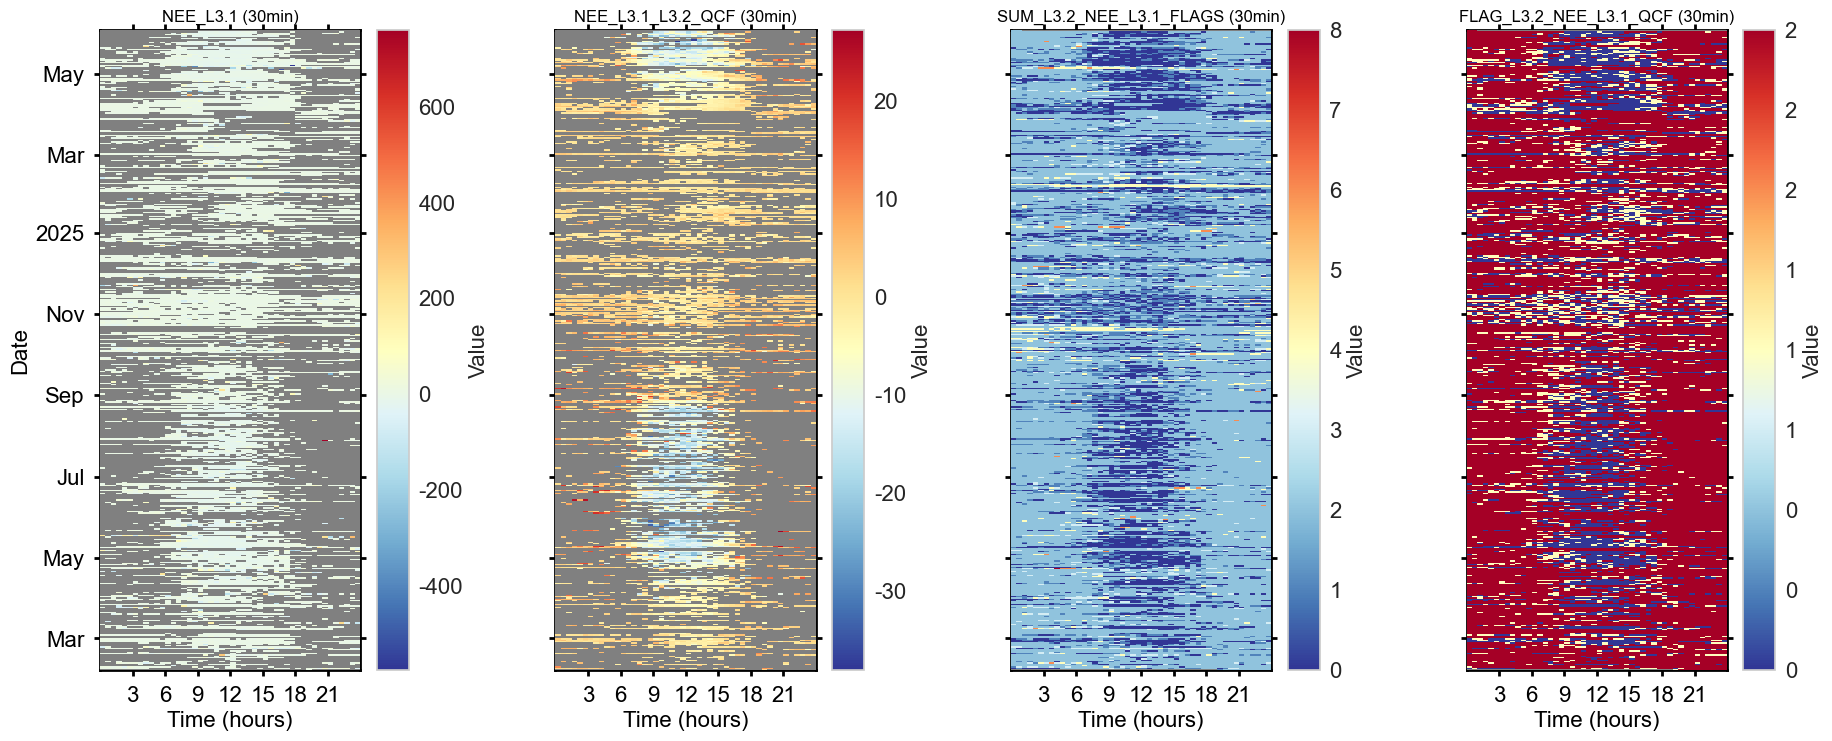

In [90]:
fpc.level32_qcf.showplot_qcf_heatmaps()

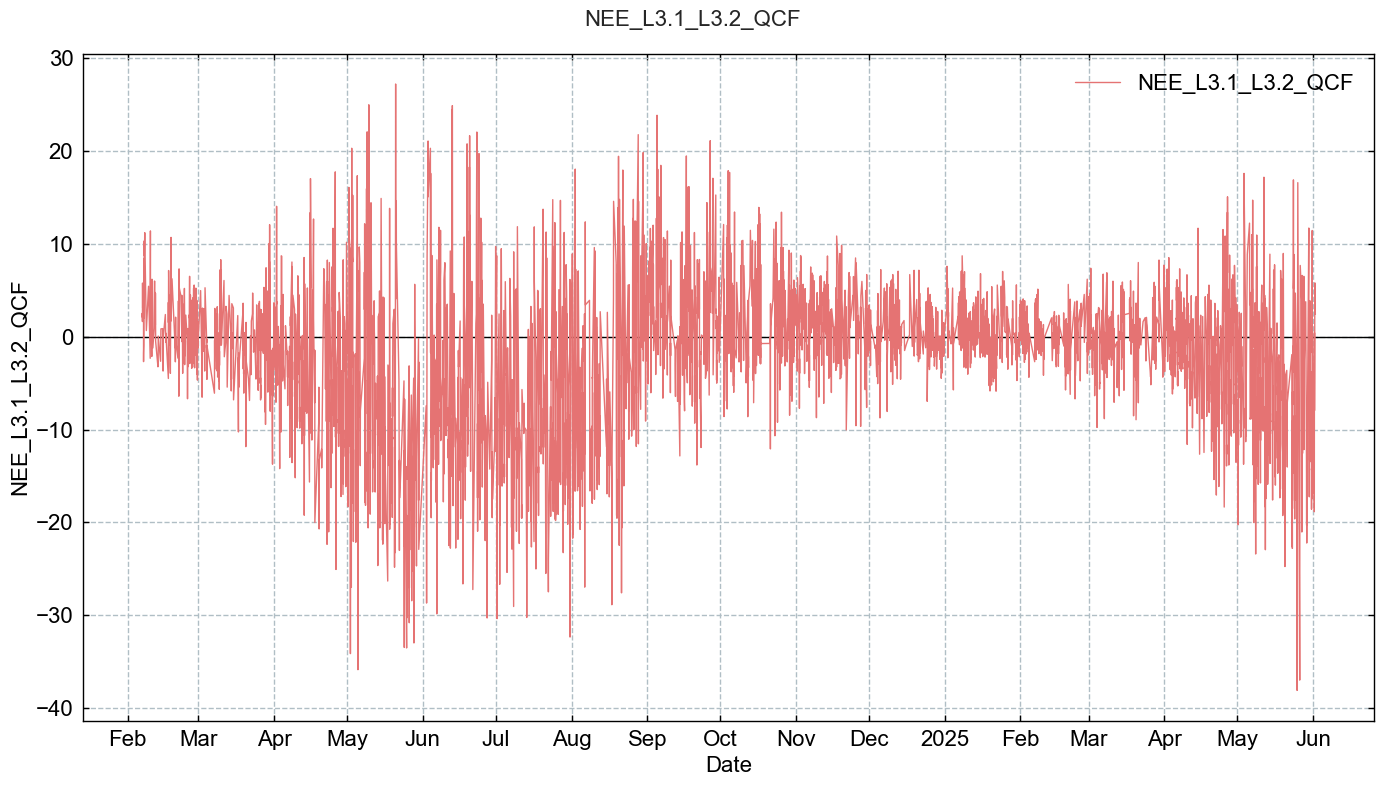

In [91]:
TimeSeries(series=fpc.filteredseries).plot()
# TimeSeries(series=fpc.filteredseries).plot_interactive()

In [92]:
# fpc.level32_qcf.showplot_qcf_timeseries()

</br>

### Reports

In [93]:
fpc.level32_qcf.report_qcf_evolution()



QCF FLAG EVOLUTION
This output shows the evolution of the QCF overall quality flag
when test flags are applied sequentially to the variable NEE_L3.1.

Number of NEE_L3.1 records before QC: 9378
+++ FLAG_L2_FC_MISSING_TEST rejected 0 values (+0.00%)      TOTALS: flag 0: 9378 (100.00%) / flag 1: 0 (0.00%) / flag 2: 0 (0.00%)
+++ FLAG_L2_FC_SSITC_TEST rejected 1094 values (+11.67%)      TOTALS: flag 0: 4563 (48.66%) / flag 1: 3721 (39.68%) / flag 2: 1094 (11.67%)
+++ FLAG_L2_FC_COMPLETENESS_TEST rejected 32 values (+0.34%)      TOTALS: flag 0: 4550 (48.52%) / flag 1: 3702 (39.48%) / flag 2: 1126 (12.01%)
+++ FLAG_L2_FC_SCF_TEST rejected 4 values (+0.04%)      TOTALS: flag 0: 4542 (48.43%) / flag 1: 3706 (39.52%) / flag 2: 1130 (12.05%)
+++ FLAG_L2_FC_SIGNAL_STRENGTH_TEST rejected 375 values (+4.00%)      TOTALS: flag 0: 4466 (47.62%) / flag 1: 3407 (36.33%) / flag 2: 1505 (16.05%)
+++ FLAG_L2_FC_CO2_VM97_SPIKE_HF_TEST rejected 0 values (+0.00%)      TOTALS: flag 0: 4466 (47.62%) / flag 

In [94]:
fpc.level32_qcf.report_qcf_series()



SUMMARY: FLAG_L3.2_NEE_L3.1_QCF, QCF FLAG FOR NEE_L3.1
Between 2024-02-06 19:15 and 2025-06-02 00:45 ...
    Total flux records BEFORE quality checks: 9378 (40.60% of potential)
    Available flux records AFTER quality checks: 7289 (77.72% of total)
    Rejected flux records: 2089 (22.28% of total)
    Potential flux records: 23100
    Potential flux records missed: 13722 (59.40% of potential)



In [95]:
fpc.level32_qcf.report_qcf_flags()


REPORT: FLAGS INCL. MISSING VALUES
Stats with missing values in the dataset
FLAG_L2_FC_MISSING_TEST:
    OVERALL flag 0.0: 9378 values (40.60%)  
    OVERALL flag 2.0: 13722 values (59.40%)  
    OVERALL flag missing: 0 values (0.00%)  

    DAYTIME flag 0.0: 6065 values (52.69%)  
    DAYTIME flag 2.0: 5445 values (47.31%)  
    DAYTIME flag missing: 0 values (0.00%)  

    NIGHTTIME flag 0.0: 3313 values (28.58%)  
    NIGHTTIME flag 2.0: 8277 values (71.42%)  
    NIGHTTIME flag missing: 0 values (0.00%)  

FLAG_L2_FC_SSITC_TEST:
    OVERALL flag 0.0: 4563 values (19.75%)  
    OVERALL flag 1.0: 3721 values (16.11%)  
    OVERALL flag 2.0: 1094 values (4.74%)  
    OVERALL flag missing: 13722 values (59.40%)  

    DAYTIME flag 0.0: 3259 values (28.31%)  
    DAYTIME flag 1.0: 2208 values (19.18%)  
    DAYTIME flag 2.0: 598 values (5.20%)  
    DAYTIME flag missing: 5445 values (47.31%)  

    NIGHTTIME flag 0.0: 1304 values (11.25%)  
    NIGHTTIME flag 1.0: 1513 values (13.05%) 

</br>

## Save Level-3.2 results to file
- If needed, save results so far (input data and all created variables, e.g. flags and filtered fluxes) to a file
- This can be useful if e.g. USTAR filtering is not needed and gap-filling is done elsewhere (ReddyProc...)

In [96]:
# results_df = fpc.get_data()
# filename = "51.1_FluxProcessingChain_after-L3.3_NEE"
# results_df.to_csv(f"{filename}.csv", index=True)
# save_parquet(data=results_df, filename=filename)

</br>

</br>

---

# Level-3.3: **USTAR FILTERING**

---

- Daytime and nighttime data are filtered based on USTAR thresholds
- Example USTAR thresholds from the analysis done by FLUXNET (2005-2023) for the intensively managed grassland [CH-CHA, Chamau](https://www.swissfluxnet.ethz.ch/index.php/sites/site-info-ch-cha/):
    - CUT_16: `0.0529445`
    - CUT_50: `0.0698982`
    - CUT_84: `0.0928408`

<div class="alert alert-block alert-danger">
    No USTAR filtering for: <b>H, LE, ET and FH2O.</b> 
</div>

> The USTAR filtering is not applied to H and LE, because it has not been proved that when there are CO2 advective fluxes, these also impact energy fluxes, specifically due to the fact that when advection is in general large (nighttime), energy fluxes are small.

source: [Pastorello et al. (2020). The FLUXNET2015 dataset and the ONEFlux processing pipeline for eddy covariance data](https://doi.org/10.1038/s41597-020-0534-3)



## **Apply constant thresholds**

In [97]:
USTAR_SCENARIOS = ['CUT1', 'CUT2', 'CUT3']
USTAR_THRESHOLDS = [0.07, 0.1, 0.13]
# USTAR_SCENARIOS = ['CUT0.07', 'CUT0.1', 'CUT0.13']
# USTAR_THRESHOLDS = [0.07, 0.1, 0.13]
# USTAR_SCENARIOS = ['CUT_16', 'CUT_50', 'CUT_84']
# USTAR_THRESHOLDS = [0.0529445, 0.0698982, 0.0928408]
fpc.level33_constant_ustar(thresholds=USTAR_THRESHOLDS,
                           threshold_labels=USTAR_SCENARIOS,
                           showplot=False)

[FlagSingleConstantUstarThreshold]  running FlagSingleConstantUstarThreshold ...
Total found outliers for USTAR threshold _L3.3_CUT1 0.07: 1182 values
[FlagSingleConstantUstarThreshold]  running FlagSingleConstantUstarThreshold ...
Total found outliers for USTAR threshold _L3.3_CUT2 0.1: 2319 values
[FlagSingleConstantUstarThreshold]  running FlagSingleConstantUstarThreshold ...
Total found outliers for USTAR threshold _L3.3_CUT3 0.13: 3533 values


</br>

## **Finalize Level-3.3**: Caculate overall final quality flag

In [98]:
# Finalize: stores results for each USTAR scenario in a dict
fpc.finalize_level33()

Calculating overall quality flag QCF for USTAR scenario CUT1...
++Added new column FLAG_L3.3_CUT1_NEE_L3.1_USTAR_TEST.
++Added new column SUM_L3.3_CUT1_NEE_L3.1_HARDFLAGS.
++Added new column SUM_L3.3_CUT1_NEE_L3.1_SOFTFLAGS.
++Added new column SUM_L3.3_CUT1_NEE_L3.1_FLAGS.
++Added new column FLAG_L3.3_CUT1_NEE_L3.1_QCF.
++Added new column NEE_L3.1_L3.3_CUT1_QCF.
++Added new column NEE_L3.1_L3.3_CUT1_QCF0.
Calculating overall quality flag QCF for USTAR scenario CUT2...
++Added new column FLAG_L3.3_CUT2_NEE_L3.1_USTAR_TEST.
++Added new column SUM_L3.3_CUT2_NEE_L3.1_HARDFLAGS.
++Added new column SUM_L3.3_CUT2_NEE_L3.1_SOFTFLAGS.
++Added new column SUM_L3.3_CUT2_NEE_L3.1_FLAGS.
++Added new column FLAG_L3.3_CUT2_NEE_L3.1_QCF.
++Added new column NEE_L3.1_L3.3_CUT2_QCF.
++Added new column NEE_L3.1_L3.3_CUT2_QCF0.
Calculating overall quality flag QCF for USTAR scenario CUT3...
++Added new column FLAG_L3.3_CUT3_NEE_L3.1_USTAR_TEST.
++Added new column SUM_L3.3_CUT3_NEE_L3.1_HARDFLAGS.
++Added ne

</br>

### Available `Level-3.3` variables
- This shows all available Level-3.3 variables for this flux

In [99]:
[x for x in fpc.fpc_df.columns if 'L3.3' in x]

['FLAG_L3.3_CUT1_NEE_L3.1_USTAR_TEST',
 'SUM_L3.3_CUT1_NEE_L3.1_HARDFLAGS',
 'SUM_L3.3_CUT1_NEE_L3.1_SOFTFLAGS',
 'SUM_L3.3_CUT1_NEE_L3.1_FLAGS',
 'FLAG_L3.3_CUT1_NEE_L3.1_QCF',
 'NEE_L3.1_L3.3_CUT1_QCF',
 'NEE_L3.1_L3.3_CUT1_QCF0',
 'FLAG_L3.3_CUT2_NEE_L3.1_USTAR_TEST',
 'SUM_L3.3_CUT2_NEE_L3.1_HARDFLAGS',
 'SUM_L3.3_CUT2_NEE_L3.1_SOFTFLAGS',
 'SUM_L3.3_CUT2_NEE_L3.1_FLAGS',
 'FLAG_L3.3_CUT2_NEE_L3.1_QCF',
 'NEE_L3.1_L3.3_CUT2_QCF',
 'NEE_L3.1_L3.3_CUT2_QCF0',
 'FLAG_L3.3_CUT3_NEE_L3.1_USTAR_TEST',
 'SUM_L3.3_CUT3_NEE_L3.1_HARDFLAGS',
 'SUM_L3.3_CUT3_NEE_L3.1_SOFTFLAGS',
 'SUM_L3.3_CUT3_NEE_L3.1_FLAGS',
 'FLAG_L3.3_CUT3_NEE_L3.1_QCF',
 'NEE_L3.1_L3.3_CUT3_QCF',
 'NEE_L3.1_L3.3_CUT3_QCF0']

</br>

### Plot filtered flux after Level-3.3
In the four panels, from left to right:
- flux after Level-3.1, before outlier removal and USTAR filtering
- flux after Level-3.3, after outlier removal and USTAR filtering
- sum of the individual test flags
- overall flag `QCF` (quality control flag), where `0`=best quality, `1`=medium quality, `2`=bad quality  

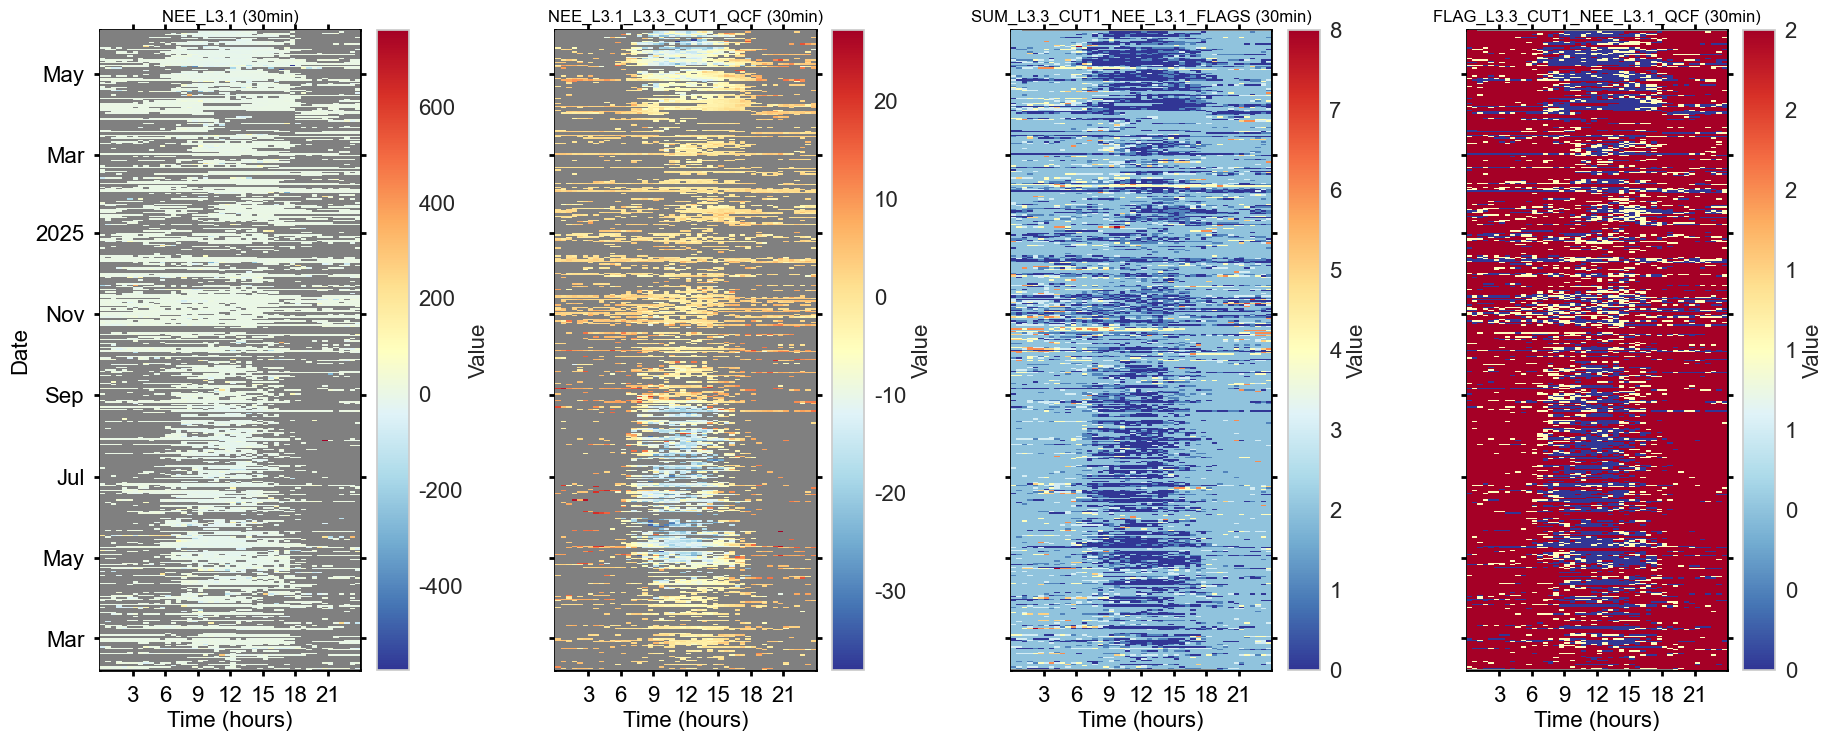

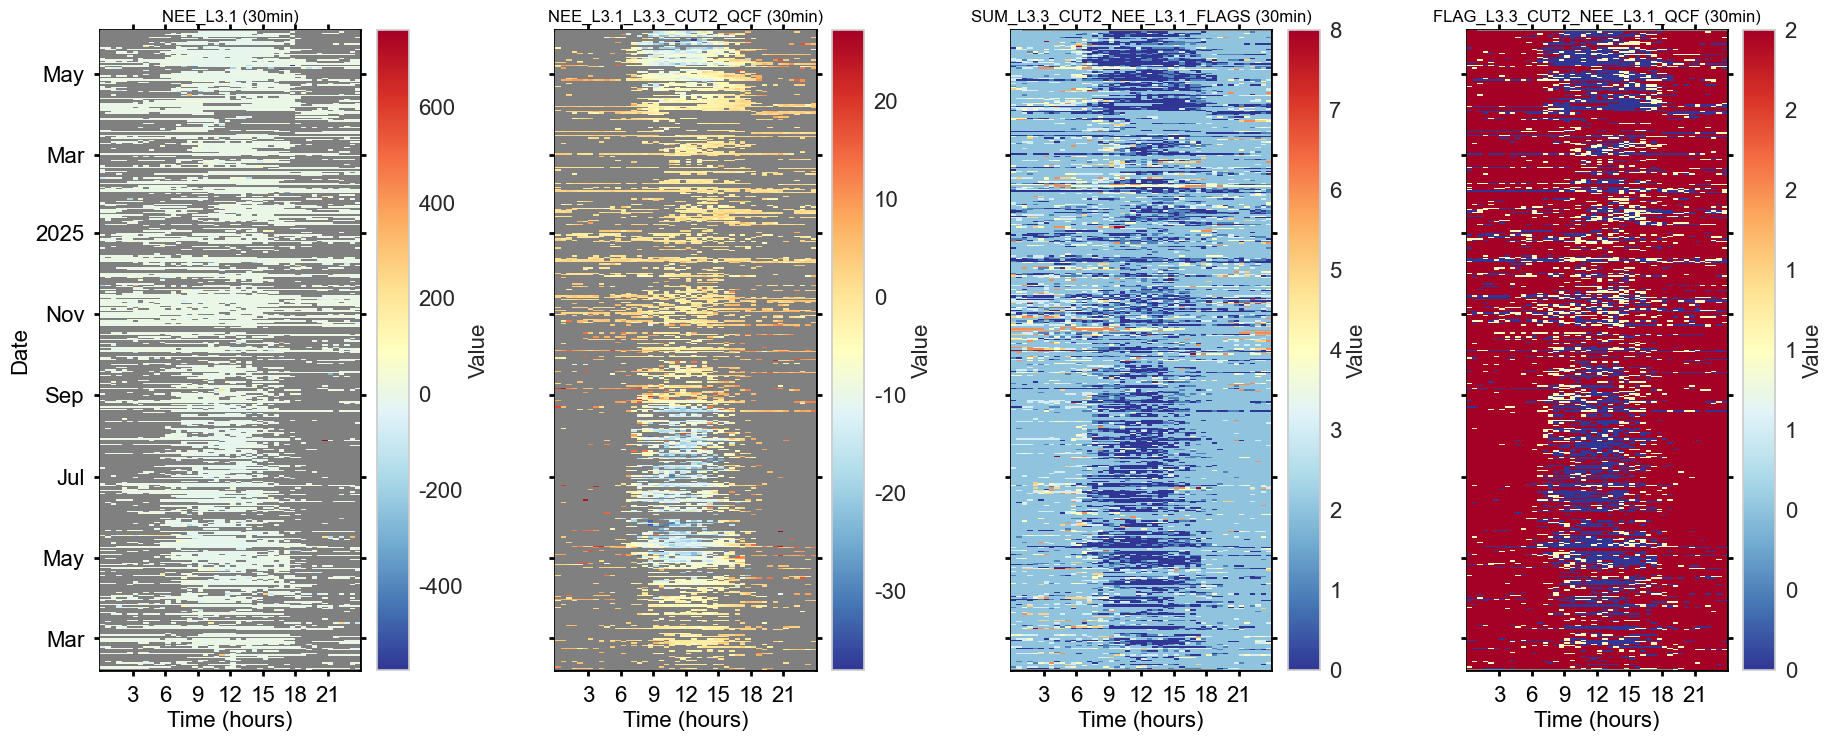

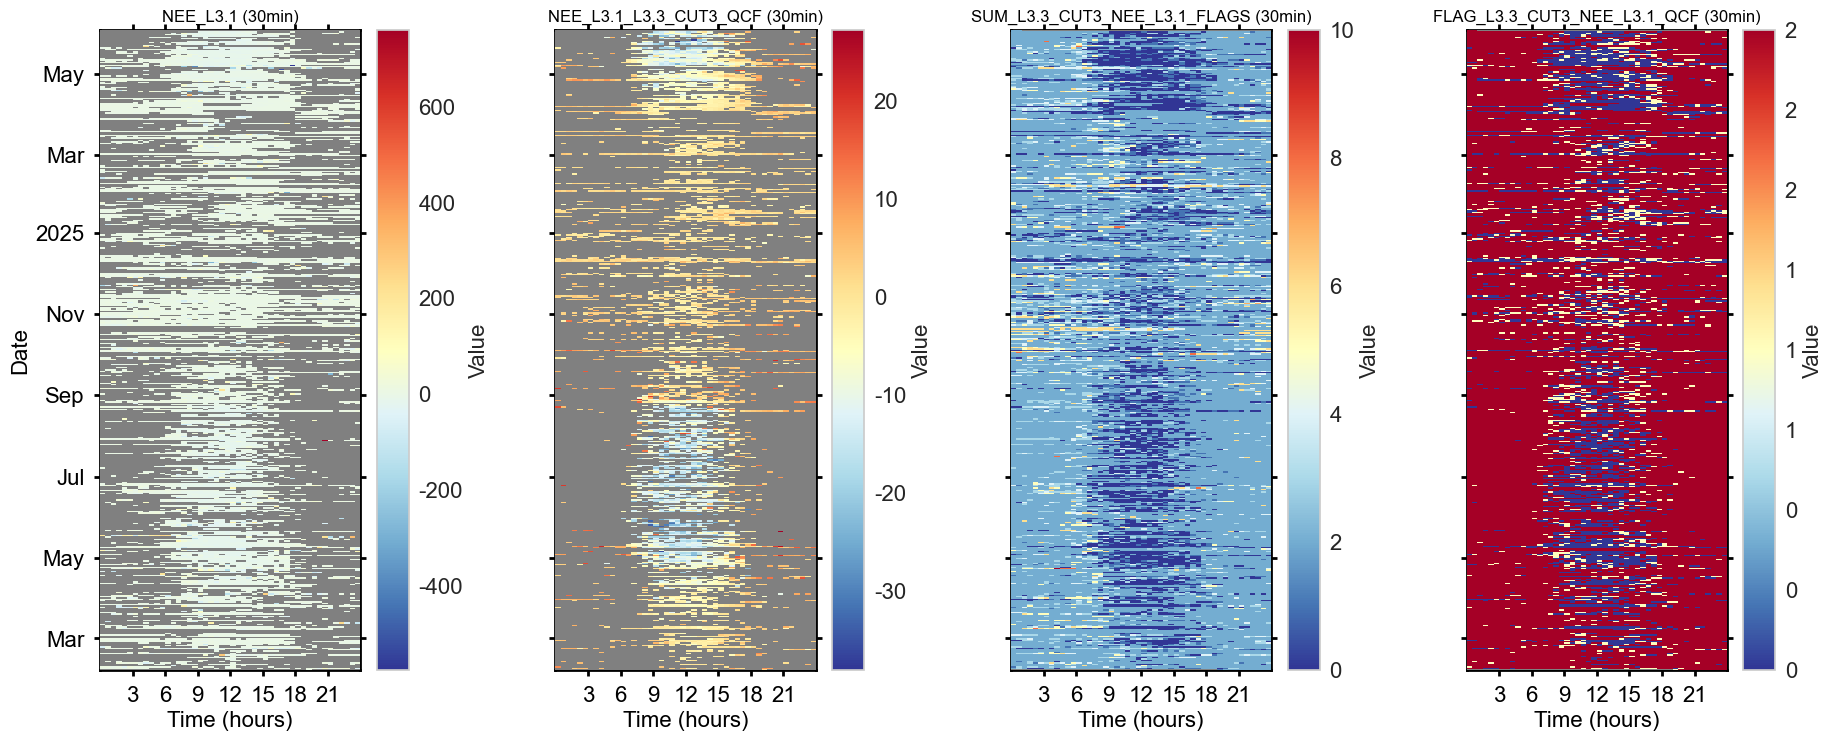

In [100]:
for key, value in fpc.level33_qcf.items():
    # TimeSeries(series=fpc.fpc_df[fluxhq]).plot_interactive()
    # TimeSeries(series=fpc.fpc_df[FLUXVAR33QCF[key].name]).plot()
    fpc.level33_qcf[key].showplot_qcf_heatmaps()

</br>

### Reports

In [101]:
for key, value in fpc.level33_qcf.items():
    fpc.level33_qcf[key].report_qcf_evolution()



QCF FLAG EVOLUTION
This output shows the evolution of the QCF overall quality flag
when test flags are applied sequentially to the variable NEE_L3.1.

Number of NEE_L3.1 records before QC: 9378
+++ FLAG_L2_FC_MISSING_TEST rejected 0 values (+0.00%)      TOTALS: flag 0: 9378 (100.00%) / flag 1: 0 (0.00%) / flag 2: 0 (0.00%)
+++ FLAG_L2_FC_SSITC_TEST rejected 1094 values (+11.67%)      TOTALS: flag 0: 4563 (48.66%) / flag 1: 3721 (39.68%) / flag 2: 1094 (11.67%)
+++ FLAG_L2_FC_COMPLETENESS_TEST rejected 32 values (+0.34%)      TOTALS: flag 0: 4550 (48.52%) / flag 1: 3702 (39.48%) / flag 2: 1126 (12.01%)
+++ FLAG_L2_FC_SCF_TEST rejected 4 values (+0.04%)      TOTALS: flag 0: 4542 (48.43%) / flag 1: 3706 (39.52%) / flag 2: 1130 (12.05%)
+++ FLAG_L2_FC_SIGNAL_STRENGTH_TEST rejected 375 values (+4.00%)      TOTALS: flag 0: 4466 (47.62%) / flag 1: 3407 (36.33%) / flag 2: 1505 (16.05%)
+++ FLAG_L2_FC_CO2_VM97_SPIKE_HF_TEST rejected 0 values (+0.00%)      TOTALS: flag 0: 4466 (47.62%) / flag 

In [102]:
for key, value in fpc.level33_qcf.items():
    fpc.level33_qcf[key].report_qcf_series()



SUMMARY: FLAG_L3.3_CUT1_NEE_L3.1_QCF, QCF FLAG FOR NEE_L3.1
Between 2024-02-06 19:15 and 2025-06-02 00:45 ...
    Total flux records BEFORE quality checks: 9378 (40.60% of potential)
    Available flux records AFTER quality checks: 6531 (69.64% of total)
    Rejected flux records: 2847 (30.36% of total)
    Potential flux records: 23100
    Potential flux records missed: 13722 (59.40% of potential)



SUMMARY: FLAG_L3.3_CUT2_NEE_L3.1_QCF, QCF FLAG FOR NEE_L3.1
Between 2024-02-06 19:15 and 2025-06-02 00:45 ...
    Total flux records BEFORE quality checks: 9378 (40.60% of potential)
    Available flux records AFTER quality checks: 5803 (61.88% of total)
    Rejected flux records: 3575 (38.12% of total)
    Potential flux records: 23100
    Potential flux records missed: 13722 (59.40% of potential)



SUMMARY: FLAG_L3.3_CUT3_NEE_L3.1_QCF, QCF FLAG FOR NEE_L3.1
Between 2024-02-06 19:15 and 2025-06-02 00:45 ...
    Total flux records BEFORE quality checks: 9378 (40.60% of potential)
    A

In [103]:
for key, value in fpc.level33_qcf.items():
    fpc.level33_qcf[key].report_qcf_flags()


REPORT: FLAGS INCL. MISSING VALUES
Stats with missing values in the dataset
FLAG_L2_FC_MISSING_TEST:
    OVERALL flag 0.0: 9378 values (40.60%)  
    OVERALL flag 2.0: 13722 values (59.40%)  
    OVERALL flag missing: 0 values (0.00%)  

    DAYTIME flag 0.0: 6065 values (52.69%)  
    DAYTIME flag 2.0: 5445 values (47.31%)  
    DAYTIME flag missing: 0 values (0.00%)  

    NIGHTTIME flag 0.0: 3313 values (28.58%)  
    NIGHTTIME flag 2.0: 8277 values (71.42%)  
    NIGHTTIME flag missing: 0 values (0.00%)  

FLAG_L2_FC_SSITC_TEST:
    OVERALL flag 0.0: 4563 values (19.75%)  
    OVERALL flag 1.0: 3721 values (16.11%)  
    OVERALL flag 2.0: 1094 values (4.74%)  
    OVERALL flag missing: 13722 values (59.40%)  

    DAYTIME flag 0.0: 3259 values (28.31%)  
    DAYTIME flag 1.0: 2208 values (19.18%)  
    DAYTIME flag 2.0: 598 values (5.20%)  
    DAYTIME flag missing: 5445 values (47.31%)  

    NIGHTTIME flag 0.0: 1304 values (11.25%)  
    NIGHTTIME flag 1.0: 1513 values (13.05%) 

</br>

</br>

# Overview: data after `Level-3.3`

## Flux variable names

In [104]:
fluxes_qcf = [c for c in fpc.fpc_df.columns if str(c).endswith("_QCF") and not str(c).startswith("FLAG_") and "L3.3" in c]
fluxes_qcf0 = [c for c in fpc.fpc_df.columns if
               str(c).endswith("_QCF0") and not str(c).startswith("FLAG_") and "L3.3" in c]
print(f"Quality-controlled fluxes: {fluxes_qcf}")
print(f"Quality-controlled fluxes, HIGHEST QUALITY: {fluxes_qcf0}")
if (DAYTIME_ACCEPT_QCF_BELOW == 1) & (NIGHTTIMETIME_ACCEPT_QCF_BELOW == 1):
    print(f"{'*' * 100}\nNote that since only QCF below 1 is accepted for daytime and nighttime data, "
          f"the _QCF and _QCF0 variables are identical.")

Quality-controlled fluxes: ['NEE_L3.1_L3.3_CUT1_QCF', 'NEE_L3.1_L3.3_CUT2_QCF', 'NEE_L3.1_L3.3_CUT3_QCF']
Quality-controlled fluxes, HIGHEST QUALITY: ['NEE_L3.1_L3.3_CUT1_QCF0', 'NEE_L3.1_L3.3_CUT2_QCF0', 'NEE_L3.1_L3.3_CUT3_QCF0']


</br>

In [105]:
FLUXVAR2QCF = fpc.filteredseries_level2_qcf.name
FLUXVAR31QCF = fpc.filteredseries_level31_qcf.name
FLUXVAR32QCF = fpc.filteredseries_level32_qcf.name
FLUXVAR32QCF_HQ = f"{FLUXVAR32QCF}0"
FLUXVAR33QCF = fpc.filteredseries_level33_qcf

print("--------------------------")
print("OVERVIEW OF FLUX VARIABLES")
print("--------------------------")
print(
    f""
    f"{FLUXVAR} ... original input flux\n"
    f"{FLUXVAR2QCF} ... flux quality-controlled with Level-2 flags\n    -->  not used in any further processing steps\n"
    f"{FLUXVAR31QCF} ... flux quality-controlled with Level-2 flags, including Level-3.1 storage correction\n   -->  not used in any further processing steps\n"
    f"{FLUXVAR32QCF} ... flux quality-controlled with Level-2 and Level-3.2 flags, including Level-3.1 storage correction)\n    -->  not used in any further processing steps\n"
    f"{FLUXVAR32QCF_HQ} ... highest-quality flux (QCF=0), quality-controlled with Level-2 and Level-3.2 flags, including Level-3.1 storage correction)\n    -->  not used in any further processing steps\n"
)
print("Variables for further steps:")
for key, value in FLUXVAR33QCF.items():
    print(
        f"{FLUXVAR33QCF[key].name} ... flux quality-controlled with Level-2 and Level-3.2 flags, and after Level-3.3 USTAR filtering ({key}), including Level-3.1 storage correction\n-->   to be used in gap-filling and all further steps")

if (DAYTIME_ACCEPT_QCF_BELOW == 1) & (NIGHTTIMETIME_ACCEPT_QCF_BELOW == 1):
    print(f"{'*' * 100}\nNote that since only QCF below 1 is accepted for daytime and nighttime data, "
          f"the _QCF and _QCF0 variables are identical.")

--------------------------
OVERVIEW OF FLUX VARIABLES
--------------------------
FC ... original input flux
FC_L2_QCF ... flux quality-controlled with Level-2 flags
    -->  not used in any further processing steps
NEE_L3.1_QCF ... flux quality-controlled with Level-2 flags, including Level-3.1 storage correction
   -->  not used in any further processing steps
NEE_L3.1_L3.2_QCF ... flux quality-controlled with Level-2 and Level-3.2 flags, including Level-3.1 storage correction)
    -->  not used in any further processing steps
NEE_L3.1_L3.2_QCF0 ... highest-quality flux (QCF=0), quality-controlled with Level-2 and Level-3.2 flags, including Level-3.1 storage correction)
    -->  not used in any further processing steps

Variables for further steps:
NEE_L3.1_L3.3_CUT1_QCF ... flux quality-controlled with Level-2 and Level-3.2 flags, and after Level-3.3 USTAR filtering (CUT1), including Level-3.1 storage correction
-->   to be used in gap-filling and all further steps
NEE_L3.1_L3.3_CUT2

</br>

</br>

## Plots

### Quality-controlled flux after `Level-3.3`
- Plot flux after storage-correction, flux quality control, outlier removal and USTAR filtering

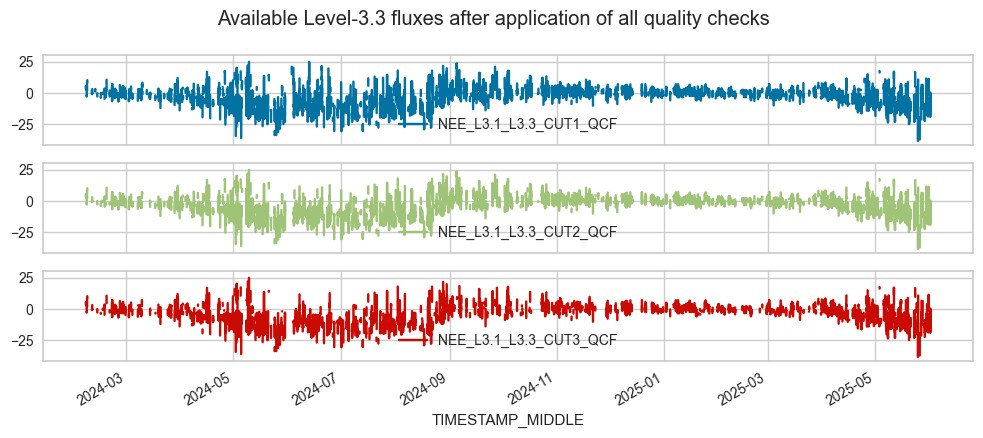

In [106]:
_fluxcols = [x for x in fpc.fpc_df.columns if 'L3.1' and 'L3.3' in x and str(x).endswith('_QCF') and not str(x).startswith('FLAG_')]
fpc.fpc_df[_fluxcols].plot(subplots=True, x_compat=True, title="Available Level-3.3 fluxes after application of all quality checks", figsize=(12, 4.5));    

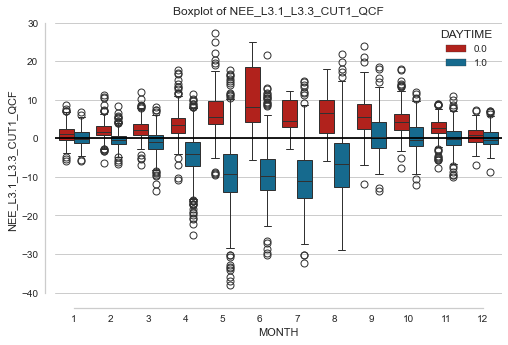

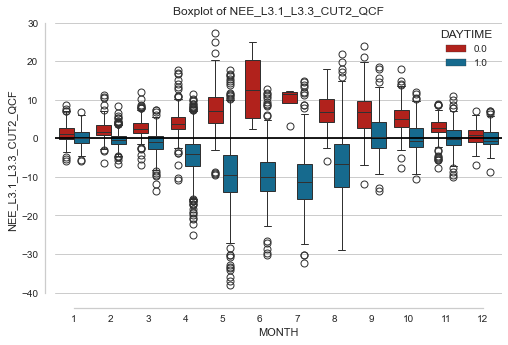

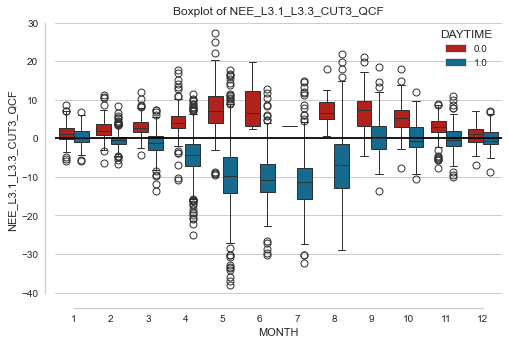

In [107]:
# Draw boxplots
_fluxcols = [x for x in fpc.fpc_df.columns if 'L3.1' and 'L3.3' in x and str(x).endswith('_QCF') and not str(x).startswith('FLAG_')]
for _f in _fluxcols:
    boxplots_df = fpc.fpc_df[[_f, "DAYTIME"]].copy()
    boxplots_df["MONTH"] = boxplots_df.index.month
    # sns.set_theme(style="ticks", palette="pastel")
    plt.figure(figsize=(8, 5), dpi=72)
    sns.boxplot(x="MONTH", y=_f, palette=["r", "b"], hue="DAYTIME", data=boxplots_df).set_title(f"Boxplot of {_f}")
    sns.despine(offset=10, trim=True)
    plt.axhline(0, color="black");

### Cumulatives of Level data (not-gap-filled)

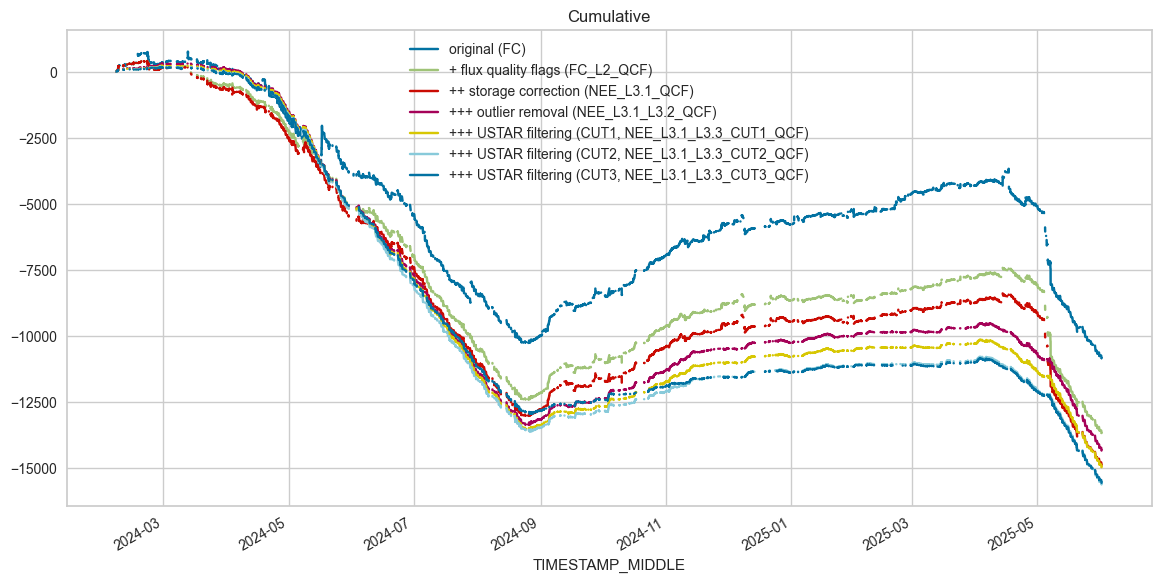

In [108]:
# Creating a dictionary by passing Series objects as values
frame = {
    f'original ({FLUXVAR})': fpc.fpc_df[FLUXVAR],
    f'+ flux quality flags ({FLUXVAR2QCF})': fpc.fpc_df[FLUXVAR2QCF],
    f'++ storage correction ({FLUXVAR31QCF})': fpc.fpc_df[FLUXVAR31QCF],
    f'+++ outlier removal ({FLUXVAR32QCF})': fpc.fpc_df[FLUXVAR32QCF]
}
for key, value in FLUXVAR33QCF.items():
    frame[f'+++ USTAR filtering ({key}, {FLUXVAR33QCF[key].name})'] = FLUXVAR33QCF[key]

overview = pd.DataFrame(frame)
overview.cumsum().plot(title=f"Cumulative", figsize=(14, 7), x_compat=True, alpha=1);

</br>

</br>

</br>

## Save Level-3.3 results to file (optional)
- If needed, save results so far (input data and all created variables, e.g. flags and filtered fluxes) to a file
- This can be useful if e.g. gap-filling should be done elsewhere (ReddyProc...)

In [109]:
# results_df = fpc.get_data()
# filename = "51.1_FluxProcessingChain_after-L3.3_NEE"
# results_df.to_csv(f"{filename}.csv", index=True)
# save_parquet(data=results_df, filename=filename)

</br>

</br>

---

# Level-4.1: **GAP-FILLING**

---

- Introduced in `diive` v0.85.0, gap-filling can now be done using both random forest and MDS
- For gap-filling using MDS, make sure that variables are in the required units: short-wave incoming radiation in `W m-2`, air temperature in `°C`, VPD in `hPa`

Parameters:
- `mds_settings` are parameters for the MDS gap-filling method, [see docstring here for more details](https://github.com/holukas/diive/blob/main/diive/pkgs/gapfilling/mds.py)
- `rf_settings` are parameters for scikit's `RandomForestRegressor` model, [see their official documentation for allowed parameters](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)
- `ml_feature_settings` are general settings for machine-learning models (such as random forest)

In [110]:
fpc.level41_gapfilling_longterm(
    run_mds=True,
    run_random_forest=True,
    verbose=True,
    ml_feature_settings={
        'features': ["TA_EP", "SW_IN_POT", "VPD_EP"],
        'features_lag': [-1, -1],
        'features_lag_stepsize': 1,
        'reduce_features': False,
        'include_timestamp_as_features': True,
        'add_continuous_record_number': True,
        'perm_n_repeats': 2,
        },
    rf_settings={
        'n_estimators': 99,
        'random_state': 42,
        'min_samples_split': 10,
        'min_samples_leaf': 5,
        'n_jobs': -1
        },
    mds_settings={
        'swin': "SW_IN_POT",
        'ta': "TA_EP",
        'vpd': "VPD_EP",
        'swin_tol': [20, 50],  # in W m-2
        'ta_tol': 2.5,  # in °C
        'vpd_tol': 5,  # in hPa
        'avg_min_n_vals': 5
    }
)



Starting gap-filling for
NEE_L3.1_L3.3_CUT1_QCF
using <class 'sklearn.ensemble._forest.RandomForestRegressor'>

Adding new data columns ...
++ Added new columns with lagged variants for: ['TA_EP', 'SW_IN_POT', 'VPD_EP'] (lags between -1 and -1 with stepsize 1), no lagged variants for: ['NEE_L3.1_L3.3_CUT1_QCF']. Shifting the time series created gaps which were then filled with the nearest value.
++ Added new columns with timestamp info: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] 
++ Added new column .RECORDNUMBER with record numbers from 1 to 23100.

Sanitizing timestamp ...
>>> Validating timestamp naming of timestamp column TIMESTAMP_MIDDLE ... Timestamp name OK.
>>> Converting timestamp TIMESTAMP_MIDDLE to datetime ... OK
>>> All rows have timestamp TIMESTAMP_MIDDLE, no rows removed.
>>> Sorting timestamp TIMESTAMP_MIDDLE ascending ...
>>> Removing data records with duplicate indexes ... OK (no duplicates found in timestamp inde

## Get results
- Results from the flux processing chain can be accessed using `.get_data()`
- This returns a dataframe containing all input data and all newly generated variables, such as quality flags, quality-filtered fluxes and gap-filled fluxes

In [111]:
results = fpc.get_data(verbose=1)
results

NEW VARIABLES FROM FLUX PROCESSING CHAIN:
++ FLAG_L2_FC_MISSING_TEST
++ FLAG_L2_FC_SSITC_TEST
++ FLAG_L2_FC_COMPLETENESS_TEST
++ FLAG_L2_FC_SCF_TEST
++ FLAG_L2_FC_SIGNAL_STRENGTH_TEST
++ FLAG_L2_FC_CO2_VM97_SPIKE_HF_TEST
++ FLAG_L2_FC_CO2_VM97_AMPLITUDE_RESOLUTION_HF_TEST
++ FLAG_L2_FC_CO2_VM97_DROPOUT_TEST
++ SUM_L2_FC_HARDFLAGS
++ SUM_L2_FC_SOFTFLAGS
++ SUM_L2_FC_FLAGS
++ FLAG_L2_FC_QCF
++ FC_L2_QCF
++ FC_L2_QCF0
++ SC_SINGLE_gfRMED_L3.1
++ FLAG_SC_SINGLE_gfRMED_L3.1_ISFILLED
++ NEE_L3.1
++ NEE_L3.1_QCF
++ NEE_L3.1_QCF0
++ FLAG_L3.2_NEE_L3.1_QCF_OUTLIER_ABSLIM_TEST
++ FLAG_L3.2_NEE_L3.1_QCF_OUTLIER_HAMPELDTNT_TEST
++ SUM_L3.2_NEE_L3.1_HARDFLAGS
++ SUM_L3.2_NEE_L3.1_SOFTFLAGS
++ SUM_L3.2_NEE_L3.1_FLAGS
++ FLAG_L3.2_NEE_L3.1_QCF
++ NEE_L3.1_L3.2_QCF
++ NEE_L3.1_L3.2_QCF0
++ FLAG_L3.3_CUT1_NEE_L3.1_USTAR_TEST
++ SUM_L3.3_CUT1_NEE_L3.1_HARDFLAGS
++ SUM_L3.3_CUT1_NEE_L3.1_SOFTFLAGS
++ SUM_L3.3_CUT1_NEE_L3.1_FLAGS
++ FLAG_L3.3_CUT1_NEE_L3.1_QCF
++ NEE_L3.1_L3.3_CUT1_QCF
++ NEE_L3.1_L3.3_CU

AIR_MV  AIR_DENSITY  AIR_RHO_CP   AIR_CP  AOA_METHOD  AXES_ROTATION_METHOD  ...  NEE_L3.1_L3.3_CUT1_QCF_gfMDS  FLAG_NEE_L3.1_L3.3_CUT1_QCF_gfMDS_ISFILLED  NEE_L3.1_L3.3_CUT2_QCF_gfMDS  FLAG_NEE_L3.1_L3.3_CUT2_QCF_gfMDS_ISFILLED  NEE_L3.1_L3.3_CUT3_QCF_gfMDS  FLAG_NEE_L3.1_L3.3_CUT3_QCF_gfMDS_ISFILLED
TIMESTAMP_MIDDLE                                                                                   ...                                                                                                                                                                                                                              
2024-02-06 19:15:00  0.024925      1.16151     1172.76  1009.69         0.0                   1.0  ...                      2.156673                                         0.0                      2.156673                                         0.0                      2.156673                                         0.0
2024-02-06 19:45:00       NaN          NaN         NaN      NaN         NaN                   NaN  ...                      4.107000                                         3.0                      4.964417                                         3.0                      5.529866                                         3.0
2024-02-06 20:15:00       NaN          NaN         NaN      NaN         NaN                   NaN  ...                      4.107000                                         3.0                      4.964417                                         3.0                      5.529866                                         3.0
2024-02-06 20:45:00       NaN          NaN         NaN      NaN         NaN                   NaN  ...                      4.107000                                         3.0                      4.964417                                         3.0                      5.529866                                         3.0
2024-02-06 21:15:00       NaN          NaN         NaN      NaN         NaN                   NaN  ...                      4.107000                                         3.0                      4.964417                                         3.0                      5.529866                                         3.0
...                       ...          ...         ...      ...         ...                   ...  ...                           ...                                         ...                           ...                                         ...                           ...                                         ...
2025-06-01 22:45:00       NaN          NaN         NaN      NaN         NaN                   NaN  ...                      1.893390                                         8.0                      2.785045                                         8.0                      2.483786                                         8.0
2025-06-01 23:15:00       NaN          NaN         NaN      NaN         NaN                   NaN  ...                      1.893390                                         8.0                      2.785045                                         8.0                      2.483786                                         8.0
2025-06-01 23:45:00       NaN          NaN         NaN      NaN         NaN                   NaN  ...                      1.893390                                         8.0                      2.785045                                         8.0                      2.483786                                         8.0
2025-06-02 00:15:00       NaN          NaN         NaN      NaN         NaN                   NaN  ...                      1.893390                                         8.0                      2.785045                                         8.0                      2.483786                                         8.0
2025-06-02 00:45:00       NaN          NaN         NaN      NaN         NaN                   NaN  ...                     

## Model scores

### Model scores and details on test data

In [112]:
# Show train/test details
fpc.report_traintest_model_scores(outpath=".")  # Save in current folder
fpc.report_traintest_details(outpath=".")  # Save in current folder


MODEL SCORES from TRAINING/TESTING (random_forest): 
 trained on training data, tested on unseen test data CUT1
            2024       2025
mae     2.516913   2.516913
medae   1.602801   1.602801
mse    15.364658  15.364658
rmse    3.919778   3.919778
mape    1.439024   1.439024
maxe   30.020067  30.020067
r2      0.699659   0.699659

MODEL SCORES from TRAINING/TESTING (random_forest): 
 trained on training data, tested on unseen test data CUT2
            2024       2025
mae     2.592166   2.592166
medae   1.703755   1.703755
mse    15.294114  15.294114
rmse    3.910769   3.910769
mape    1.333074   1.333074
maxe   25.689156  25.689156
r2      0.694474   0.694474

MODEL SCORES from TRAINING/TESTING (random_forest): 
 trained on training data, tested on unseen test data CUT3
            2024       2025
mae     2.696413   2.696413
medae   1.767487   1.767487
mse    16.439836  16.439836
rmse    4.054607   4.054607
mape    1.476357   1.476357
maxe   26.236789  26.236789
r2      0.710968 

### Model scores on all data

In [113]:
fpc.report_gapfilling_model_scores(outpath=".")  # Save in current folder


MODEL SCORES (random_forest): CUT1
            2024       2025
mae     1.930864   1.930864
medae   1.199692   1.199692
mse     9.141159   9.141159
rmse    3.023435   3.023435
mape    1.373779   1.373779
maxe   30.020067  30.020067
r2      0.817430   0.817430

MODEL SCORES (random_forest): CUT2
            2024       2025
mae     1.956634   1.956634
medae   1.216860   1.216860
mse     9.215794   9.215794
rmse    3.035753   3.035753
mape    1.439688   1.439688
maxe   25.689156  25.689156
r2      0.821755   0.821755

MODEL SCORES (random_forest): CUT3
            2024       2025
mae     1.969102   1.969102
medae   1.237070   1.237070
mse     9.337807   9.337807
rmse    3.055783   3.055783
mape    1.498014   1.498014
maxe   26.236789  26.236789
r2      0.822209   0.822209

MODEL SCORES (mds): CUT1
                                           0
mae                                 2.677270
medae                               1.746563
mse                                15.783615
rmse          

During long-term gap-filling, different years are pooled together to predict one central year, i.e., multiple models are used.  
The used data pools can be display with:

In [114]:
fpc.report_gapfilling_poolyears()

DATA POOLS USED FOR MACHINE-LEARNING GAP-FILLING:
2024: random_forest used data from [2024, 2025] for gap-filling NEE_L3.1_L3.3_CUT1_QCF and producing --> NEE_L3.1_L3.3_CUT1_QCF_gfRF
2025: random_forest used data from [2024, 2025] for gap-filling NEE_L3.1_L3.3_CUT1_QCF and producing --> NEE_L3.1_L3.3_CUT1_QCF_gfRF
2024: random_forest used data from [2024, 2025] for gap-filling NEE_L3.1_L3.3_CUT2_QCF and producing --> NEE_L3.1_L3.3_CUT2_QCF_gfRF
2025: random_forest used data from [2024, 2025] for gap-filling NEE_L3.1_L3.3_CUT2_QCF and producing --> NEE_L3.1_L3.3_CUT2_QCF_gfRF
2024: random_forest used data from [2024, 2025] for gap-filling NEE_L3.1_L3.3_CUT3_QCF and producing --> NEE_L3.1_L3.3_CUT3_QCF_gfRF
2025: random_forest used data from [2024, 2025] for gap-filling NEE_L3.1_L3.3_CUT3_QCF and producing --> NEE_L3.1_L3.3_CUT3_QCF_gfRF
mds CUT1 did not use poolyears.
mds CUT2 did not use poolyears.
mds CUT3 did not use poolyears.


In [115]:
fpc.report_gapfilling_feature_importances(outpath=".")  # Save in current folder


FEATURE IMPORTANCES (random_forest): CUT1
YEAR               2024      2025
FEATURE                          
SW_IN_POT      1.366091  1.366091
.DOY           0.111789  0.111789
.HOUR          0.104988  0.104988
.TA_EP-1       0.087182  0.087182
TA_EP          0.048374  0.048374
.VPD_EP-1      0.046832  0.046832
.RECORDNUMBER  0.044791  0.044791
.SW_IN_POT-1   0.031327  0.031327
VPD_EP         0.028865  0.028865
.YEARDOY       0.018927  0.018927
.WEEK          0.006337  0.006337
.YEARWEEK      0.005331  0.005331
.YEARMONTH     0.001598  0.001598
.MONTH         0.001318  0.001318
.SEASON        0.000853  0.000853
.YEAR          0.000271  0.000271

FEATURE IMPORTANCES (random_forest): CUT2
YEAR               2024      2025
FEATURE                          
SW_IN_POT      1.238455  1.238455
.DOY           0.139832  0.139832
.HOUR          0.100050  0.100050
TA_EP          0.066162  0.066162
.RECORDNUMBER  0.052556  0.052556
.TA_EP-1       0.047636  0.047636
.VPD_EP-1      0.035855  0.035

## Names of gap-filled variables


In [116]:
print("Used model, USTAR scenario, non-gapfilled variable and gap-filled variable:")
fpc.report_gapfilling_variables()

Used model, USTAR scenario, non-gapfilled variable and gap-filled variable:
random_forest (CUT1): NEE_L3.1_L3.3_CUT1_QCF -> NEE_L3.1_L3.3_CUT1_QCF_gfRF
random_forest (CUT2): NEE_L3.1_L3.3_CUT2_QCF -> NEE_L3.1_L3.3_CUT2_QCF_gfRF
random_forest (CUT3): NEE_L3.1_L3.3_CUT3_QCF -> NEE_L3.1_L3.3_CUT3_QCF_gfRF
mds (CUT1): NEE_L3.1_L3.3_CUT1_QCF -> NEE_L3.1_L3.3_CUT1_QCF_gfMDS
mds (CUT2): NEE_L3.1_L3.3_CUT2_QCF -> NEE_L3.1_L3.3_CUT2_QCF_gfMDS
mds (CUT3): NEE_L3.1_L3.3_CUT3_QCF -> NEE_L3.1_L3.3_CUT3_QCF_gfMDS


In [117]:
gapfilled_names = fpc.get_gapfilled_names()
gapfilled_names

['NEE_L3.1_L3.3_CUT1_QCF_gfRF',
 'NEE_L3.1_L3.3_CUT2_QCF_gfRF',
 'NEE_L3.1_L3.3_CUT3_QCF_gfRF',
 'NEE_L3.1_L3.3_CUT1_QCF_gfMDS',
 'NEE_L3.1_L3.3_CUT2_QCF_gfMDS',
 'NEE_L3.1_L3.3_CUT3_QCF_gfMDS']

Gap-filled data can also be accessed directly. To get all gap-filled variables and also the same variables before gap-filling in a dataframe, use `.get_gapfilled_variables()`: 

In [118]:
gapfilled_vars = fpc.get_gapfilled_variables()
gapfilled_vars.head(3)

NEE_L3.1_L3.3_CUT1_QCF_gfRF  NEE_L3.1_L3.3_CUT2_QCF_gfRF  NEE_L3.1_L3.3_CUT3_QCF_gfRF  NEE_L3.1_L3.3_CUT1_QCF_gfMDS  NEE_L3.1_L3.3_CUT2_QCF_gfMDS  NEE_L3.1_L3.3_CUT3_QCF_gfMDS  NEE_L3.1_L3.3_CUT1_QCF  NEE_L3.1_L3.3_CUT2_QCF  NEE_L3.1_L3.3_CUT3_QCF  NEE_L3.1_L3.3_CUT1_QCF  NEE_L3.1_L3.3_CUT2_QCF  NEE_L3.1_L3.3_CUT3_QCF
TIMESTAMP_MIDDLE                                                                                                                                                                                                                                                                                                                                    
2024-02-06 19:15:00                     3.621751                     3.790543                     3.387914                      2.156673                      2.156673                      2.156673                2.156673                2.156673                2.156673                2.156673                2.156673                2.156673
2024-02-06 19:45:00                     3.621751                     3.790543                     3.387914                      4.107000                      4.964417                      5.529866                     NaN                     NaN                     NaN                     NaN                     NaN                     NaN
2024-02-06 20:15:00                     3.528009                     3.463929                     2.727384                      4.107000                      4.964417                      5.529866                     NaN                     NaN                     NaN                     NaN                     NaN                     NaN

The names of the flux that was gap-filled can be accessed like this:

In [119]:
nongapfilled_names = fpc.get_nongapfilled_names()
nongapfilled_names

['NEE_L3.1_L3.3_CUT1_QCF',
 'NEE_L3.1_L3.3_CUT2_QCF',
 'NEE_L3.1_L3.3_CUT3_QCF',
 'NEE_L3.1_L3.3_CUT1_QCF',
 'NEE_L3.1_L3.3_CUT2_QCF',
 'NEE_L3.1_L3.3_CUT3_QCF']

## Plots

### Heatmaps

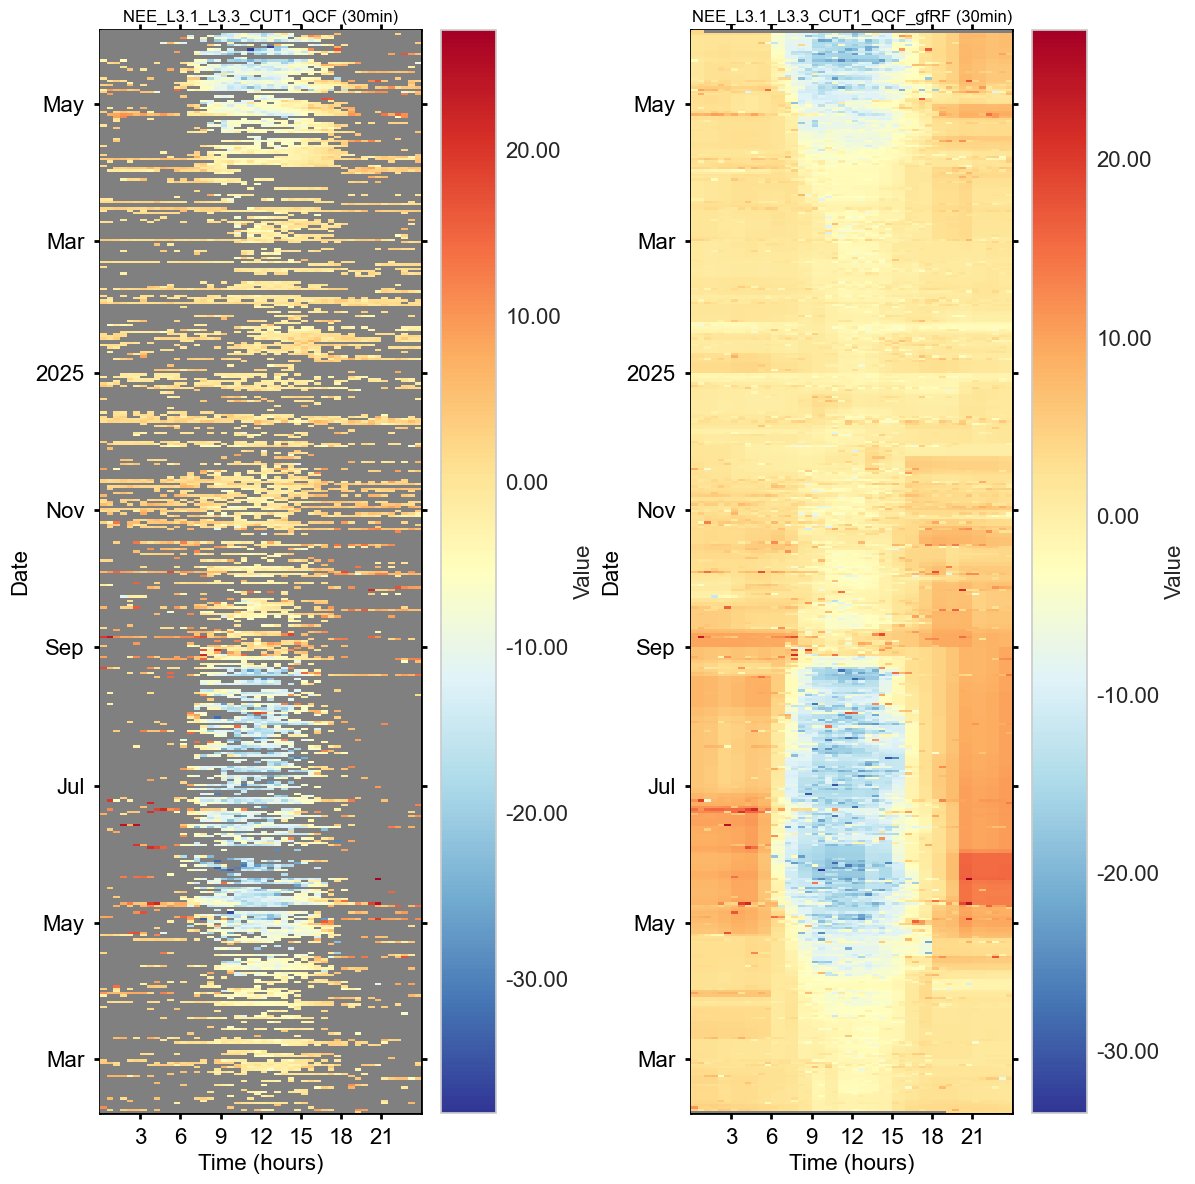

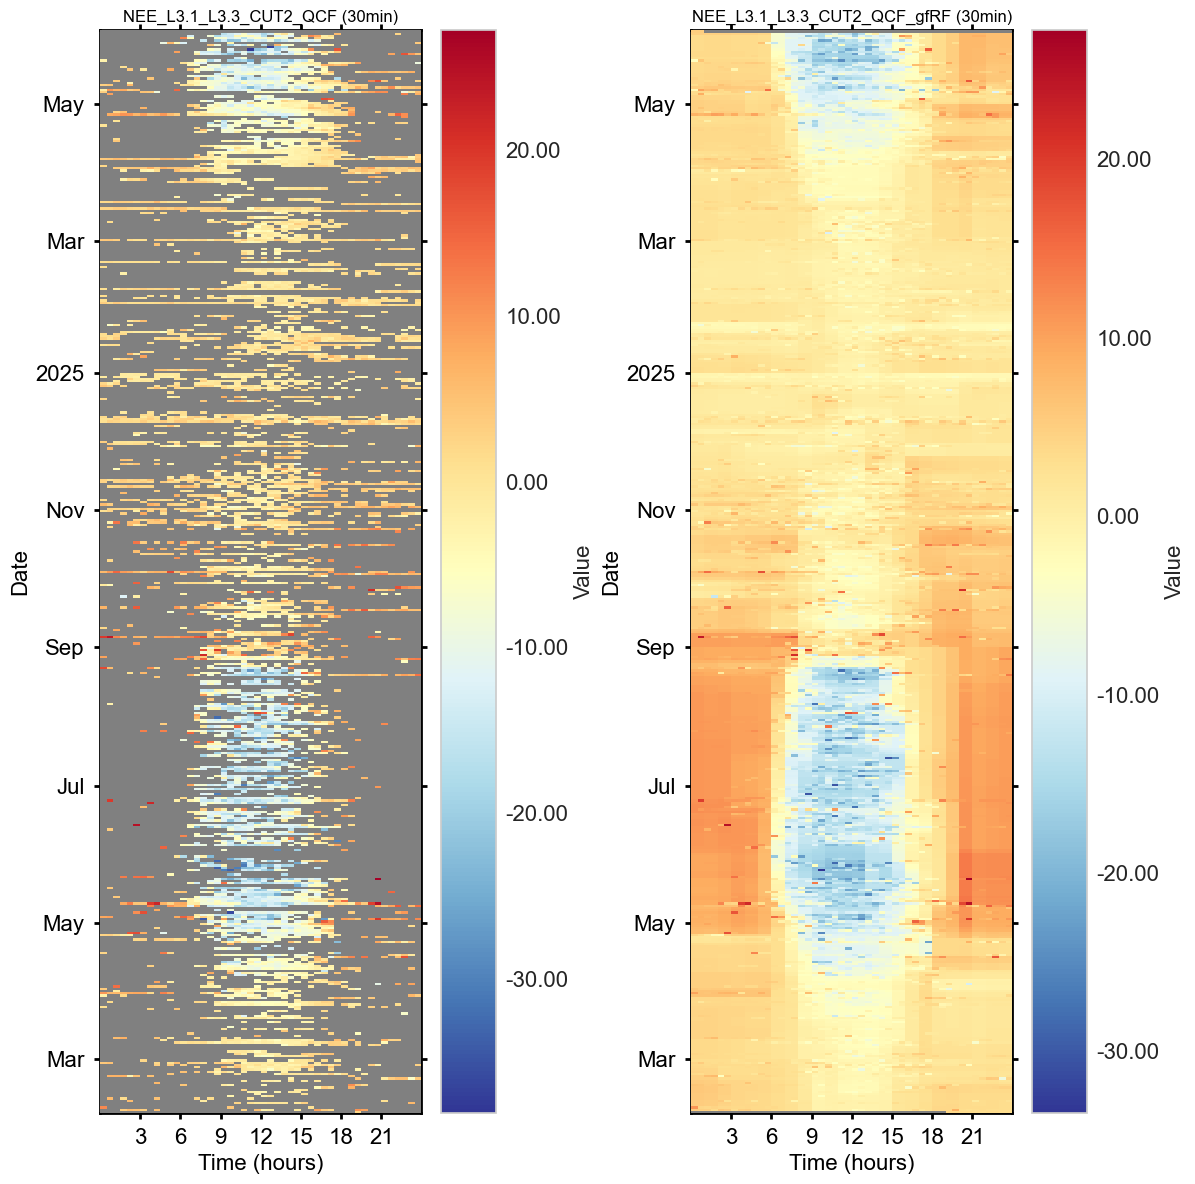

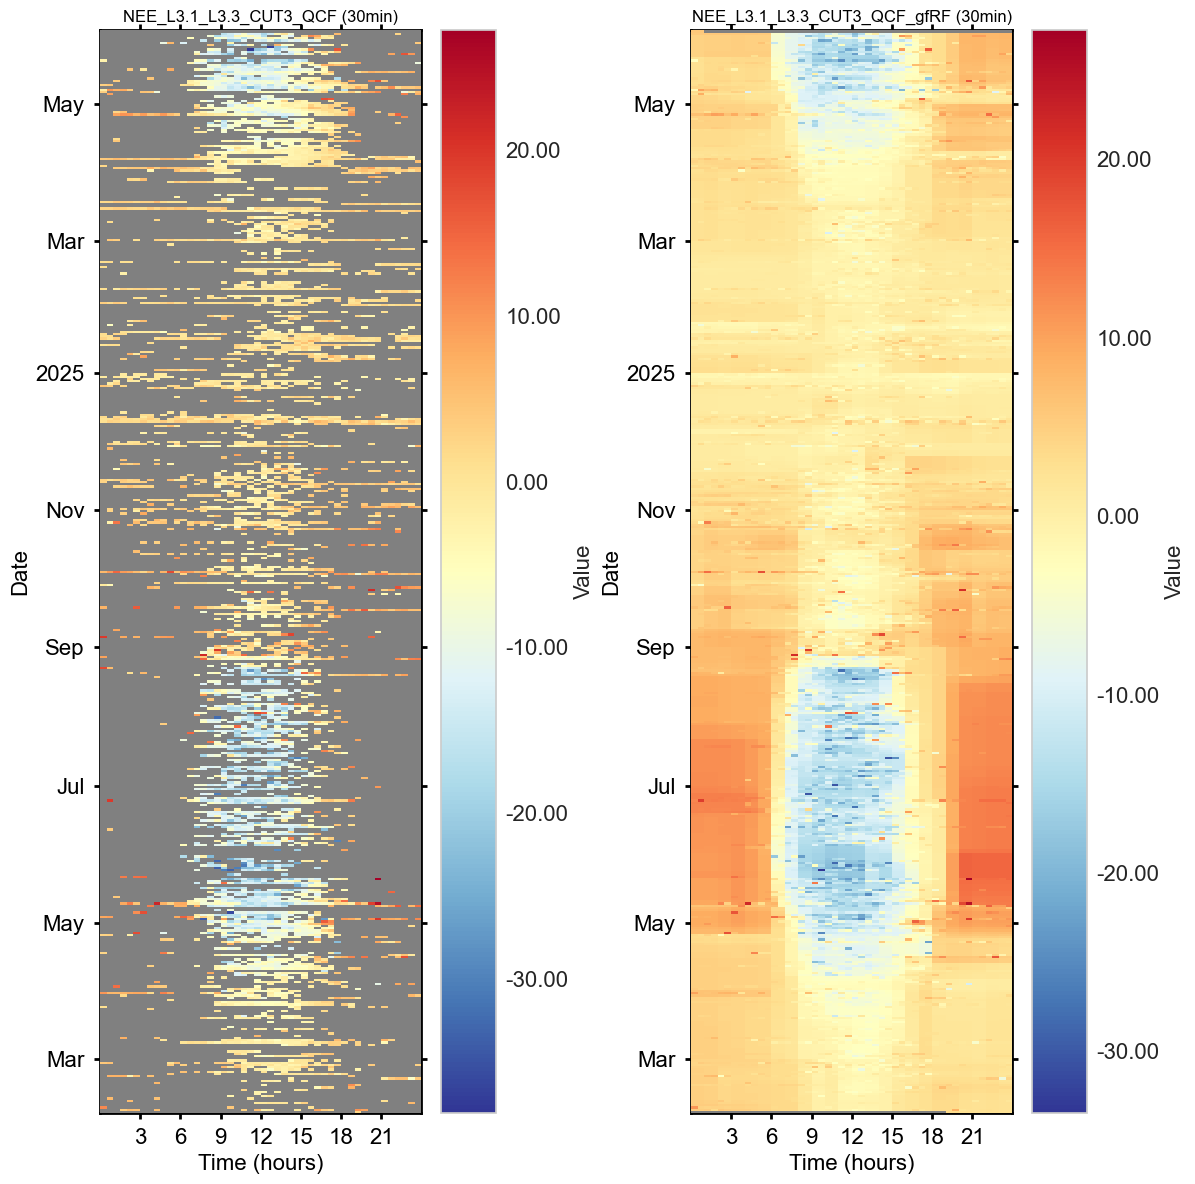

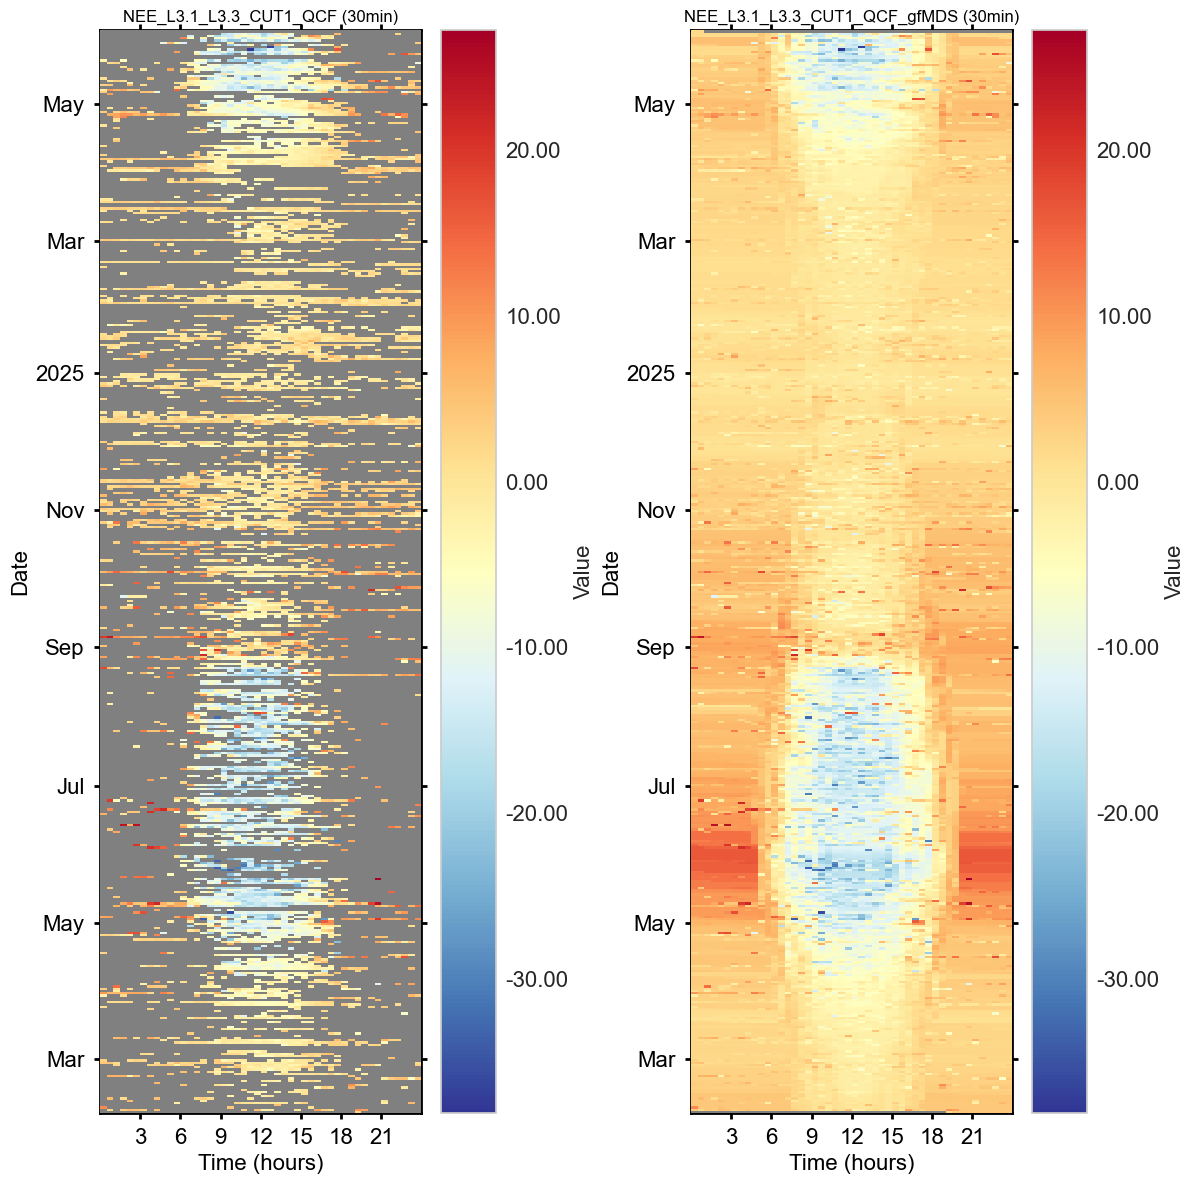

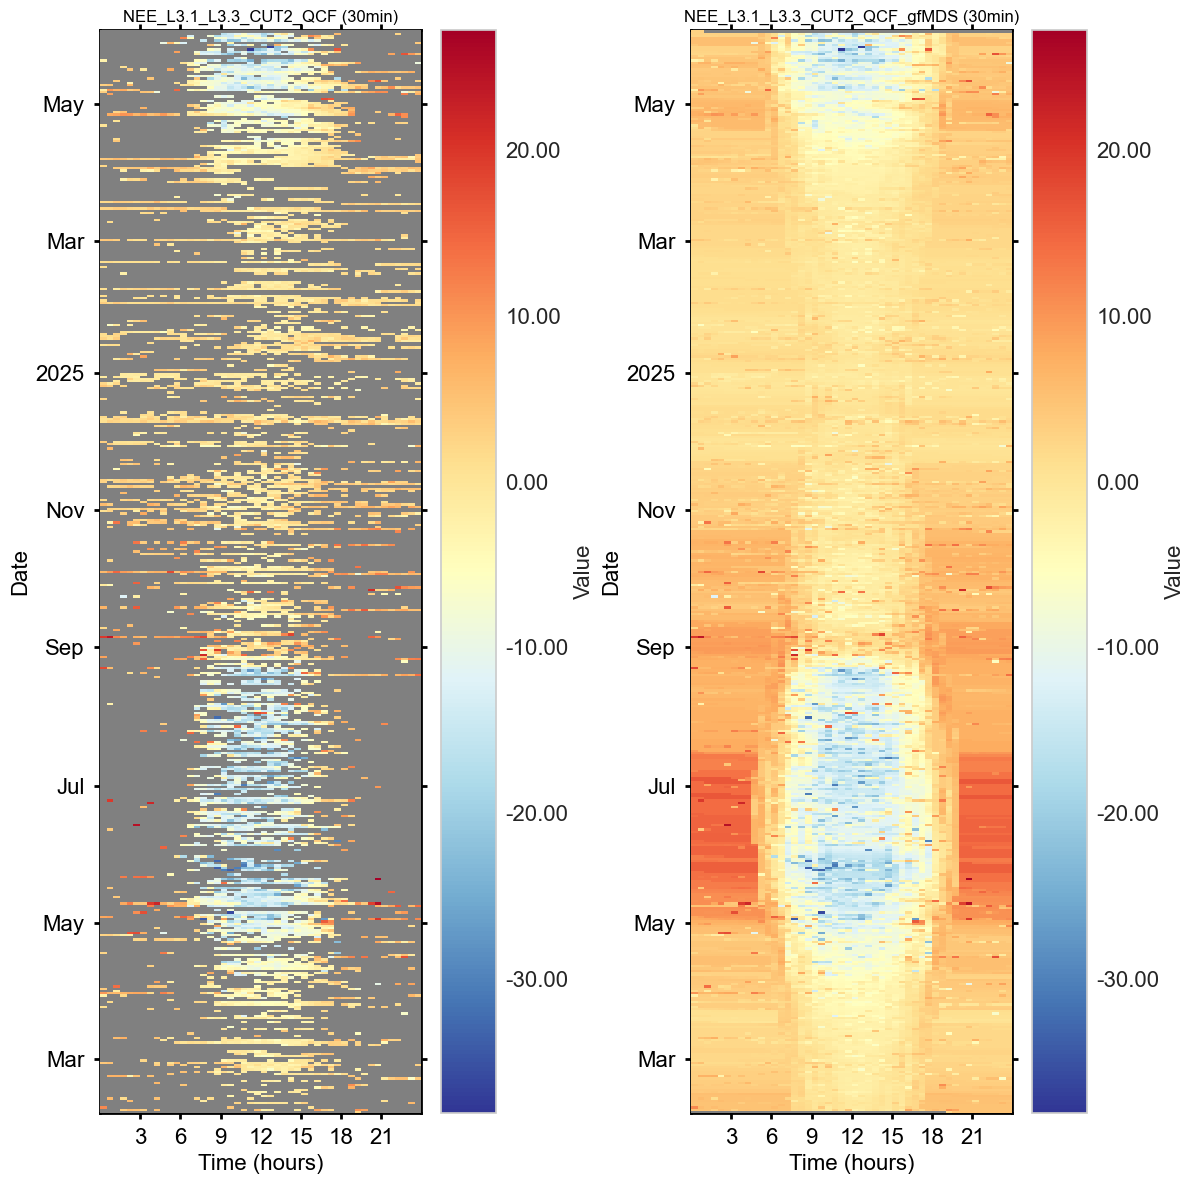

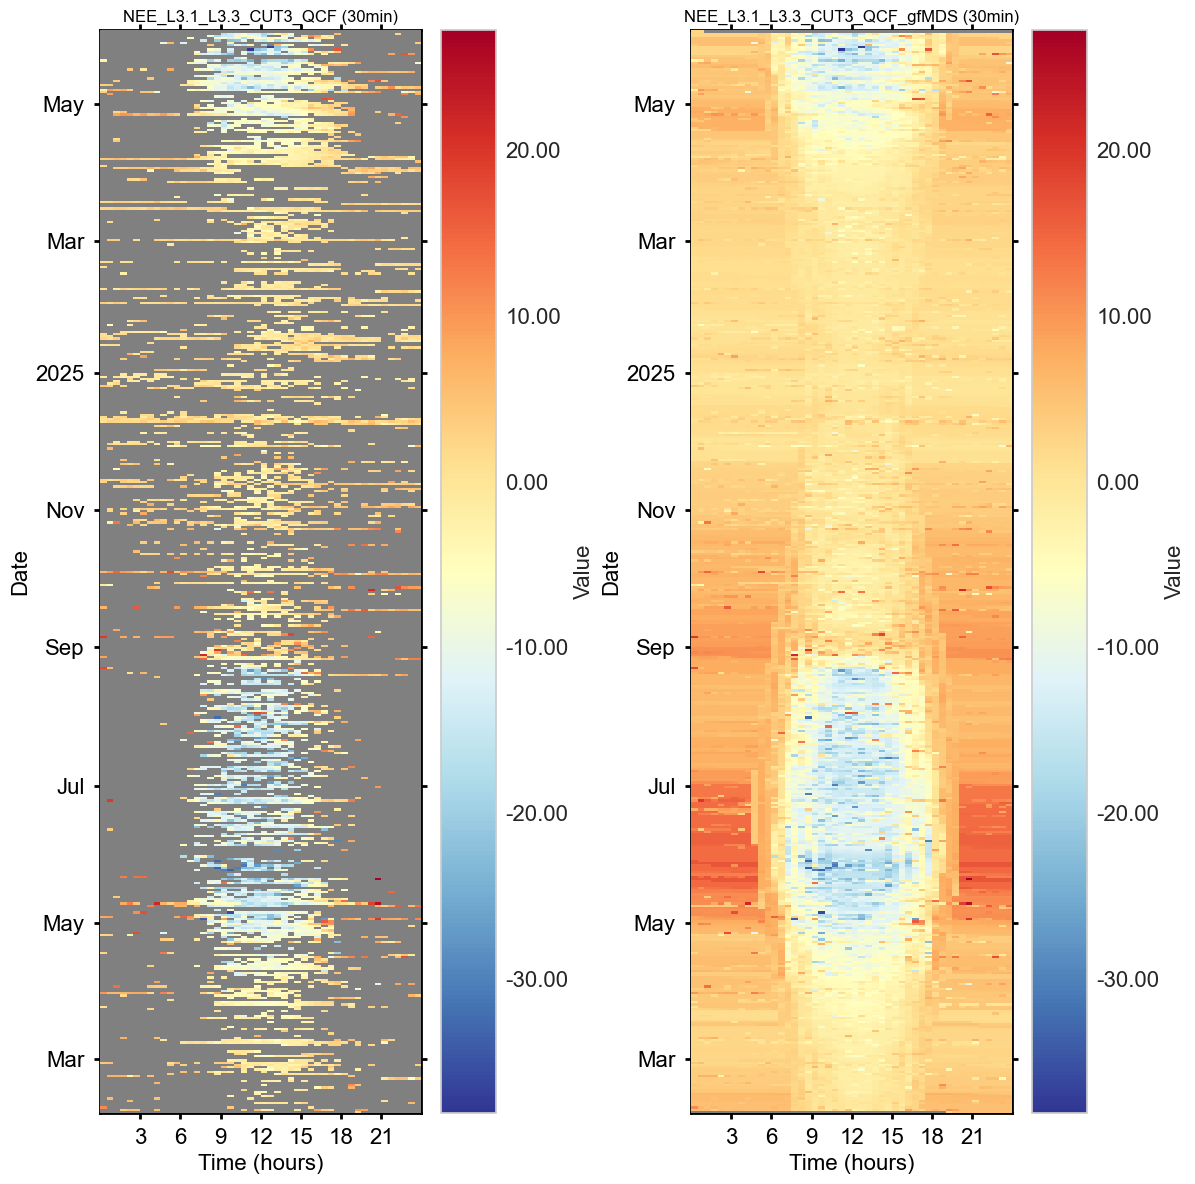

In [120]:
fpc.showplot_gapfilled_heatmap()

### Cumulatives per year

In [121]:
# fpc.showplot_gapfilled_cumulative(gain=0.02161926, units=r'($\mathrm{gC\ m^{-2}}$)', per_year=True)

### Cumulative across all data 

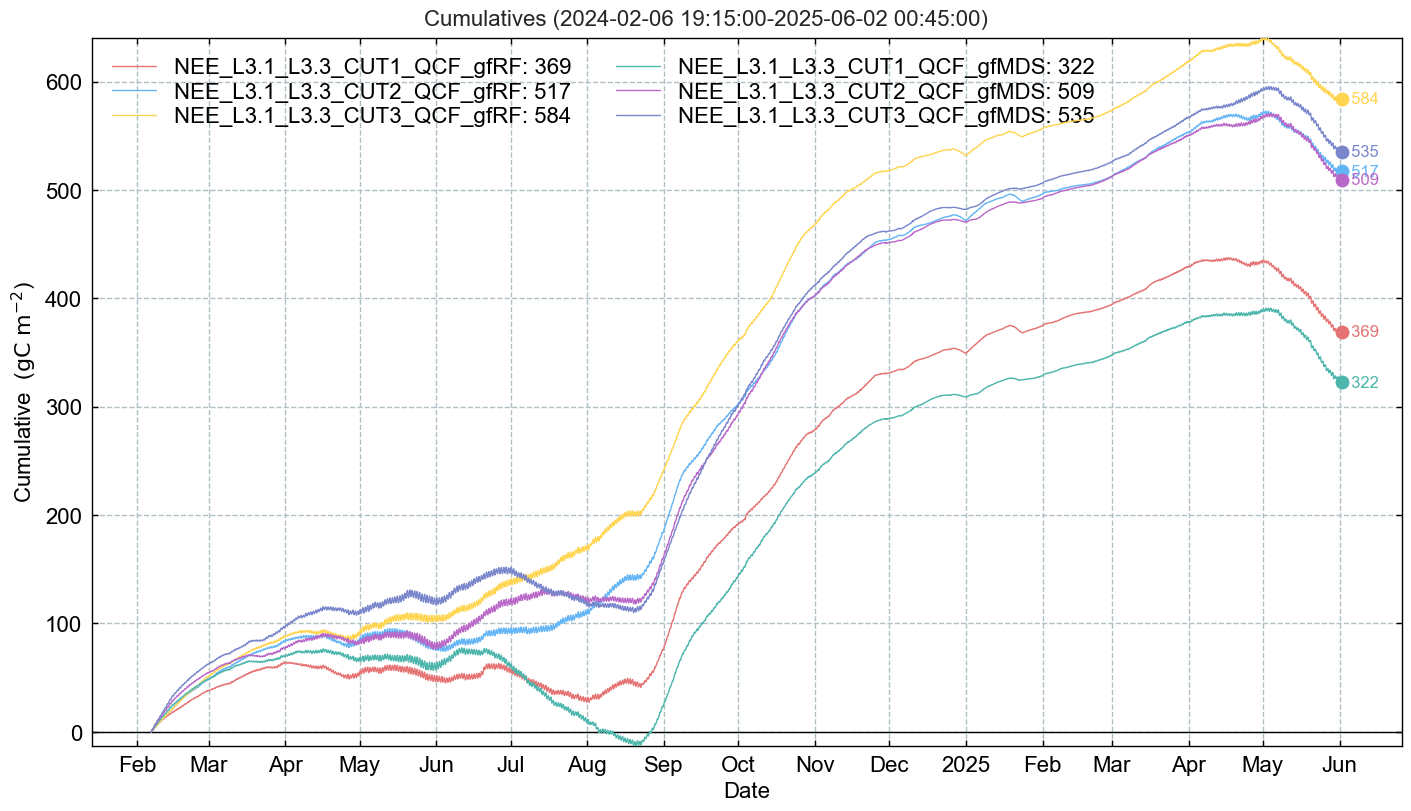

In [122]:
fpc.showplot_gapfilled_cumulative(gain=0.02161926, units=r'($\mathrm{gC\ m^{-2}}$)', per_year=False)

### ML Feature ranks per year (machine learning models only)

mds CUT1 does not have feature ranks.
mds CUT2 does not have feature ranks.
mds CUT3 does not have feature ranks.


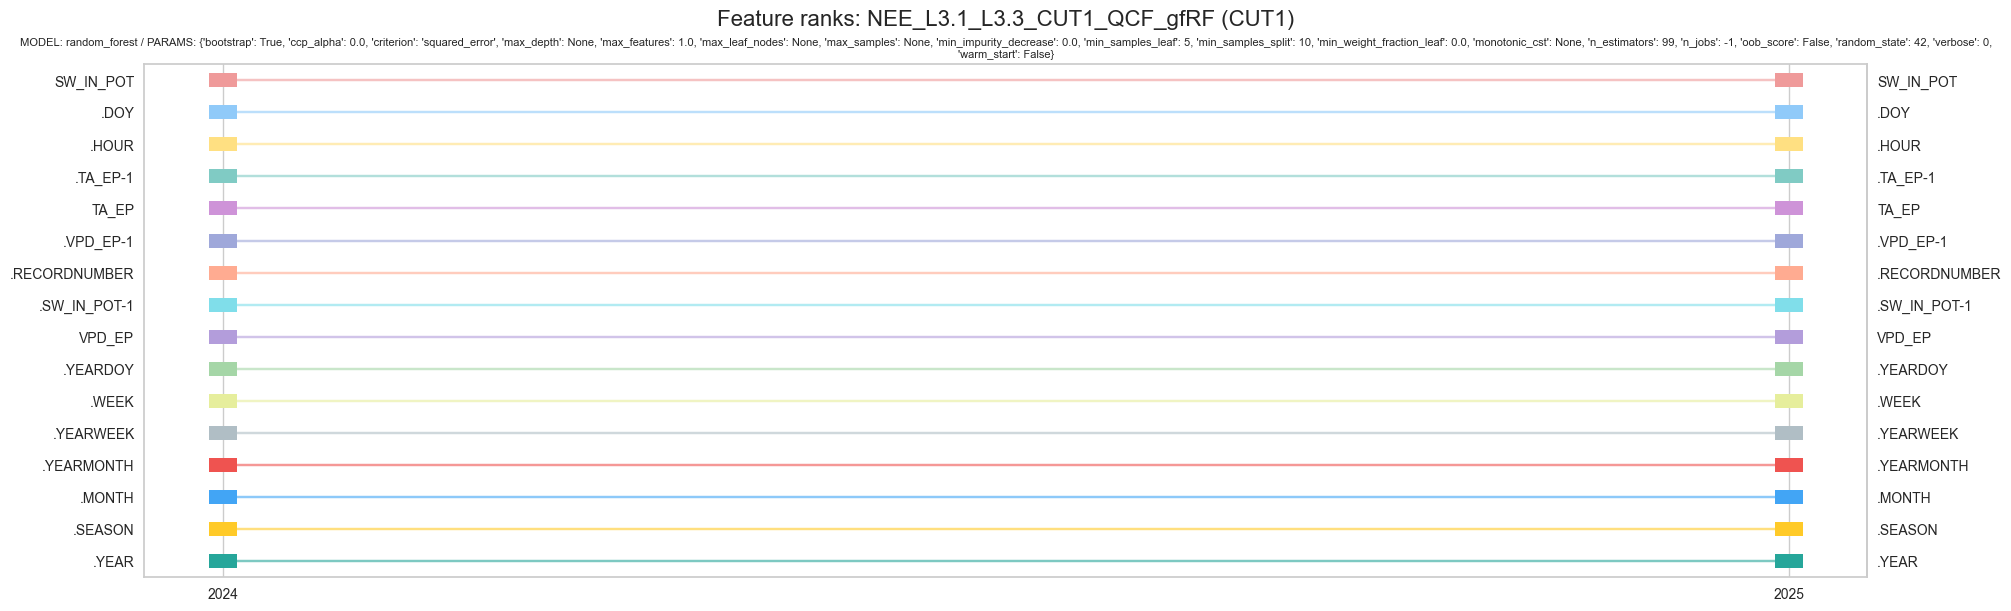

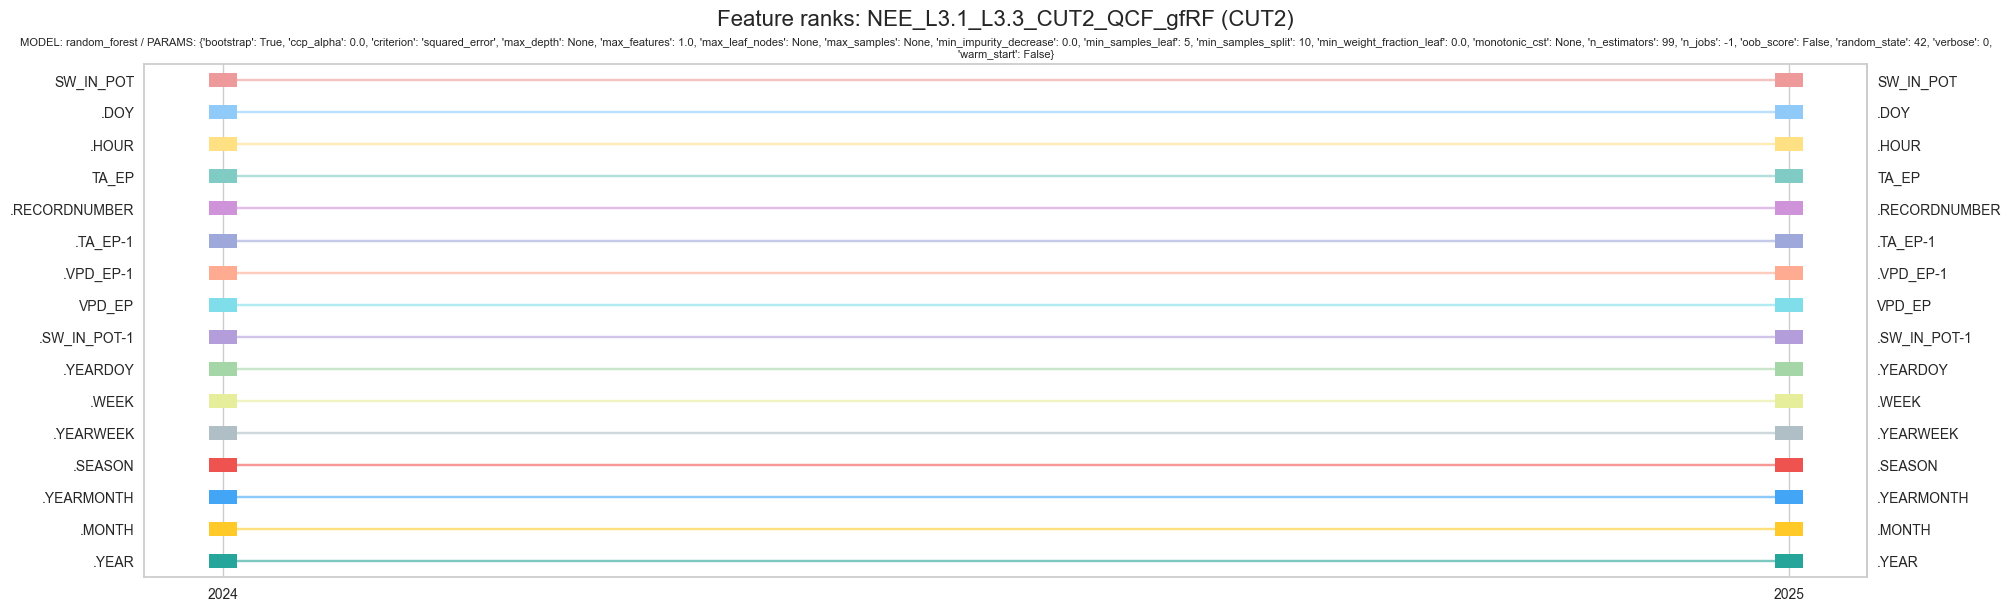

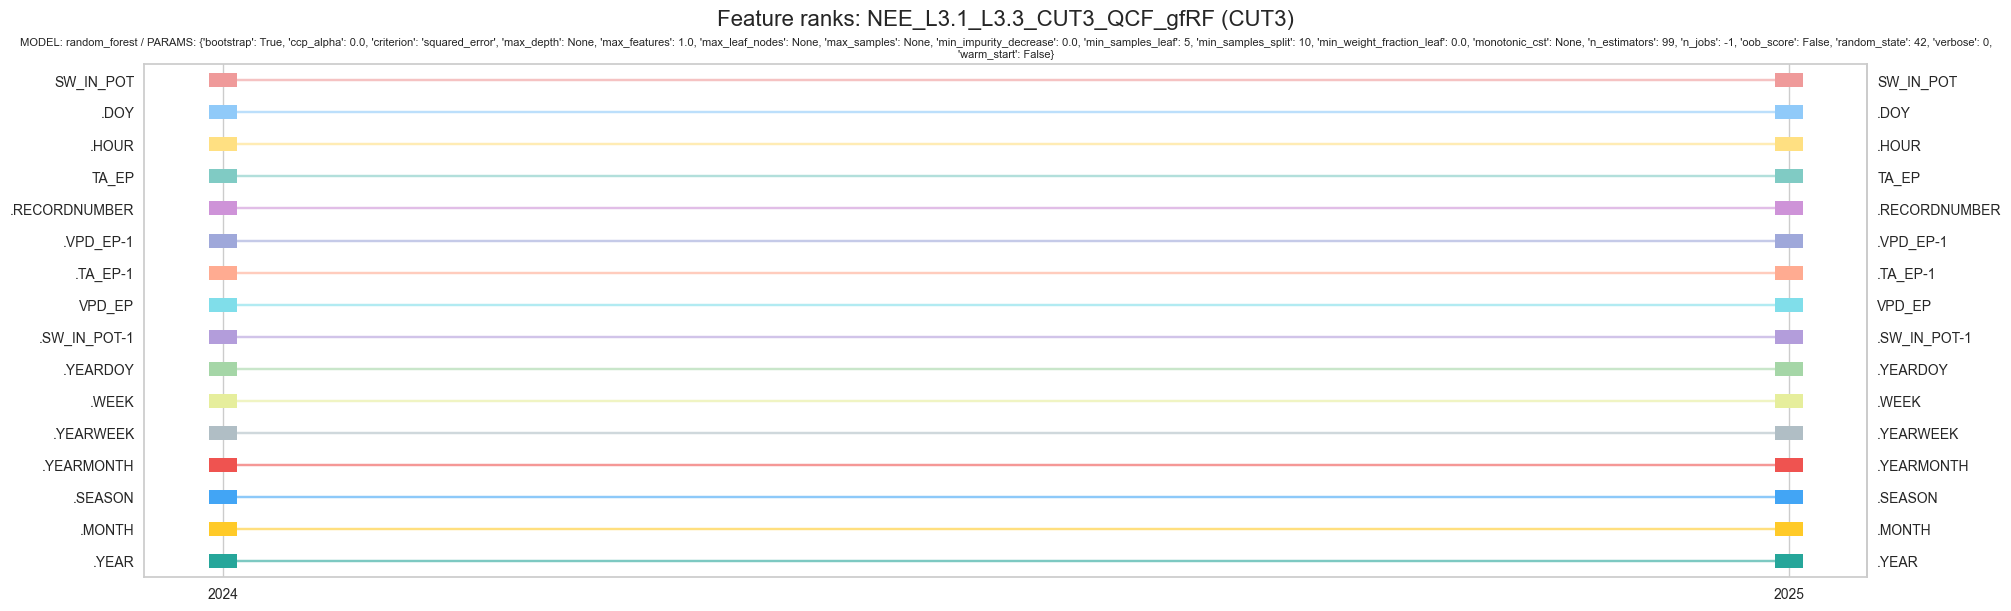

In [123]:
fpc.showplot_feature_ranks_per_year()

### MDS gap-filling qualities (MDS only, otherwise skipped)

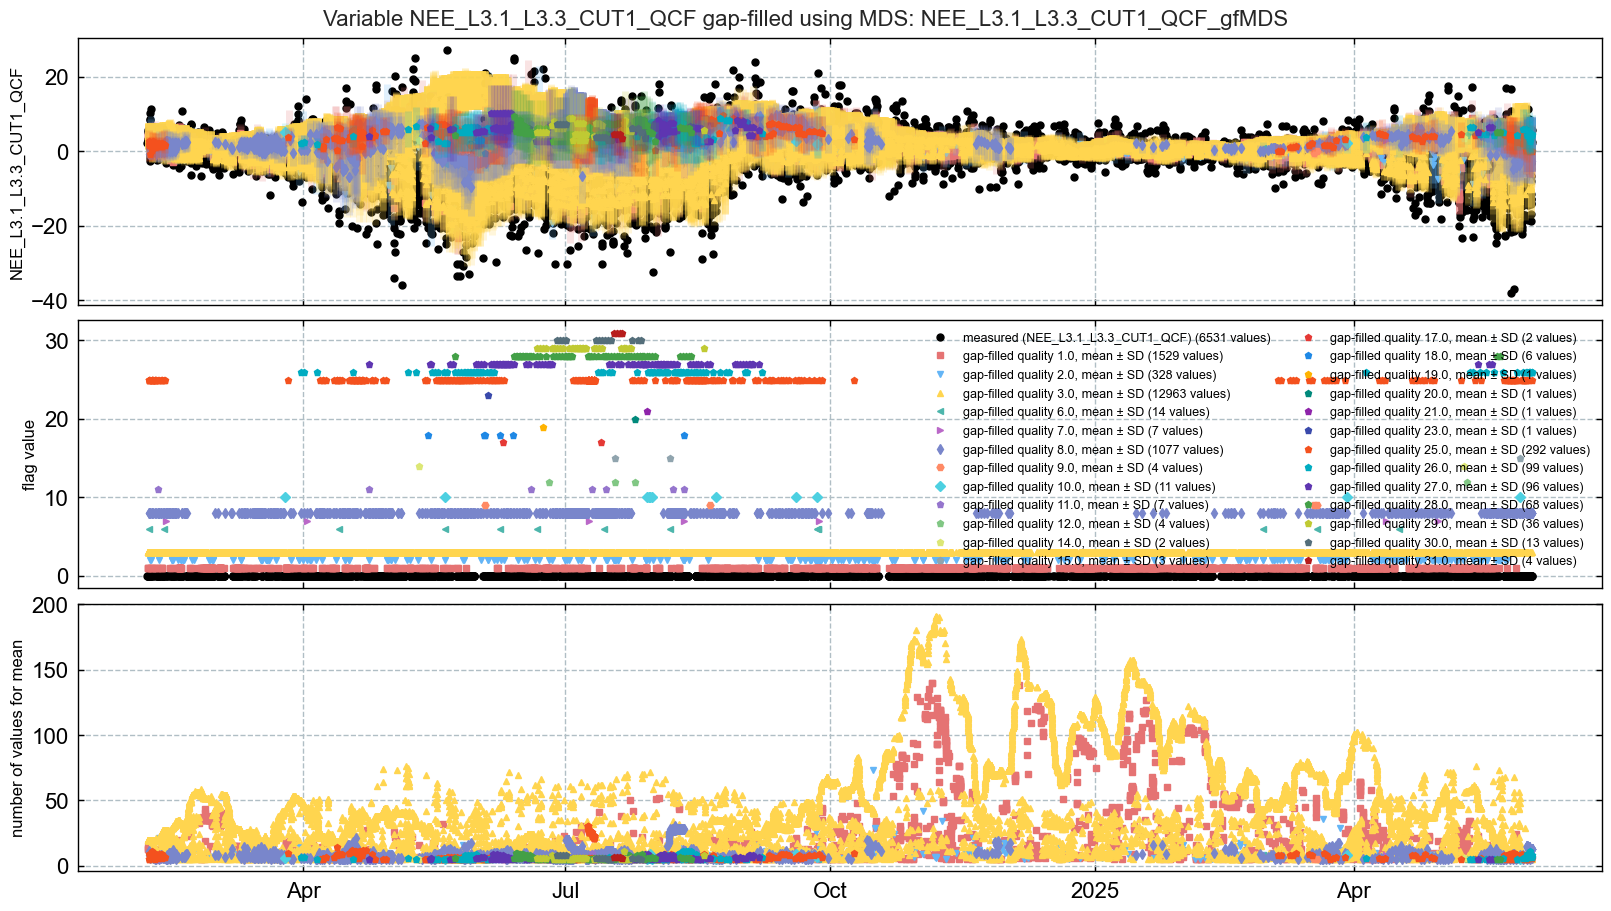

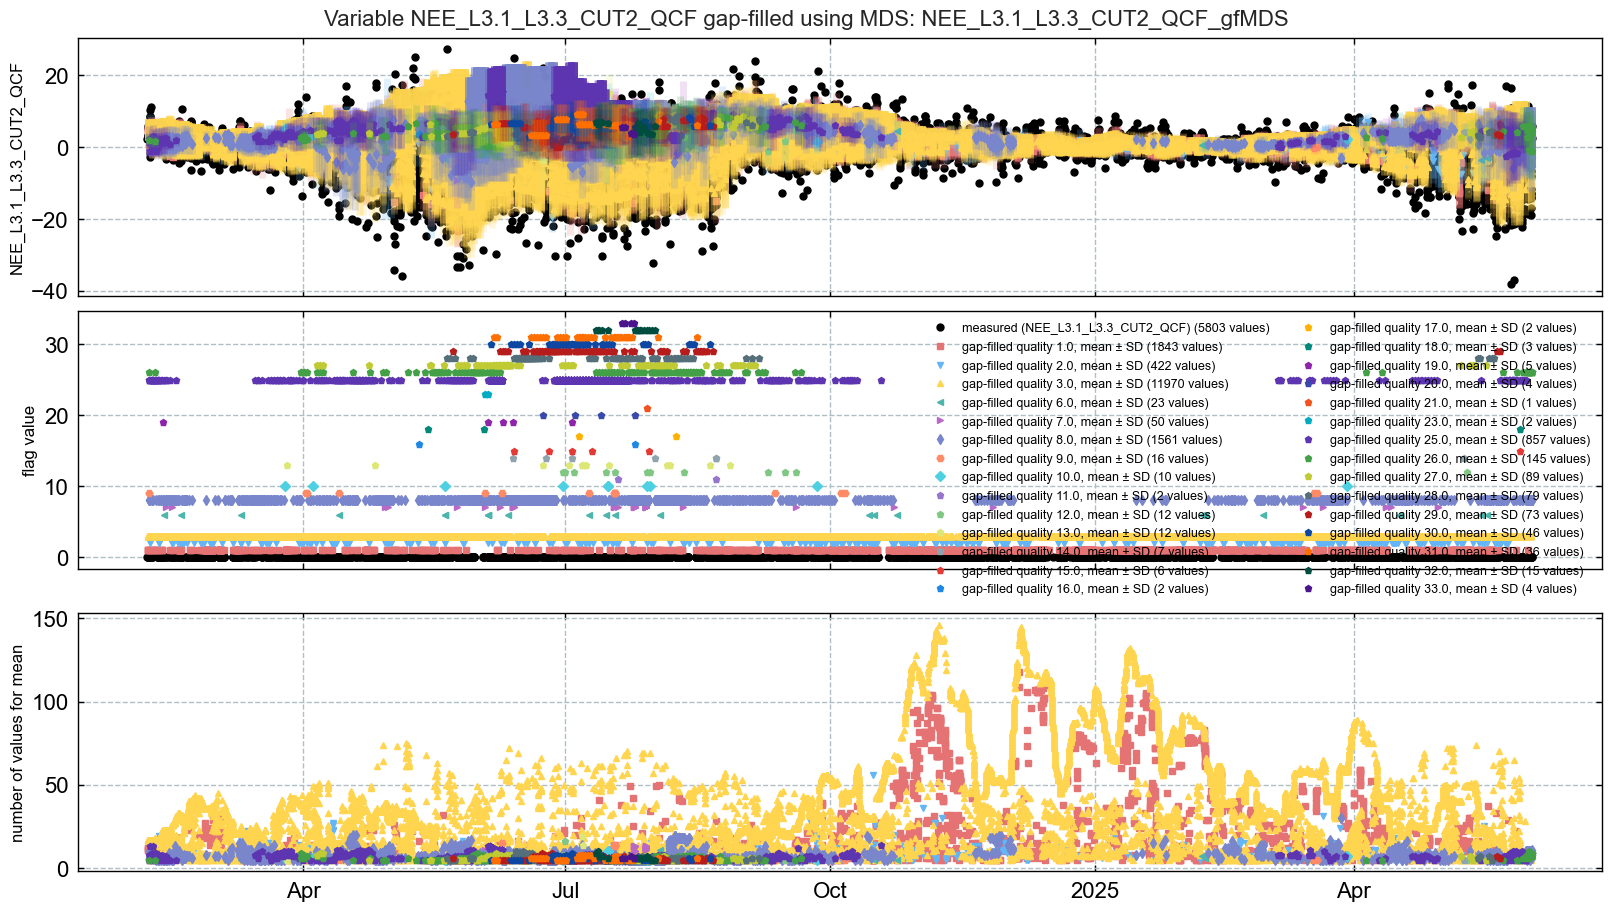

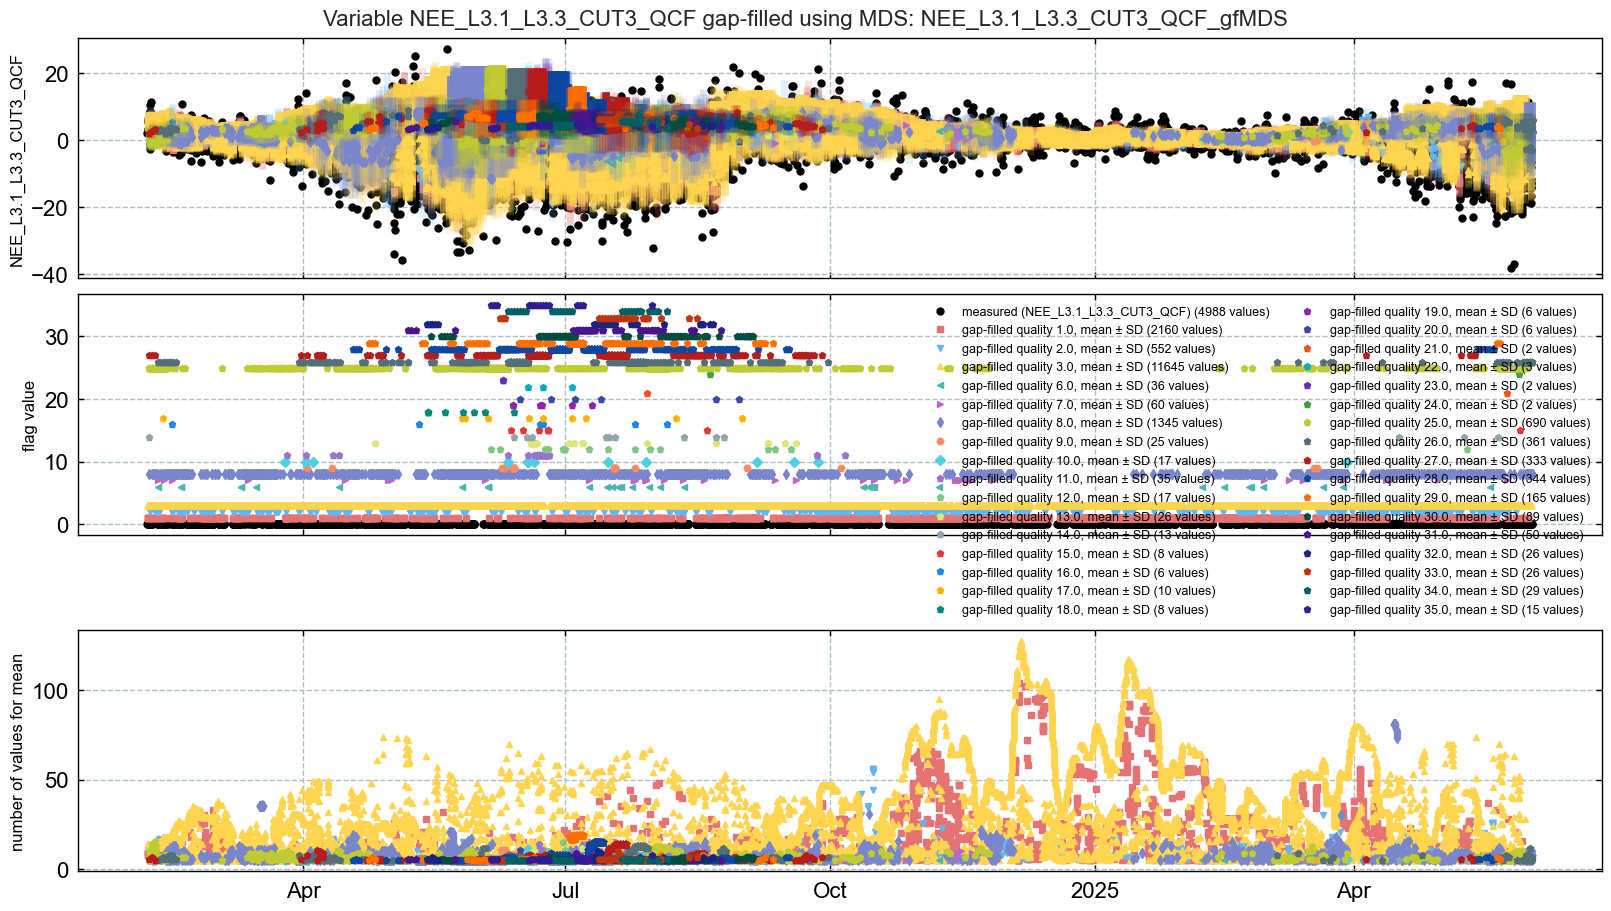

In [124]:
fpc.showplot_mds_gapfilling_qualities()

</br>

</br>

---

# Save results to file

---

- Save results to file for futher processing
- This can be useful if you want to use the data in another software, e.g. continuing post-processing using the library `ReddyProc` in `R` 
- `Parquet` format is recommended for large datasets

</br>

## Option 1: Save complete data (input data and results) to CSV (large and slow)

In [125]:
# results.to_csv("FluxProcessingChain_L4.1.csv")

</br>

## Option 2: Save input data and results to Parquet (small and fast)
- Needed if you want to continue post-processing in notebooks
- Can also be used in `R` with the `arrow` package

In [130]:
save_parquet(data=results, filename="20.2_FluxProcessingChain_L4.1_NEE-L0_3-USTAR-SCENARIOS_PRELIMINARY")

Saved file 20.2_FluxProcessingChain_L4.1_NEE-L0_3-USTAR-SCENARIOS_PRELIMINARY.parquet (0.423 seconds).


'20.2_FluxProcessingChain_L4.1_NEE-L0_3-USTAR-SCENARIOS_PRELIMINARY.parquet'

</br>

</br>

---

# **End of notebook**

---

Congratulations, you reached the end of this notebook! Before you go let's store your finish time.

In [131]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished. {dt_string}")

Finished. 2025-06-04 13:38:59
